In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib.font_manager
%matplotlib inline
#import scipy.ndimage
#from scipy.ndimage.filters import maximum_filter
#import scipy.optimize as opt
#from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
import pymc3 as pm
import arviz as az
import hyperspy.api as hs
#import time
#import math
import os
from IPython.display import clear_output
from mylib.user_func import detect_peaks, twoD_Gaussian, centroid, gauss, generate_cmap

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1. Load image and set parameters

In [2]:
# Parameter
model = "Gaussian"       # "CoM" or "Gaussian"
size_peak_search = 14    # pix size of ROI for peak search
size_peak = 18           # pix size of ROI for Gaussian (or CoM) fitting
threshold = 0.08         # Minimun threshold of peak intensity against maximun intensity of image
edge = 1.2               # region (edge * size_peak) where peak is ignored
n_iter = 4               # Number of loops for Gaussian fit
eps = 3                  # DBSCANのパラメータ
ratio = 15               # Magnification of arrows in displacement map
calibration = 11.4       # pm/pix
display_sigma = 2        # グラフに表示する誤差の大きさ(1: 68%, 2: 95%, 3: 99.7%)
scan_distortion = 0.7    # スキャン影響による変位決定精度の誤差(1標準偏差) [pm]
input_file = "surface_150-atom_BTO.dm4"
output_dir = "output_bayes_BTO_150atom_18pix"
FWHM = size_peak/2       # Initial value of FWHM for Gaussian fitting

# Import an image
cur_dir = os.getcwd()    # Get filepath of current directory
if os.name == "nt":      # If os is Windows
    data_dir = os.path.dirname(cur_dir) + "\\data"
    ds = hs.load(data_dir + "\\" + input_file)
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data"
    ds = hs.load(data_dir + "//" + input_file)      
s = hs.signals.Signal1D(ds)
ydim, xdim, = s.data.shape
Z = np.flipud(s.data)    # Flip vertically because dm4 has inverse definition of y-axis against matplotlib

## 2. Detect peaks roughly

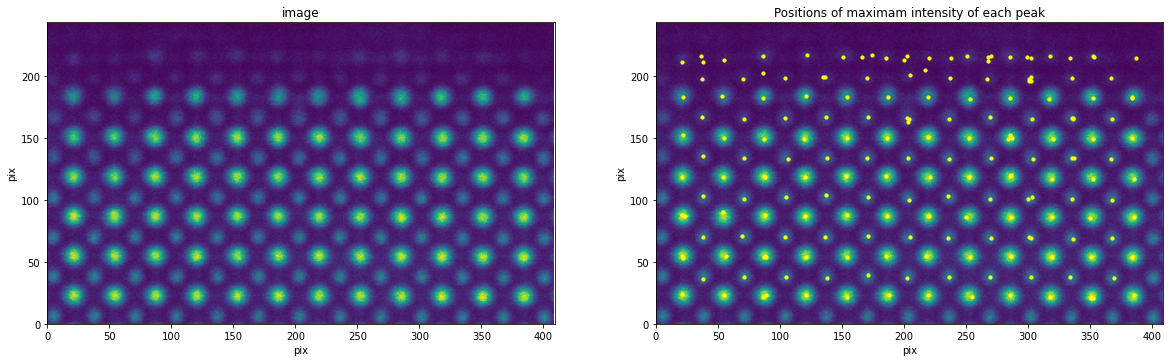

In [3]:
# Search peaks roughly
peaks_maximam = detect_peaks(Z, edge, filter_size=size_peak_search, order=threshold)

# Make plots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_maximam[1], peaks_maximam[0], s=10, c="yellow", marker="o")
ax2.set_title("Positions of maximam intensity of each peak")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
plt.show()

## 3. Remove outliers

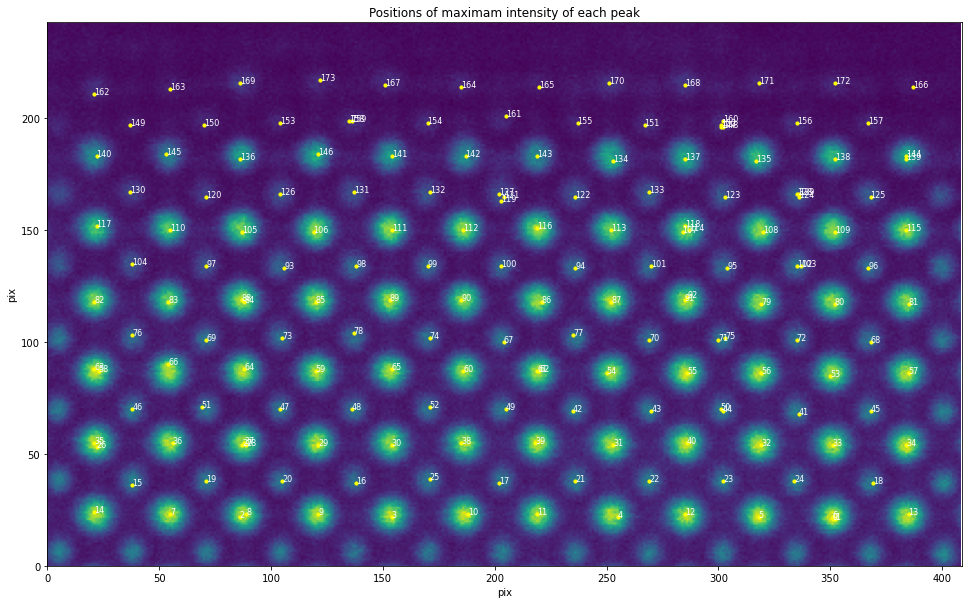

In [9]:
# Make plots
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(Z, origin="lower")
ax.scatter(peaks_maximam[1], peaks_maximam[0], s=10, c="yellow", marker="o")
for i in range(len(peaks_maximam[0])):
    ax.text(peaks_maximam[1][i], peaks_maximam[0][i], str(i), color="white", fontsize=8)
ax.set_title("Positions of maximam intensity of each peak")
ax.set_xlabel("pix")
ax.set_ylabel("pix")
ax.set_xlim(0, xdim)
ax.set_ylim(0, ydim)
plt.show()

In [8]:
# 削除したい輝点の番号をoutliersにリスト形式で指定。このセルを実行後、1つ前のセルに戻って指定した輝点が削除されていることを確認。
# まだ消したい輝点が残っていた場合は繰り返す。
#outliers = [181, 165, 162, 176, 189, 183, 168, 163, 171, 166, 172, 173]
#outliers = [170, 174]
#outliers = [168]
outliers = [169]

#outliers = [76, 60, 57, 71, 84, 63, 78, 58, 66, 61, 80, 74, 67, 68]
#outliers = [63]
#outliers = [68]

#outliers = [186, 201]

# 指定した輝点の削除
peaks_maximam = np.delete(peaks_maximam, outliers, 1)

In [10]:
# Peak detection
min_samples = int((xdim/size_peak)/2*0.6)   # Lower threshold on cluster formation factors in DBSCAN clustering
#min_samples = 15

# Clustering by DBSCAN
peaks_x = peaks_maximam[1]
peaks_y = peaks_maximam[0]
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(np.reshape(peaks_y, [-1, 1]))
labels = dbscan_model.labels_ + 1
col = max(labels)
inlier_peaks_x = peaks_x[~(labels == 0)]
inlier_peaks_y = peaks_y[~(labels == 0)]
cluster_centers = np.array([np.average(peaks_y[(labels == i)]) for i in range(col) ])
labels = labels[~(labels == 0)] - 1

print("Number of peaks = {0}".format(len(peaks_maximam[0])))
print("Number of rows = {0}".format(col))
print("Number of atoms in rows = {0}".format(int(len(labels)/col)))
print("Minimun limit in rows = {0}".format(min_samples*2))

Number of peaks = 174
Number of rows = 13
Number of atoms in rows = 13
Minimun limit in rows = 12


C:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 4. Peak fit using simple 2D Gaussian

Number of peaks = 174 ⇒ 150


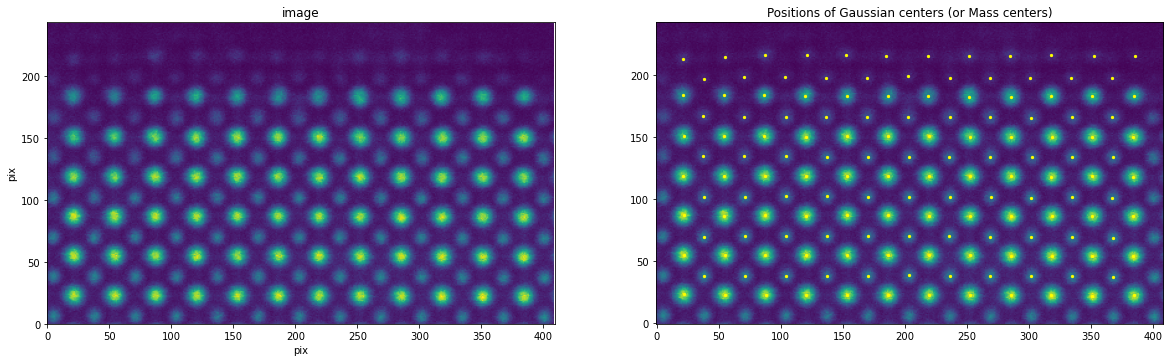

In [11]:
# Fit 2D gaussian
fit_method = "simple"

# Calculate atomic positions
peaks = set([])
for h in range(len(peaks_y)):
    px = peaks_x[h]
    py = peaks_y[h]
    for i in range(n_iter):
        if model == "CoM": cx,cy =   centroid(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))])
        if model == "Gaussian": cx,cy = gauss(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))], size_peak, FWHM)
        px = round(px-size_peak/2)+cx
        py = round(py-size_peak/2)+cy
    peaks.add((px, py))
peaks_x = [ x for x, y in peaks ]
peaks_y = [ y for x, y in peaks ]
print("Number of peaks = {0} ⇒ {1}".format(len(peaks_maximam[0]), len(peaks)))

# Make plots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
ax2.set_title("Positions of Gaussian centers (or Mass centers)")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
plt.show()

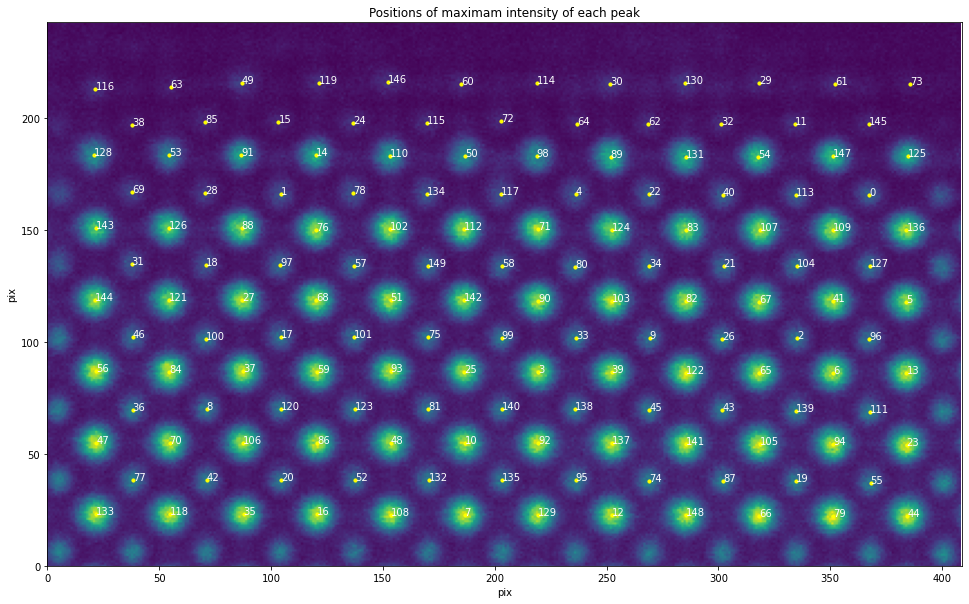

In [12]:
# Make plots
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(Z, origin="lower")
ax.scatter(peaks_x, peaks_y, s=10, c="yellow", marker="o")
for i in range(len(peaks_x)):
    ax.text(peaks_x[i], peaks_y[i], str(i), color="white", fontsize=10)
ax.set_title("Positions of maximam intensity of each peak")
ax.set_xlabel("pix")
ax.set_ylabel("pix")
ax.set_xlim(0, xdim)
ax.set_ylim(0, ydim)
plt.show()

## 5. Peak fit using 2D Gaussian with Bayesian inference

In [13]:
#Model(Uniform bachground)
fit_method = "bayes"

#Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)
peaks_y_bayes = np.zeros_like(peaks_y)
sd_x_bayes = np.zeros_like(peaks_x)
sd_y_bayes = np.zeros_like(peaks_y)
summary = []

for i in range(len(peaks)):
    print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
    patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
    with pm.Model() as model:
        xy = pm.Data('Coordinate', xy_coords)
        mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
        sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
        bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
        peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
        chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
        cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
        inv =  pm.math.matrix_inverse(cov)
        y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())
        
    #MCMC Sampling
    with model:
        trace = pm.sample(
            draws=6000,
            tune=3000,
            chains=3,
            return_inferencedata=True
        )

    summary.append(az.summary(trace))
    mean_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "mean"]
    sd_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "sd"]
    peaks_x[i] = mean_vars[0] + round(peaks_x[i]-size_peak/2)
    peaks_y[i] = mean_vars[1] + round(peaks_y[i]-size_peak/2)
    sd_x_bayes[i] = sd_vars[0]
    sd_y_bayes[i] = sd_vars[1]
    
    #clear_output(True)    #outputセルのクリア
    
    print(az.summary(trace))

Bayesian Inference of atomic position: 1/150


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 136 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 136 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.365  0.066   9.238    9.487      0.000    0.000   
Atom Position (μ)[1]      8.906  0.062   8.786    9.024      0.000    0.000   
Noise (σ)                 5.015  0.202   4.643    5.401      0.001    0.001   
Background Intensity     17.478  0.645  16.244   18.650      0.006    0.004   
Peak Intensity           62.865  1.117  60.721   64.937      0.008    0.005   
Cholesky Matrix[0]        3.782  0.089   3.615    3.949      0.001    0.001   
Cholesky Matrix[1]       -0.072  0.088  -0.239    0.095      0.001    0.001   
Cholesky Matrix[2]        3.609  0.086   3.449    3.768      0.001    0.001   
Covariance Matrix[0, 0]  14.311  0.672  13.066   15.591      0.006    0.004   
Covariance Matrix[0, 1]  -0.270  0.334  -0.904    0.360      0.002    0.002   
Covariance Matrix[1, 0]  -0.270  0.334  -0.904    0.360      0.002    0.002   
Covariance Matrix[1, 1]  13.046  0.619  11.905   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.336  0.071   9.200    9.469      0.001    0.000   
Atom Position (μ)[1]      8.984  0.082   8.832    9.144      0.001    0.000   
Noise (σ)                 4.837  0.191   4.488    5.205      0.001    0.001   
Background Intensity     15.381  0.745  13.988   16.771      0.008    0.006   
Peak Intensity           50.754  1.050  48.780   52.743      0.008    0.006   
Cholesky Matrix[0]        3.750  0.111   3.542    3.960      0.001    0.001   
Cholesky Matrix[1]        0.151  0.118  -0.063    0.379      0.001    0.001   
Cholesky Matrix[2]        4.311  0.124   4.073    4.542      0.001    0.001   
Covariance Matrix[0, 0]  14.076  0.836  12.546   15.680      0.009    0.006   
Covariance Matrix[0, 1]   0.568  0.444  -0.265    1.400      0.003    0.003   
Covariance Matrix[1, 0]   0.568  0.444  -0.265    1.400      0.003    0.003   
Covariance Matrix[1, 1]  18.634  1.073  16.635   20.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.031  0.056   8.922    9.134      0.000    0.000   
Atom Position (μ)[1]      8.673  0.062   8.554    8.787      0.000    0.000   
Noise (σ)                 5.766  0.231   5.341    6.209      0.002    0.001   
Background Intensity     22.336  0.720  21.007   23.708      0.006    0.004   
Peak Intensity           78.252  1.312  75.811   80.770      0.009    0.006   
Cholesky Matrix[0]        3.431  0.074   3.294    3.572      0.001    0.000   
Cholesky Matrix[1]       -0.022  0.087  -0.189    0.139      0.001    0.001   
Cholesky Matrix[2]        3.738  0.085   3.577    3.896      0.001    0.000   
Covariance Matrix[0, 0]  11.774  0.511  10.852   12.758      0.004    0.003   
Covariance Matrix[0, 1]  -0.075  0.299  -0.635    0.489      0.002    0.002   
Covariance Matrix[1, 0]  -0.075  0.299  -0.635    0.489      0.002    0.002   
Covariance Matrix[1, 1]  13.985  0.636  12.800   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 172 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 172 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.311  0.033    9.250    9.371      0.000    0.000   
Atom Position (μ)[1]       8.581  0.032    8.522    8.641      0.000    0.000   
Noise (σ)                  8.072  0.325    7.475    8.689      0.003    0.002   
Background Intensity      11.141  2.549    6.213   15.691      0.048    0.036   
Peak Intensity           215.743  2.204  211.601  219.780      0.035    0.025   
Cholesky Matrix[0]         5.133  0.081    4.985    5.286      0.001    0.001   
Cholesky Matrix[1]        -0.022  0.047   -0.114    0.064      0.000    0.000   
Cholesky Matrix[2]         5.103  0.078    4.963    5.255      0.001    0.001   
Covariance Matrix[0, 0]   26.357  0.829   24.784   27.877      0.014    0.010   
Covariance Matrix[0, 1]   -0.112  0.243   -0.567    0.347      0.003    0.002   
Covariance Matrix[1, 0]   -0.112  0.243   -0.567    0.347      0.003    0.002   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 140 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 140 seconds.
The acceptance probability does not match the target. It is 0.6762662284921195, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.147  0.078   8.995    9.291      0.001    0.000   
Atom Position (μ)[1]      9.200  0.089   9.034    9.365      0.001    0.001   
Noise (σ)                 5.466  0.218   5.061    5.872      0.002    0.001   
Background Intensity     17.702  0.832  16.135   19.268      0.010    0.007   
Peak Intensity           53.340  1.151  51.143   55.463      0.009    0.007   
Cholesky Matrix[0]        3.797  0.119   3.578    4.021      0.001    0.001   
Cholesky Matrix[1]        0.124  0.125  -0.107    0.361      0.001    0.001   
Cholesky Matrix[2]        4.232  0.128   3.995    4.475      0.001    0.001   
Covariance Matrix[0, 0]  14.435  0.904  12.799   16.171      0.010    0.007   
Covariance Matrix[0, 1]   0.473  0.476  -0.391    1.395      0.004    0.003   
Covariance Matrix[1, 0]   0.473  0.476  -0.391    1.395      0.004    0.003   
Covariance Matrix[1, 1]  17.956  1.091  15.968   20.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 152 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 152 seconds.
There were 540 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 540 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.721639577982909, but should be close to 0.8. Try to increase the number of tuning steps.
There were 651 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 651 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6925766268569482, but should be close to 0.8. Try to increase the number of tuning steps.
There were 649 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 64

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.008  0.036    8.939    9.075      0.001    0.001   
Atom Position (μ)[1]       9.139  0.036    9.074    9.205      0.001    0.001   
Noise (σ)                  8.734  0.340    8.133    9.412      0.008    0.006   
Background Intensity       1.834  1.398    0.000    4.409      0.095    0.081   
Peak Intensity           214.301  1.731  210.847  217.234      0.076    0.054   
Cholesky Matrix[0]         5.424  0.059    5.312    5.534      0.003    0.002   
Cholesky Matrix[1]        -0.018  0.054   -0.122    0.083      0.001    0.001   
Cholesky Matrix[2]         5.378  0.056    5.274    5.488      0.003    0.002   
Covariance Matrix[0, 0]   29.429  0.637   28.216   30.628      0.032    0.023   
Covariance Matrix[0, 1]   -0.099  0.290   -0.663    0.445      0.006    0.005   
Covariance Matrix[1, 0]   -0.099  0.290   -0.663    0.445      0.006    0.005   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 164 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 164 seconds.
There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1433 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1433 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5380555349308482, but should be close to 0.8. Try to increase the number of tuning steps.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates sl

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.270  0.034    9.208    9.334      0.001    0.001   
Atom Position (μ)[1]       9.372  0.033    9.310    9.433      0.001    0.001   
Noise (σ)                  8.376  0.328    7.757    8.986      0.009    0.006   
Background Intensity       3.850  2.195    0.012    7.654      0.328    0.271   
Peak Intensity           222.306  2.122  218.342  226.237      0.238    0.169   
Cholesky Matrix[0]         5.479  0.071    5.345    5.604      0.010    0.007   
Cholesky Matrix[1]         0.020  0.052   -0.078    0.116      0.002    0.002   
Cholesky Matrix[2]         5.376  0.069    5.242    5.495      0.009    0.007   
Covariance Matrix[0, 0]   30.028  0.773   28.562   31.394      0.108    0.077   
Covariance Matrix[0, 1]    0.110  0.282   -0.405    0.659      0.011    0.008   
Covariance Matrix[1, 0]    0.110  0.282   -0.405    0.659      0.011    0.008   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 182 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 182 seconds.
There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.537  0.031    8.479    8.596      0.000    0.000   
Atom Position (μ)[1]       8.846  0.031    8.788    8.903      0.000    0.000   
Noise (σ)                  8.269  0.335    7.665    8.923      0.006    0.004   
Background Intensity      10.270  2.826    4.956   15.361      0.092    0.074   
Peak Intensity           228.888  2.431  224.515  233.559      0.068    0.048   
Cholesky Matrix[0]         5.215  0.082    5.071    5.380      0.002    0.002   
Cholesky Matrix[1]        -0.073  0.045   -0.157    0.013      0.001    0.001   
Cholesky Matrix[2]         5.163  0.081    5.014    5.315      0.003    0.002   
Covariance Matrix[0, 0]   27.200  0.852   25.715   28.940      0.025    0.018   
Covariance Matrix[0, 1]   -0.381  0.237   -0.828    0.059      0.004    0.003   
Covariance Matrix[1, 0]   -0.381  0.237   -0.828    0.059      0.004    0.003   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.235  0.056   9.129    9.341      0.000    0.000   
Atom Position (μ)[1]      9.180  0.061   9.066    9.295      0.000    0.000   
Noise (σ)                 6.249  0.251   5.774    6.715      0.002    0.001   
Background Intensity     21.741  0.740  20.317   23.098      0.006    0.005   
Peak Intensity           86.293  1.399  83.675   88.896      0.010    0.007   
Cholesky Matrix[0]        3.425  0.073   3.292    3.563      0.001    0.000   
Cholesky Matrix[1]        0.105  0.085  -0.051    0.268      0.001    0.000   
Cholesky Matrix[2]        3.668  0.078   3.526    3.815      0.001    0.000   
Covariance Matrix[0, 0]  11.736  0.498  10.835   12.698      0.004    0.003   
Covariance Matrix[0, 1]   0.360  0.292  -0.180    0.914      0.002    0.002   
Covariance Matrix[1, 0]   0.360  0.292  -0.180    0.914      0.002    0.002   
Covariance Matrix[1, 1]  13.480  0.572  12.447   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 126 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 126 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.231  0.058   9.120    9.341      0.000    0.000   
Atom Position (μ)[1]      8.684  0.063   8.567    8.805      0.000    0.000   
Noise (σ)                 5.914  0.235   5.482    6.368      0.002    0.001   
Background Intensity     20.839  0.758  19.413   22.254      0.007    0.005   
Peak Intensity           78.404  1.316  75.864   80.825      0.009    0.006   
Cholesky Matrix[0]        3.513  0.079   3.368    3.665      0.001    0.000   
Cholesky Matrix[1]        0.125  0.087  -0.037    0.293      0.001    0.000   
Cholesky Matrix[2]        3.804  0.088   3.635    3.967      0.001    0.001   
Covariance Matrix[0, 0]  12.347  0.559  11.344   13.430      0.005    0.003   
Covariance Matrix[0, 1]   0.438  0.307  -0.154    1.009      0.002    0.002   
Covariance Matrix[1, 0]   0.438  0.307  -0.154    1.009      0.002    0.002   
Covariance Matrix[1, 1]  14.503  0.669  13.209   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.609  0.039    8.541    8.685      0.000    0.000   
Atom Position (μ)[1]       8.967  0.038    8.894    9.038      0.000    0.000   
Noise (σ)                  9.521  0.385    8.811   10.243      0.005    0.003   
Background Intensity      16.071  3.088   10.258   21.853      0.063    0.048   
Peak Intensity           212.406  2.687  207.557  217.590      0.047    0.033   
Cholesky Matrix[0]         5.156  0.096    4.977    5.336      0.002    0.001   
Cholesky Matrix[1]        -0.199  0.056   -0.302   -0.090      0.001    0.000   
Cholesky Matrix[2]         5.081  0.096    4.888    5.250      0.002    0.001   
Covariance Matrix[0, 0]   26.591  0.996   24.759   28.462      0.019    0.013   
Covariance Matrix[0, 1]   -1.027  0.291   -1.572   -0.474      0.003    0.002   
Covariance Matrix[1, 0]   -1.027  0.291   -1.572   -0.474      0.003    0.002   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 123 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 123 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.371  0.173   9.047    9.696      0.001    0.001   
Atom Position (μ)[1]      9.301  0.134   9.054    9.557      0.001    0.001   
Noise (σ)                 4.761  0.188   4.408    5.113      0.001    0.001   
Background Intensity     14.916  0.442  14.075   15.734      0.003    0.002   
Peak Intensity           25.274  1.178  23.082   27.498      0.008    0.006   
Cholesky Matrix[0]        3.625  0.189   3.268    3.982      0.001    0.001   
Cholesky Matrix[1]       -0.237  0.181  -0.568    0.117      0.001    0.001   
Cholesky Matrix[2]        2.787  0.144   2.522    3.066      0.001    0.001   
Covariance Matrix[0, 0]  13.174  1.380  10.578   15.735      0.010    0.007   
Covariance Matrix[0, 1]  -0.856  0.659  -2.127    0.355      0.004    0.004   
Covariance Matrix[1, 0]  -0.856  0.659  -2.127    0.355      0.004    0.004   
Covariance Matrix[1, 1]   7.877  0.803   6.402    9.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 159 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 159 seconds.
There were 923 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 923 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6439486746685134, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4673 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4673 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.04370466400641843, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2593 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.518  0.035    8.457    8.587      0.011    0.008   
Atom Position (μ)[1]       8.708  0.033    8.647    8.771      0.008    0.005   
Noise (σ)                  8.800  0.347    8.104    9.480      0.055    0.040   
Background Intensity       8.417  2.660    2.524   12.345      0.783    0.568   
Peak Intensity           223.115  2.481  218.795  228.230      0.668    0.483   
Cholesky Matrix[0]         5.428  0.076    5.317    5.592      0.019    0.013   
Cholesky Matrix[1]        -0.099  0.054   -0.197    0.007      0.016    0.011   
Cholesky Matrix[2]         5.357  0.078    5.220    5.515      0.022    0.016   
Covariance Matrix[0, 0]   29.466  0.826   28.273   31.267      0.203    0.146   
Covariance Matrix[0, 1]   -0.539  0.293   -1.074    0.038      0.085    0.061   
Covariance Matrix[1, 0]   -0.539  0.293   -1.074    0.038      0.085    0.061   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
There were 912 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 912 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.646561739887439, but should be close to 0.8. Try to increase the number of tuning steps.
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameter

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.067  0.035    9.003    9.135      0.001    0.001   
Atom Position (μ)[1]       9.255  0.033    9.195    9.317      0.001    0.001   
Noise (σ)                  8.960  0.350    8.312    9.618      0.009    0.006   
Background Intensity       4.325  2.568    0.041    8.583      0.264    0.230   
Peak Intensity           228.176  2.308  223.808  232.168      0.193    0.137   
Cholesky Matrix[0]         5.420  0.078    5.262    5.548      0.007    0.005   
Cholesky Matrix[1]         0.084  0.052   -0.019    0.181      0.003    0.002   
Cholesky Matrix[2]         5.304  0.076    5.163    5.442      0.006    0.005   
Covariance Matrix[0, 0]   29.379  0.844   27.687   30.780      0.073    0.052   
Covariance Matrix[0, 1]    0.456  0.282   -0.023    1.050      0.014    0.012   
Covariance Matrix[1, 0]    0.456  0.282   -0.023    1.050      0.014    0.012   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
There were 581 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 581 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6529763349066, but should be close to 0.8. Try to increase the number of tuning steps.
There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.678385326902654, but should be close to 0.8. Try to increase the number of tuning steps.
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 184 d

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.943  0.042    8.861    9.020      0.001    0.001   
Atom Position (μ)[1]       8.516  0.041    8.442    8.593      0.001    0.001   
Noise (σ)                  7.841  0.311    7.252    8.420      0.008    0.005   
Background Intensity       5.094  2.148    0.963    8.944      0.144    0.121   
Peak Intensity           156.146  1.923  152.449  159.709      0.090    0.063   
Cholesky Matrix[0]         4.930  0.098    4.752    5.120      0.006    0.004   
Cholesky Matrix[1]         0.201  0.062    0.088    0.320      0.002    0.001   
Cholesky Matrix[2]         4.892  0.094    4.704    5.054      0.006    0.004   
Covariance Matrix[0, 0]   24.313  0.961   22.423   26.060      0.059    0.041   
Covariance Matrix[0, 1]    0.990  0.305    0.439    1.586      0.009    0.006   
Covariance Matrix[1, 0]    0.990  0.305    0.439    1.586      0.009    0.006   
Covariance Matrix[1, 1]   23

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 102 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 102 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.303  0.162   9.001    9.611      0.001    0.001   
Atom Position (μ)[1]      9.354  0.145   9.081    9.623      0.001    0.001   
Noise (σ)                 3.582  0.143   3.316    3.846      0.001    0.001   
Background Intensity     12.989  0.321  12.354   13.561      0.002    0.002   
Peak Intensity           19.005  0.949  17.236   20.812      0.007    0.005   
Cholesky Matrix[0]        3.151  0.182   2.820    3.499      0.001    0.001   
Cholesky Matrix[1]        0.087  0.193  -0.278    0.448      0.001    0.001   
Cholesky Matrix[2]        2.794  0.159   2.503    3.093      0.001    0.001   
Covariance Matrix[0, 0]   9.960  1.150   7.833   12.121      0.008    0.006   
Covariance Matrix[0, 1]   0.279  0.613  -0.908    1.402      0.004    0.004   
Covariance Matrix[1, 0]   0.279  0.613  -0.908    1.402      0.004    0.004   
Covariance Matrix[1, 1]   7.876  0.900   6.276    9.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 155 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 155 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 302 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 302 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.717  0.031    8.657    8.775      0.000    0.000   
Atom Position (μ)[1]       8.951  0.032    8.889    9.011      0.000    0.000   
Noise (σ)                  8.373  0.332    7.743    8.982      0.005    0.003   
Background Intensity       8.146  2.744    3.006   13.262      0.073    0.057   
Peak Intensity           224.589  2.385  220.153  229.117      0.054    0.038   
Cholesky Matrix[0]         5.180  0.081    5.030    5.335      0.002    0.001   
Cholesky Matrix[1]        -0.002  0.048   -0.093    0.087      0.001    0.000   
Cholesky Matrix[2]         5.234  0.082    5.090    5.394      0.002    0.001   
Covariance Matrix[0, 0]   26.835  0.841   25.297   28.467      0.021    0.015   
Covariance Matrix[0, 1]   -0.009  0.247   -0.477    0.460      0.003    0.002   
Covariance Matrix[1, 0]   -0.009  0.247   -0.477    0.460      0.003    0.002   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 102 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 102 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.244  0.060   9.129    9.355      0.000    0.000   
Atom Position (μ)[1]      9.236  0.066   9.113    9.359      0.000    0.000   
Noise (σ)                 6.123  0.245   5.663    6.573      0.001    0.001   
Background Intensity     22.381  0.722  21.065   23.783      0.006    0.004   
Peak Intensity           78.456  1.406  75.761   81.037      0.009    0.006   
Cholesky Matrix[0]        3.347  0.078   3.203    3.497      0.001    0.000   
Cholesky Matrix[1]       -0.227  0.092  -0.400   -0.053      0.001    0.000   
Cholesky Matrix[2]        3.681  0.088   3.519    3.853      0.001    0.001   
Covariance Matrix[0, 0]  11.209  0.525  10.211   12.181      0.004    0.003   
Covariance Matrix[0, 1]  -0.761  0.310  -1.353   -0.187      0.002    0.001   
Covariance Matrix[1, 0]  -0.761  0.310  -1.353   -0.187      0.002    0.001   
Covariance Matrix[1, 1]  13.615  0.655  12.412   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 114 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 114 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.777  0.072   8.644    8.914      0.000    0.000   
Atom Position (μ)[1]      8.579  0.093   8.401    8.750      0.001    0.000   
Noise (σ)                 4.921  0.196   4.547    5.287      0.001    0.001   
Background Intensity     19.001  0.674  17.751   20.273      0.007    0.005   
Peak Intensity           49.036  1.083  47.101   51.193      0.007    0.005   
Cholesky Matrix[0]        3.421  0.101   3.232    3.610      0.001    0.001   
Cholesky Matrix[1]        0.138  0.131  -0.123    0.372      0.001    0.001   
Cholesky Matrix[2]        4.318  0.127   4.082    4.556      0.001    0.001   
Covariance Matrix[0, 0]  11.712  0.694  10.444   13.031      0.007    0.005   
Covariance Matrix[0, 1]   0.472  0.448  -0.411    1.287      0.003    0.003   
Covariance Matrix[1, 0]   0.472  0.448  -0.411    1.287      0.003    0.003   
Covariance Matrix[1, 1]  18.701  1.101  16.663   20.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 122 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 122 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.758  0.058   8.649    8.869      0.000    0.000   
Atom Position (μ)[1]      8.793  0.065   8.676    8.921      0.000    0.000   
Noise (σ)                 6.492  0.262   5.994    6.969      0.002    0.001   
Background Intensity     26.147  0.795  24.647   27.634      0.007    0.005   
Peak Intensity           85.547  1.498  82.846   88.440      0.010    0.007   
Cholesky Matrix[0]        3.362  0.078   3.217    3.506      0.001    0.000   
Cholesky Matrix[1]       -0.089  0.091  -0.255    0.086      0.001    0.001   
Cholesky Matrix[2]        3.767  0.084   3.617    3.931      0.001    0.000   
Covariance Matrix[0, 0]  11.309  0.523  10.348   12.293      0.004    0.003   
Covariance Matrix[0, 1]  -0.298  0.308  -0.883    0.264      0.002    0.002   
Covariance Matrix[1, 0]  -0.298  0.308  -0.883    0.264      0.002    0.002   
Covariance Matrix[1, 1]  14.210  0.631  13.068   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 124 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 124 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.600  0.058   8.491    8.710      0.000    0.000   
Atom Position (μ)[1]      9.163  0.062   9.047    9.279      0.000    0.000   
Noise (σ)                 6.276  0.250   5.821    6.754      0.002    0.001   
Background Intensity     21.120  0.770  19.682   22.549      0.007    0.005   
Peak Intensity           83.959  1.421  81.310   86.641      0.010    0.007   
Cholesky Matrix[0]        3.509  0.077   3.364    3.654      0.001    0.000   
Cholesky Matrix[1]        0.190  0.087   0.033    0.359      0.001    0.000   
Cholesky Matrix[2]        3.640  0.081   3.486    3.790      0.001    0.000   
Covariance Matrix[0, 0]  12.317  0.541  11.294   13.330      0.004    0.003   
Covariance Matrix[0, 1]   0.668  0.304   0.114    1.260      0.002    0.001   
Covariance Matrix[1, 0]   0.668  0.304   0.114    1.260      0.002    0.001   
Covariance Matrix[1, 1]  13.298  0.590  12.195   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.357  0.061   9.241    9.471      0.000    0.000   
Atom Position (μ)[1]      8.805  0.071   8.674    8.943      0.000    0.000   
Noise (σ)                 5.693  0.226   5.270    6.122      0.002    0.001   
Background Intensity     20.815  0.774  19.413   22.301      0.007    0.005   
Peak Intensity           70.343  1.251  67.939   72.660      0.008    0.006   
Cholesky Matrix[0]        3.534  0.083   3.378    3.689      0.001    0.001   
Cholesky Matrix[1]       -0.059  0.100  -0.250    0.127      0.001    0.001   
Cholesky Matrix[2]        4.095  0.101   3.906    4.288      0.001    0.001   
Covariance Matrix[0, 0]  12.497  0.584  11.391   13.586      0.005    0.004   
Covariance Matrix[0, 1]  -0.208  0.353  -0.880    0.452      0.002    0.002   
Covariance Matrix[1, 0]  -0.208  0.353  -0.880    0.452      0.002    0.002   
Covariance Matrix[1, 1]  16.793  0.826  15.261   18.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6258267445883281, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.800  0.066   8.677    8.922      0.001    0.000   
Atom Position (μ)[1]      9.081  0.077   8.941    9.230      0.001    0.000   
Noise (σ)                 5.319  0.211   4.925    5.713      0.002    0.001   
Background Intensity     16.906  0.807  15.332   18.341      0.010    0.007   
Peak Intensity           61.075  1.148  58.942   63.254      0.011    0.008   
Cholesky Matrix[0]        3.727  0.100   3.533    3.908      0.001    0.001   
Cholesky Matrix[1]       -0.176  0.109  -0.388    0.023      0.001    0.001   
Cholesky Matrix[2]        4.264  0.110   4.053    4.466      0.001    0.001   
Covariance Matrix[0, 0]  13.899  0.749  12.483   15.275      0.009    0.006   
Covariance Matrix[0, 1]  -0.655  0.405  -1.431    0.102      0.003    0.003   
Covariance Matrix[1, 0]  -0.655  0.405  -1.431    0.102      0.003    0.003   
Covariance Matrix[1, 1]  18.236  0.936  16.439   19.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5631448027938701, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.083  0.035    9.017    9.149      0.001    0.001   
Atom Position (μ)[1]       9.169  0.035    9.103    9.235      0.001    0.001   
Noise (σ)                  9.367  0.371    8.685   10.061      0.008    0.006   
Background Intensity      12.863  2.749    7.612   17.982      0.091    0.067   
Peak Intensity           228.954  2.450  224.323  233.626      0.071    0.050   
Cholesky Matrix[0]         5.053  0.082    4.892    5.201      0.003    0.002   
Cholesky Matrix[1]         0.017  0.050   -0.075    0.113      0.001    0.001   
Cholesky Matrix[2]         5.000  0.081    4.846    5.148      0.002    0.002   
Covariance Matrix[0, 0]   25.538  0.833   23.928   27.045      0.026    0.018   
Covariance Matrix[0, 1]    0.085  0.253   -0.384    0.566      0.005    0.004   
Covariance Matrix[1, 0]    0.085  0.253   -0.384    0.566      0.005    0.004   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.656  0.133   8.411    8.911      0.001    0.001   
Atom Position (μ)[1]      8.939  0.105   8.742    9.134      0.001    0.000   
Noise (σ)                 3.717  0.149   3.445    3.995      0.001    0.001   
Background Intensity     13.653  0.411  12.859   14.407      0.003    0.002   
Peak Intensity           25.428  0.868  23.769   27.009      0.005    0.004   
Cholesky Matrix[0]        3.846  0.161   3.552    4.156      0.001    0.001   
Cholesky Matrix[1]       -0.007  0.141  -0.264    0.267      0.001    0.001   
Cholesky Matrix[2]        3.070  0.132   2.822    3.322      0.001    0.001   
Covariance Matrix[0, 0]  14.814  1.244  12.522   17.162      0.009    0.007   
Covariance Matrix[0, 1]  -0.028  0.545  -1.045    1.001      0.003    0.004   
Covariance Matrix[1, 0]  -0.028  0.545  -1.045    1.001      0.003    0.004   
Covariance Matrix[1, 1]   9.460  0.816   7.894   10.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 178 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 178 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8899088858101278, but should be close to 0.8. Try to increase the number of tuning steps.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.401  0.032    9.341    9.463      0.000    0.000   
Atom Position (μ)[1]       8.854  0.032    8.795    8.913      0.000    0.000   
Noise (σ)                  7.874  0.313    7.295    8.469      0.002    0.002   
Background Intensity      12.594  2.351    8.225   16.977      0.034    0.024   
Peak Intensity           212.728  2.084  208.964  216.698      0.025    0.018   
Cholesky Matrix[0]         5.069  0.075    4.931    5.212      0.001    0.001   
Cholesky Matrix[1]        -0.174  0.046   -0.261   -0.088      0.000    0.000   
Cholesky Matrix[2]         5.042  0.074    4.907    5.186      0.001    0.001   
Covariance Matrix[0, 0]   25.702  0.764   24.317   27.168      0.010    0.007   
Covariance Matrix[0, 1]   -0.880  0.233   -1.315   -0.438      0.002    0.001   
Covariance Matrix[1, 0]   -0.880  0.233   -1.315   -0.438      0.002    0.001   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.690  0.060   8.576    8.802      0.000    0.000   
Atom Position (μ)[1]      9.252  0.063   9.132    9.372      0.000    0.000   
Noise (σ)                 6.989  0.276   6.484    7.516      0.002    0.001   
Background Intensity     23.910  0.753  22.465   25.289      0.006    0.004   
Peak Intensity           89.998  1.667  86.891   93.195      0.011    0.008   
Cholesky Matrix[0]        3.278  0.075   3.129    3.411      0.001    0.000   
Cholesky Matrix[1]        0.008  0.088  -0.156    0.173      0.001    0.001   
Cholesky Matrix[2]        3.456  0.080   3.308    3.606      0.001    0.000   
Covariance Matrix[0, 0]  10.752  0.491   9.789   11.633      0.004    0.003   
Covariance Matrix[0, 1]   0.028  0.288  -0.503    0.581      0.002    0.002   
Covariance Matrix[1, 0]   0.028  0.288  -0.503    0.581      0.002    0.002   
Covariance Matrix[1, 1]  11.960  0.552  10.955   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 146 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 146 seconds.
There were 1441 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1441 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5572596850058027, but should be close to 0.8. Try to increase the number of tuning steps.
There were 858 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 858 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6566322385166451, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1703 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There wer

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.157  0.034    9.087    9.214      0.002    0.001   
Atom Position (μ)[1]       8.864  0.032    8.805    8.925      0.001    0.001   
Noise (σ)                  8.492  0.357    7.876    9.181      0.022    0.015   
Background Intensity       2.400  1.665    0.001    5.367      0.166    0.132   
Peak Intensity           226.468  1.753  223.423  229.637      0.125    0.089   
Cholesky Matrix[0]         5.434  0.064    5.291    5.531      0.006    0.004   
Cholesky Matrix[1]        -0.312  0.050   -0.398   -0.214      0.003    0.002   
Cholesky Matrix[2]         5.367  0.054    5.263    5.463      0.004    0.003   
Covariance Matrix[0, 0]   29.531  0.695   27.995   30.597      0.067    0.047   
Covariance Matrix[0, 1]   -1.694  0.275   -2.161   -1.133      0.015    0.010   
Covariance Matrix[1, 0]   -1.694  0.275   -2.161   -1.133      0.015    0.010   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 129 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 129 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.565  0.104   8.375    8.763      0.001    0.000   
Atom Position (μ)[1]      9.478  0.117   9.262    9.704      0.001    0.001   
Noise (σ)                 4.652  0.187   4.309    5.005      0.001    0.001   
Background Intensity     16.267  0.509  15.286   17.196      0.004    0.003   
Peak Intensity           34.354  1.074  32.342   36.369      0.007    0.005   
Cholesky Matrix[0]        3.268  0.124   3.024    3.492      0.001    0.001   
Cholesky Matrix[1]        0.271  0.157  -0.021    0.565      0.001    0.001   
Cholesky Matrix[2]        3.663  0.141   3.398    3.929      0.001    0.001   
Covariance Matrix[0, 0]  10.694  0.816   9.143   12.194      0.006    0.004   
Covariance Matrix[0, 1]   0.887  0.516  -0.094    1.839      0.003    0.003   
Covariance Matrix[1, 0]   0.887  0.516  -0.094    1.839      0.003    0.003   
Covariance Matrix[1, 1]  13.533  1.040  11.569   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 151 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 151 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.108  0.150   8.825    9.388      0.001    0.001   
Atom Position (μ)[1]      8.821  0.114   8.605    9.033      0.001    0.001   
Noise (σ)                 3.449  0.138   3.192    3.705      0.001    0.001   
Background Intensity     10.454  0.622   9.233   11.562      0.008    0.006   
Peak Intensity           21.685  0.744  20.264   23.052      0.007    0.005   
Cholesky Matrix[0]        4.802  0.259   4.325    5.292      0.003    0.002   
Cholesky Matrix[1]        0.263  0.169  -0.047    0.587      0.001    0.001   
Cholesky Matrix[2]        3.721  0.198   3.353    4.096      0.002    0.002   
Covariance Matrix[0, 0]  23.128  2.500  18.448   27.713      0.029    0.021   
Covariance Matrix[0, 1]   1.269  0.825  -0.243    2.842      0.007    0.005   
Covariance Matrix[1, 0]   1.269  0.825  -0.243    2.842      0.007    0.005   
Covariance Matrix[1, 1]  13.982  1.493  11.266   16.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 163 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 163 seconds.
The acceptance probability does not match the target. It is 0.6969931685424905, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.551  0.114   8.336    8.763      0.001    0.001   
Atom Position (μ)[1]      9.230  0.083   9.071    9.384      0.001    0.001   
Noise (σ)                 3.526  0.140   3.263    3.788      0.001    0.001   
Background Intensity     10.984  0.732   9.595   12.346      0.009    0.006   
Peak Intensity           30.404  0.773  29.020   31.934      0.007    0.005   
Cholesky Matrix[0]        5.222  0.207   4.839    5.615      0.002    0.002   
Cholesky Matrix[1]        0.147  0.120  -0.080    0.369      0.001    0.001   
Cholesky Matrix[2]        3.918  0.161   3.603    4.211      0.002    0.001   
Covariance Matrix[0, 0]  27.312  2.166  23.406   31.514      0.024    0.017   
Covariance Matrix[0, 1]   0.770  0.628  -0.421    1.933      0.005    0.004   
Covariance Matrix[1, 0]   0.770  0.628  -0.421    1.933      0.005    0.004   
Covariance Matrix[1, 1]  15.411  1.266  12.986   17.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 139 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 139 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.698  0.076   8.551    8.840      0.000    0.000   
Atom Position (μ)[1]      9.059  0.094   8.883    9.235      0.001    0.000   
Noise (σ)                 5.419  0.217   5.018    5.827      0.001    0.001   
Background Intensity     18.937  0.727  17.557   20.269      0.007    0.005   
Peak Intensity           51.865  1.181  49.598   54.064      0.007    0.005   
Cholesky Matrix[0]        3.478  0.109   3.279    3.686      0.001    0.001   
Cholesky Matrix[1]       -0.090  0.131  -0.342    0.151      0.001    0.001   
Cholesky Matrix[2]        4.159  0.123   3.933    4.394      0.001    0.001   
Covariance Matrix[0, 0]  12.106  0.757  10.751   13.590      0.007    0.005   
Covariance Matrix[0, 1]  -0.313  0.456  -1.172    0.548      0.003    0.003   
Covariance Matrix[1, 0]  -0.313  0.456  -1.172    0.548      0.003    0.003   
Covariance Matrix[1, 1]  17.338  1.025  15.430   19.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.367  0.156   9.087    9.675      0.001    0.001   
Atom Position (μ)[1]      8.523  0.152   8.236    8.809      0.001    0.001   
Noise (σ)                 4.316  0.174   3.994    4.639      0.001    0.001   
Background Intensity     14.241  0.416  13.482   15.049      0.003    0.002   
Peak Intensity           22.586  1.081  20.588   24.667      0.007    0.005   
Cholesky Matrix[0]        3.219  0.193   2.863    3.586      0.001    0.001   
Cholesky Matrix[1]        0.095  0.202  -0.300    0.461      0.001    0.001   
Cholesky Matrix[2]        3.054  0.160   2.751    3.350      0.001    0.001   
Covariance Matrix[0, 0]  10.396  1.254   8.091   12.751      0.009    0.007   
Covariance Matrix[0, 1]   0.312  0.656  -0.946    1.523      0.004    0.005   
Covariance Matrix[1, 0]   0.312  0.656  -0.946    1.523      0.004    0.005   
Covariance Matrix[1, 1]   9.400  0.982   7.604   11.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.393  0.058   9.284    9.501      0.000    0.000   
Atom Position (μ)[1]      8.815  0.063   8.694    8.930      0.000    0.000   
Noise (σ)                 6.419  0.258   5.935    6.907      0.002    0.001   
Background Intensity     22.121  0.794  20.674   23.659      0.007    0.005   
Peak Intensity           84.501  1.441  81.680   87.091      0.009    0.006   
Cholesky Matrix[0]        3.494  0.077   3.346    3.638      0.001    0.000   
Cholesky Matrix[1]        0.136  0.089  -0.030    0.302      0.001    0.000   
Cholesky Matrix[2]        3.721  0.085   3.561    3.882      0.001    0.000   
Covariance Matrix[0, 0]  12.211  0.541  11.194   13.232      0.004    0.003   
Covariance Matrix[0, 1]   0.477  0.310  -0.104    1.057      0.002    0.002   
Covariance Matrix[1, 0]   0.477  0.310  -0.104    1.057      0.002    0.002   
Covariance Matrix[1, 1]  13.883  0.636  12.681   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 129 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 129 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.916  0.063   8.798    9.036      0.000    0.000   
Atom Position (μ)[1]      9.054  0.080   8.907    9.209      0.001    0.000   
Noise (σ)                 6.201  0.247   5.748    6.673      0.002    0.001   
Background Intensity     21.688  0.800  20.179   23.168      0.007    0.005   
Peak Intensity           70.985  1.386  68.396   73.638      0.009    0.006   
Cholesky Matrix[0]        3.354  0.089   3.187    3.518      0.001    0.001   
Cholesky Matrix[1]        0.174  0.111  -0.039    0.379      0.001    0.001   
Cholesky Matrix[2]        4.100  0.102   3.909    4.294      0.001    0.001   
Covariance Matrix[0, 0]  11.255  0.597  10.157   12.373      0.005    0.004   
Covariance Matrix[0, 1]   0.586  0.375  -0.137    1.280      0.002    0.002   
Covariance Matrix[1, 0]   0.586  0.375  -0.137    1.280      0.002    0.002   
Covariance Matrix[1, 1]  16.859  0.840  15.306   18.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6773013674013034, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.765  0.029    8.711    8.823      0.000    0.000   
Atom Position (μ)[1]       9.019  0.029    8.966    9.073      0.000    0.000   
Noise (σ)                  7.705  0.307    7.130    8.272      0.004    0.003   
Background Intensity      10.429  2.347    5.844   14.509      0.067    0.052   
Peak Intensity           224.179  2.100  220.217  228.119      0.057    0.040   
Cholesky Matrix[0]         5.123  0.071    4.990    5.256      0.002    0.001   
Cholesky Matrix[1]        -0.015  0.043   -0.096    0.067      0.001    0.001   
Cholesky Matrix[2]         4.982  0.068    4.857    5.107      0.002    0.001   
Covariance Matrix[0, 0]   26.249  0.726   24.872   27.592      0.019    0.013   
Covariance Matrix[0, 1]   -0.075  0.221   -0.490    0.345      0.004    0.003   
Covariance Matrix[1, 0]   -0.075  0.221   -0.490    0.345      0.004    0.003   
Covariance Matrix[1, 1]   24

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 123 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 123 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.104  0.062   8.985    9.220      0.000    0.000   
Atom Position (μ)[1]      8.825  0.072   8.695    8.966      0.000    0.000   
Noise (σ)                 7.104  0.282   6.592    7.639      0.002    0.001   
Background Intensity     25.438  0.812  23.890   26.944      0.007    0.005   
Peak Intensity           85.635  1.642  82.576   88.749      0.010    0.007   
Cholesky Matrix[0]        3.242  0.081   3.094    3.398      0.001    0.000   
Cholesky Matrix[1]        0.335  0.103   0.142    0.529      0.001    0.000   
Cholesky Matrix[2]        3.681  0.090   3.515    3.849      0.001    0.001   
Covariance Matrix[0, 0]  10.515  0.523   9.574   11.544      0.004    0.003   
Covariance Matrix[0, 1]   1.085  0.337   0.435    1.708      0.002    0.002   
Covariance Matrix[1, 0]   1.085  0.337   0.435    1.708      0.002    0.002   
Covariance Matrix[1, 1]  13.680  0.669  12.443   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6614101330648755, but should be close to 0.8. Try to increase the number of tuning steps.
There were 712 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 712 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.655121899387451, bu

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.488  0.030    9.435    9.549      0.001    0.001   
Atom Position (μ)[1]       8.892  0.031    8.835    8.949      0.001    0.001   
Noise (σ)                  8.025  0.320    7.438    8.630      0.009    0.006   
Background Intensity       7.891  2.779    2.900   13.433      0.164    0.134   
Peak Intensity           227.204  2.399  222.611  231.631      0.134    0.095   
Cholesky Matrix[0]         5.164  0.081    5.013    5.318      0.004    0.003   
Cholesky Matrix[1]         0.125  0.044    0.042    0.208      0.001    0.001   
Cholesky Matrix[2]         5.199  0.079    5.055    5.356      0.004    0.003   
Covariance Matrix[0, 0]   26.670  0.840   25.128   28.285      0.045    0.032   
Covariance Matrix[0, 1]    0.645  0.230    0.223    1.082      0.006    0.004   
Covariance Matrix[1, 0]    0.645  0.230    0.223    1.082      0.006    0.004   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 188 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 188 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.974  0.244   8.497    9.416      0.002    0.001   
Atom Position (μ)[1]      9.049  0.220   8.625    9.458      0.002    0.001   
Noise (σ)                 4.248  0.168   3.942    4.566      0.001    0.001   
Background Intensity     13.125  0.318  12.525   13.717      0.002    0.002   
Peak Intensity           15.223  1.249  12.842   17.516      0.009    0.007   
Cholesky Matrix[0]        2.701  0.239   2.267    3.159      0.002    0.001   
Cholesky Matrix[1]       -0.233  0.272  -0.748    0.269      0.002    0.002   
Cholesky Matrix[2]        2.426  0.197   2.069    2.806      0.001    0.001   
Covariance Matrix[0, 0]   7.350  1.302   5.025    9.845      0.010    0.007   
Covariance Matrix[0, 1]  -0.627  0.741  -2.066    0.718      0.005    0.005   
Covariance Matrix[1, 0]  -0.627  0.741  -2.066    0.718      0.005    0.005   
Covariance Matrix[1, 1]   6.054  0.974   4.307    7.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 191 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 191 seconds.
There were 646 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 646 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6455155844233204, but should be close to 0.8. Try to increase the number of tuning steps.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 774 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 774 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6298298358465921, b

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.240  0.034    9.179    9.305      0.001    0.001   
Atom Position (μ)[1]       9.478  0.035    9.414    9.544      0.002    0.001   
Noise (σ)                  8.340  0.333    7.757    8.974      0.011    0.008   
Background Intensity       6.839  2.440    2.050   11.142      0.136    0.108   
Peak Intensity           218.251  2.164  214.324  222.421      0.094    0.066   
Cholesky Matrix[0]         5.388  0.079    5.238    5.533      0.004    0.003   
Cholesky Matrix[1]         0.058  0.048   -0.039    0.144      0.001    0.001   
Cholesky Matrix[2]         5.155  0.076    5.017    5.301      0.004    0.003   
Covariance Matrix[0, 0]   29.033  0.853   27.437   30.616      0.043    0.030   
Covariance Matrix[0, 1]    0.314  0.262   -0.206    0.781      0.007    0.005   
Covariance Matrix[1, 0]    0.314  0.262   -0.206    0.781      0.007    0.005   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 150 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 150 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.024  0.070   8.896    9.158      0.000    0.000   
Atom Position (μ)[1]      8.561  0.080   8.412    8.713      0.001    0.000   
Noise (σ)                 5.407  0.217   4.993    5.800      0.002    0.001   
Background Intensity     18.162  0.834  16.598   19.737      0.010    0.007   
Peak Intensity           58.631  1.174  56.430   60.832      0.009    0.007   
Cholesky Matrix[0]        3.762  0.110   3.551    3.963      0.001    0.001   
Cholesky Matrix[1]        0.061  0.111  -0.149    0.260      0.001    0.001   
Cholesky Matrix[2]        4.149  0.116   3.935    4.367      0.001    0.001   
Covariance Matrix[0, 0]  14.167  0.829  12.611   15.704      0.009    0.006   
Covariance Matrix[0, 1]   0.229  0.418  -0.540    0.999      0.003    0.003   
Covariance Matrix[1, 0]   0.229  0.418  -0.540    0.999      0.003    0.003   
Covariance Matrix[1, 1]  17.243  0.963  15.449   19.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
There were 1214 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.607272566310702, but should be close to 0.8. Try to increase the number of tuning steps.
There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.131  0.035    9.063    9.195      0.001    0.001   
Atom Position (μ)[1]       9.277  0.032    9.216    9.334      0.001    0.001   
Noise (σ)                  8.266  0.323    7.668    8.877      0.009    0.006   
Background Intensity       1.731  1.290    0.000    4.114      0.076    0.065   
Peak Intensity           221.432  1.636  218.137  224.267      0.060    0.043   
Cholesky Matrix[0]         5.576  0.052    5.469    5.662      0.002    0.001   
Cholesky Matrix[1]        -0.222  0.047   -0.305   -0.131      0.001    0.001   
Cholesky Matrix[2]         5.246  0.052    5.143    5.335      0.003    0.002   
Covariance Matrix[0, 0]   31.092  0.579   29.915   32.058      0.023    0.016   
Covariance Matrix[0, 1]   -1.239  0.261   -1.708   -0.734      0.006    0.004   
Covariance Matrix[1, 0]   -1.239  0.261   -1.708   -0.734      0.006    0.004   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 133 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 133 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.386  0.054   9.284    9.488      0.000    0.000   
Atom Position (μ)[1]      9.133  0.060   9.019    9.245      0.000    0.000   
Noise (σ)                 6.277  0.250   5.779    6.724      0.002    0.001   
Background Intensity     23.049  0.759  21.690   24.546      0.006    0.004   
Peak Intensity           88.579  1.405  85.982   91.272      0.010    0.007   
Cholesky Matrix[0]        3.390  0.072   3.255    3.525      0.001    0.000   
Cholesky Matrix[1]        0.182  0.085   0.027    0.346      0.001    0.000   
Cholesky Matrix[2]        3.843  0.079   3.691    3.983      0.001    0.000   
Covariance Matrix[0, 0]  11.495  0.485  10.597   12.428      0.004    0.003   
Covariance Matrix[0, 1]   0.618  0.288   0.064    1.157      0.002    0.001   
Covariance Matrix[1, 0]   0.618  0.288   0.064    1.157      0.002    0.001   
Covariance Matrix[1, 1]  14.815  0.607  13.668   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 139 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 139 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.802  0.055   8.698    8.908      0.000    0.000   
Atom Position (μ)[1]      8.672  0.059   8.563    8.783      0.000    0.000   
Noise (σ)                 5.947  0.237   5.493    6.381      0.001    0.001   
Background Intensity     27.228  0.676  25.998   28.521      0.005    0.004   
Peak Intensity           83.535  1.381  80.964   86.176      0.009    0.006   
Cholesky Matrix[0]        3.306  0.070   3.175    3.439      0.001    0.000   
Cholesky Matrix[1]        0.070  0.083  -0.087    0.225      0.001    0.001   
Cholesky Matrix[2]        3.543  0.076   3.399    3.683      0.001    0.000   
Covariance Matrix[0, 0]  10.937  0.465  10.079   11.824      0.004    0.003   
Covariance Matrix[0, 1]   0.231  0.276  -0.290    0.743      0.002    0.002   
Covariance Matrix[1, 0]   0.231  0.276  -0.290    0.743      0.002    0.002   
Covariance Matrix[1, 1]  12.573  0.538  11.563   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 163 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 163 seconds.
There were 2733 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2733 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33217681402478894, but should be close to 0.8. Try to increase the number of tuning steps.
There were 986 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 986 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6138401743411812, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1338 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.507  0.035    8.442    8.571      0.003    0.002   
Atom Position (μ)[1]       9.348  0.035    9.285    9.415      0.003    0.002   
Noise (σ)                  9.130  0.367    8.430    9.789      0.023    0.016   
Background Intensity       4.308  2.399    0.305    8.331      0.392    0.309   
Peak Intensity           232.200  2.302  228.091  236.943      0.221    0.156   
Cholesky Matrix[0]         5.476  0.072    5.325    5.592      0.013    0.010   
Cholesky Matrix[1]        -0.045  0.057   -0.154    0.055      0.007    0.005   
Cholesky Matrix[2]         5.368  0.074    5.227    5.493      0.011    0.008   
Covariance Matrix[0, 0]   29.990  0.786   28.356   31.270      0.146    0.104   
Covariance Matrix[0, 1]   -0.247  0.311   -0.786    0.354      0.038    0.027   
Covariance Matrix[1, 0]   -0.247  0.311   -0.786    0.354      0.038    0.027   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.011  0.054   8.914    9.115      0.000    0.000   
Atom Position (μ)[1]      8.650  0.059   8.534    8.758      0.000    0.000   
Noise (σ)                 6.050  0.244   5.607    6.518      0.002    0.001   
Background Intensity     25.571  0.693  24.276   26.886      0.006    0.004   
Peak Intensity           85.576  1.414  82.948   88.293      0.010    0.007   
Cholesky Matrix[0]        3.291  0.070   3.163    3.428      0.001    0.000   
Cholesky Matrix[1]       -0.283  0.084  -0.437   -0.121      0.001    0.000   
Cholesky Matrix[2]        3.582  0.076   3.441    3.725      0.001    0.000   
Covariance Matrix[0, 0]  10.833  0.461   9.972   11.714      0.004    0.003   
Covariance Matrix[0, 1]  -0.931  0.278  -1.462   -0.418      0.002    0.001   
Covariance Matrix[1, 0]  -0.931  0.278  -1.462   -0.418      0.002    0.001   
Covariance Matrix[1, 1]  12.923  0.548  11.898   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 139 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 139 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.253  0.067   9.122    9.373      0.000    0.000   
Atom Position (μ)[1]      9.096  0.076   8.957    9.242      0.000    0.000   
Noise (σ)                 5.996  0.240   5.544    6.444      0.002    0.001   
Background Intensity     23.638  0.701  22.320   24.953      0.006    0.004   
Peak Intensity           68.340  1.375  65.727   70.902      0.009    0.007   
Cholesky Matrix[0]        3.331  0.085   3.172    3.491      0.001    0.000   
Cholesky Matrix[1]        0.111  0.105  -0.082    0.312      0.001    0.001   
Cholesky Matrix[2]        3.785  0.096   3.608    3.970      0.001    0.001   
Covariance Matrix[0, 0]  11.102  0.566  10.064   12.188      0.005    0.003   
Covariance Matrix[0, 1]   0.371  0.352  -0.292    1.022      0.002    0.002   
Covariance Matrix[1, 0]   0.371  0.352  -0.292    1.022      0.002    0.002   
Covariance Matrix[1, 1]  14.361  0.732  13.036   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1692 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1692 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4817568122594076, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9122780948501338, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimate

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.813  0.033    8.752    8.875      0.001    0.001   
Atom Position (μ)[1]       9.110  0.034    9.045    9.172      0.001    0.001   
Noise (σ)                  8.929  0.354    8.256    9.589      0.015    0.011   
Background Intensity       9.395  3.144    3.779   15.429      0.351    0.296   
Peak Intensity           228.914  2.663  224.037  234.015      0.228    0.161   
Cholesky Matrix[0]         5.192  0.092    5.025    5.372      0.010    0.007   
Cholesky Matrix[1]        -0.053  0.049   -0.144    0.041      0.001    0.001   
Cholesky Matrix[2]         5.192  0.089    5.008    5.346      0.010    0.007   
Covariance Matrix[0, 0]   26.964  0.954   25.190   28.789      0.098    0.070   
Covariance Matrix[0, 1]   -0.276  0.255   -0.751    0.211      0.007    0.005   
Covariance Matrix[1, 0]   -0.276  0.255   -0.751    0.211      0.007    0.005   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 200 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 200 seconds.
There were 1617 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1617 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5059398264973859, but should be close to 0.8. Try to increase the number of tuning steps.
There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some paramete

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.575  0.035    8.509    8.643      0.002    0.001   
Atom Position (μ)[1]       8.985  0.035    8.922    9.051      0.002    0.002   
Noise (σ)                  8.627  0.338    7.996    9.272      0.012    0.008   
Background Intensity       6.707  2.868    1.827   12.739      0.344    0.274   
Peak Intensity           214.566  2.488  210.037  219.222      0.271    0.192   
Cholesky Matrix[0]         5.354  0.094    5.185    5.544      0.011    0.007   
Cholesky Matrix[1]        -0.157  0.056   -0.264   -0.056      0.004    0.003   
Cholesky Matrix[2]         5.342  0.085    5.181    5.494      0.008    0.006   
Covariance Matrix[0, 0]   28.671  1.006   26.814   30.667      0.111    0.079   
Covariance Matrix[0, 1]   -0.841  0.297   -1.375   -0.274      0.019    0.015   
Covariance Matrix[1, 0]   -0.841  0.297   -1.375   -0.274      0.019    0.015   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.045  0.102   8.853    9.235      0.001    0.001   
Atom Position (μ)[1]      9.030  0.083   8.880    9.195      0.001    0.000   
Noise (σ)                 4.214  0.168   3.914    4.540      0.001    0.001   
Background Intensity     11.158  0.790   9.643   12.631      0.009    0.006   
Peak Intensity           37.669  0.910  35.962   39.393      0.007    0.005   
Cholesky Matrix[0]        4.586  0.168   4.267    4.900      0.002    0.001   
Cholesky Matrix[1]        0.085  0.117  -0.130    0.306      0.001    0.001   
Cholesky Matrix[2]        3.824  0.159   3.528    4.127      0.002    0.001   
Covariance Matrix[0, 0]  21.056  1.549  18.116   23.911      0.016    0.011   
Covariance Matrix[0, 1]   0.387  0.535  -0.601    1.401      0.004    0.003   
Covariance Matrix[1, 0]   0.387  0.535  -0.601    1.401      0.004    0.003   
Covariance Matrix[1, 1]  14.665  1.219  12.425   17.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 195 seconds.
There were 503 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 503 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6486693914808052, but should be close to 0.8. Try to increase the number of tuning steps.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.783  0.047    8.700    8.877      0.001    0.001   
Atom Position (μ)[1]       9.347  0.050    9.255    9.444      0.001    0.001   
Noise (σ)                  6.590  0.268    6.107    7.098      0.005    0.004   
Background Intensity       6.476  2.108    2.402   10.507      0.100    0.085   
Peak Intensity           120.541  1.844  117.220  124.200      0.073    0.051   
Cholesky Matrix[0]         5.005  0.114    4.783    5.217      0.005    0.004   
Cholesky Matrix[1]         0.516  0.073    0.377    0.656      0.002    0.001   
Cholesky Matrix[2]         5.356  0.120    5.119    5.576      0.005    0.004   
Covariance Matrix[0, 0]   25.066  1.146   22.870   27.207      0.049    0.035   
Covariance Matrix[0, 1]    2.580  0.371    1.891    3.296      0.008    0.005   
Covariance Matrix[1, 0]    2.580  0.371    1.891    3.296      0.008    0.005   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
There were 1132 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5908202652547138, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1042 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1042 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5750538732792297, but should be close to 0.8. Try to increase the number of tuning steps.
There were 477 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.436  0.036    9.371    9.505      0.002    0.001   
Atom Position (μ)[1]       8.708  0.034    8.646    8.773      0.001    0.001   
Noise (σ)                  8.958  0.345    8.350    9.666      0.013    0.009   
Background Intensity       6.293  3.090    0.476   12.603      0.619    0.549   
Peak Intensity           221.392  2.504  217.245  226.662      0.323    0.230   
Cholesky Matrix[0]         5.357  0.100    5.153    5.541      0.019    0.014   
Cholesky Matrix[1]        -0.059  0.049   -0.153    0.031      0.002    0.002   
Cholesky Matrix[2]         5.210  0.097    5.004    5.381      0.019    0.014   
Covariance Matrix[0, 0]   28.709  1.064   26.550   30.707      0.203    0.145   
Covariance Matrix[0, 1]   -0.316  0.261   -0.804    0.181      0.011    0.008   
Covariance Matrix[1, 0]   -0.316  0.261   -0.804    0.181      0.011    0.008   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 128 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 128 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.498  0.062   9.382    9.614      0.000    0.000   
Atom Position (μ)[1]      9.387  0.073   9.253    9.526      0.000    0.000   
Noise (σ)                 6.272  0.252   5.811    6.759      0.002    0.001   
Background Intensity     22.801  0.729  21.359   24.087      0.006    0.004   
Peak Intensity           75.682  1.439  72.917   78.376      0.009    0.006   
Cholesky Matrix[0]        3.279  0.080   3.132    3.431      0.001    0.000   
Cholesky Matrix[1]       -0.098  0.101  -0.291    0.091      0.001    0.001   
Cholesky Matrix[2]        3.803  0.093   3.629    3.980      0.001    0.001   
Covariance Matrix[0, 0]  10.756  0.524   9.757   11.720      0.004    0.003   
Covariance Matrix[0, 1]  -0.321  0.333  -0.933    0.326      0.002    0.002   
Covariance Matrix[1, 0]  -0.321  0.333  -0.933    0.326      0.002    0.002   
Covariance Matrix[1, 1]  14.493  0.712  13.177   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 155 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 155 seconds.


                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.320  0.046   9.234    9.409      0.000    0.000   
Atom Position (μ)[1]       8.622  0.051   8.529    8.720      0.000    0.000   
Noise (σ)                  6.035  0.239   5.579    6.475      0.002    0.001   
Background Intensity      11.590  1.335   9.000   14.049      0.015    0.010   
Peak Intensity           101.738  1.340  99.237  104.288      0.011    0.008   
Cholesky Matrix[0]         4.360  0.096   4.177    4.541      0.001    0.001   
Cholesky Matrix[1]        -0.154  0.074  -0.292   -0.017      0.001    0.000   
Cholesky Matrix[2]         4.706  0.095   4.521    4.878      0.001    0.001   
Covariance Matrix[0, 0]   19.015  0.840  17.446   20.617      0.009    0.006   
Covariance Matrix[0, 1]   -0.671  0.322  -1.275   -0.072      0.003    0.002   
Covariance Matrix[1, 0]   -0.671  0.322  -1.275   -0.072      0.003    0.002   
Covariance Matrix[1, 1]   22.183  0.893 

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
There were 1051 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1051 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5920407133168661, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1509 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1509 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5134683665653449, but should be close to 0.8. Try to increase the number of tuning steps.
There were 913 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.618  0.033    8.556    8.679      0.001    0.001   
Atom Position (μ)[1]       8.883  0.033    8.824    8.945      0.002    0.001   
Noise (σ)                  6.979  0.267    6.504    7.505      0.011    0.008   
Background Intensity       2.786  1.618    0.005    5.474      0.165    0.139   
Peak Intensity           177.894  1.568  174.934  180.610      0.123    0.087   
Cholesky Matrix[0]         5.008  0.065    4.887    5.116      0.005    0.004   
Cholesky Matrix[1]        -0.015  0.050   -0.101    0.085      0.002    0.002   
Cholesky Matrix[2]         4.986  0.064    4.868    5.097      0.005    0.004   
Covariance Matrix[0, 0]   25.086  0.647   23.829   26.127      0.054    0.038   
Covariance Matrix[0, 1]   -0.073  0.249   -0.503    0.424      0.012    0.009   
Covariance Matrix[1, 0]   -0.073  0.249   -0.503    0.424      0.012    0.009   
Covariance Matrix[1, 1]   24

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.991  0.064   8.867    9.111      0.000    0.000   
Atom Position (μ)[1]      9.186  0.072   9.050    9.318      0.000    0.000   
Noise (σ)                 7.156  0.287   6.627    7.706      0.002    0.001   
Background Intensity     25.229  0.804  23.780   26.787      0.006    0.005   
Peak Intensity           84.405  1.654  81.237   87.423      0.010    0.007   
Cholesky Matrix[0]        3.310  0.081   3.158    3.464      0.001    0.000   
Cholesky Matrix[1]        0.122  0.099  -0.065    0.309      0.001    0.001   
Cholesky Matrix[2]        3.628  0.092   3.454    3.799      0.001    0.000   
Covariance Matrix[0, 0]  10.960  0.538   9.974   11.998      0.004    0.003   
Covariance Matrix[0, 1]   0.405  0.330  -0.223    1.021      0.002    0.002   
Covariance Matrix[1, 0]   0.405  0.330  -0.223    1.021      0.002    0.002   
Covariance Matrix[1, 1]  13.195  0.666  11.916   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 164 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 164 seconds.
There were 558 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 558 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6890894325084453, but should be close to 0.8. Try to increase the number of tuning steps.
There were 613 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 613 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6763804590393118, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1205 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.705  0.032    8.645    8.765      0.002    0.001   
Atom Position (μ)[1]       8.920  0.032    8.859    8.980      0.001    0.001   
Noise (σ)                  8.648  0.358    7.987    9.285      0.018    0.013   
Background Intensity       4.433  2.237    0.039    7.980      0.244    0.201   
Peak Intensity           236.837  2.088  233.015  240.627      0.183    0.130   
Cholesky Matrix[0]         5.254  0.065    5.137    5.372      0.006    0.004   
Cholesky Matrix[1]         0.085  0.046    0.002    0.175      0.002    0.001   
Cholesky Matrix[2]         5.313  0.067    5.190    5.440      0.007    0.005   
Covariance Matrix[0, 0]   27.611  0.683   26.392   28.864      0.063    0.044   
Covariance Matrix[0, 1]    0.448  0.243   -0.014    0.895      0.009    0.007   
Covariance Matrix[1, 0]    0.448  0.243   -0.014    0.895      0.009    0.007   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 136 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 136 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.126  0.066   9.002    9.251      0.000    0.000   
Atom Position (μ)[1]      8.902  0.068   8.772    9.028      0.000    0.000   
Noise (σ)                 6.095  0.243   5.658    6.571      0.001    0.001   
Background Intensity     22.261  0.778  20.798   23.710      0.007    0.005   
Peak Intensity           72.626  1.355  70.050   75.151      0.010    0.007   
Cholesky Matrix[0]        3.586  0.089   3.418    3.753      0.001    0.001   
Cholesky Matrix[1]       -0.006  0.095  -0.184    0.170      0.001    0.001   
Cholesky Matrix[2]        3.677  0.093   3.500    3.853      0.001    0.001   
Covariance Matrix[0, 0]  12.868  0.638  11.652   14.053      0.005    0.004   
Covariance Matrix[0, 1]  -0.021  0.340  -0.652    0.622      0.002    0.003   
Covariance Matrix[1, 0]  -0.021  0.340  -0.652    0.622      0.002    0.003   
Covariance Matrix[1, 1]  13.538  0.688  12.256   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
The acceptance probability does not match the target. It is 0.8819658069268582, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.236  0.062   9.121    9.355      0.000    0.000   
Atom Position (μ)[1]      8.832  0.068   8.704    8.962      0.000    0.000   
Noise (σ)                 5.654  0.225   5.233    6.073      0.001    0.001   
Background Intensity     19.277  0.752  17.845   20.680      0.008    0.005   
Peak Intensity           70.223  1.263  67.899   72.701      0.008    0.006   
Cholesky Matrix[0]        3.539  0.086   3.379    3.701      0.001    0.001   
Cholesky Matrix[1]        0.306  0.095   0.121    0.479      0.001    0.000   
Cholesky Matrix[2]        3.906  0.094   3.726    4.083      0.001    0.001   
Covariance Matrix[0, 0]  12.535  0.610  11.419   13.699      0.006    0.004   
Covariance Matrix[0, 1]   1.082  0.338   0.437    1.712      0.002    0.002   
Covariance Matrix[1, 0]   1.082  0.338   0.437    1.712      0.002    0.002   
Covariance Matrix[1, 1]  15.367  0.739  13.967   16.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 168 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 168 seconds.
There were 1140 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5874043363645435, but should be close to 0.8. Try to increase the number of tuning steps.
There were 472 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 472 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7139633718889966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1331 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There wer

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.544  0.033    8.484    8.607      0.002    0.001   
Atom Position (μ)[1]       8.671  0.033    8.606    8.731      0.002    0.002   
Noise (σ)                  8.554  0.338    7.946    9.154      0.020    0.014   
Background Intensity       3.749  2.361    0.004    7.996      0.616    0.530   
Peak Intensity           223.226  2.395  218.296  227.323      0.521    0.374   
Cholesky Matrix[0]         5.447  0.071    5.300    5.560      0.016    0.012   
Cholesky Matrix[1]        -0.136  0.049   -0.227   -0.044      0.002    0.001   
Cholesky Matrix[2]         5.360  0.069    5.221    5.477      0.016    0.012   
Covariance Matrix[0, 0]   29.676  0.771   28.090   30.913      0.174    0.125   
Covariance Matrix[0, 1]   -0.743  0.266   -1.236   -0.234      0.012    0.008   
Covariance Matrix[1, 0]   -0.743  0.266   -1.236   -0.234      0.012    0.008   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 158 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 158 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.907  0.137   8.654    9.167      0.001    0.001   
Atom Position (μ)[1]      9.311  0.101   9.114    9.493      0.001    0.001   
Noise (σ)                 3.308  0.133   3.054    3.555      0.001    0.001   
Background Intensity      9.014  0.586   7.938   10.147      0.006    0.005   
Peak Intensity           23.199  0.709  21.869   24.548      0.006    0.004   
Cholesky Matrix[0]        4.882  0.245   4.410    5.334      0.002    0.002   
Cholesky Matrix[1]       -0.112  0.146  -0.391    0.156      0.001    0.001   
Cholesky Matrix[2]        3.694  0.168   3.391    4.017      0.002    0.001   
Covariance Matrix[0, 0]  23.891  2.405  19.452   28.455      0.024    0.017   
Covariance Matrix[0, 1]  -0.546  0.714  -1.909    0.779      0.005    0.005   
Covariance Matrix[1, 0]  -0.546  0.714  -1.909    0.779      0.005    0.005   
Covariance Matrix[1, 1]  13.709  1.247  11.466   16.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 143 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 143 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.322  0.155   9.037    9.619      0.001    0.001   
Atom Position (μ)[1]      9.195  0.088   9.037    9.368      0.001    0.000   
Noise (σ)                 3.292  0.132   3.045    3.540      0.001    0.001   
Background Intensity      9.354  0.593   8.222   10.431      0.007    0.005   
Peak Intensity           23.888  0.693  22.574   25.166      0.006    0.004   
Cholesky Matrix[0]        5.616  0.256   5.142    6.094      0.003    0.002   
Cholesky Matrix[1]        0.123  0.138  -0.142    0.381      0.001    0.001   
Cholesky Matrix[2]        3.550  0.165   3.253    3.872      0.002    0.001   
Covariance Matrix[0, 0]  31.609  2.885  26.440   37.130      0.030    0.022   
Covariance Matrix[0, 1]   0.688  0.780  -0.805    2.138      0.006    0.005   
Covariance Matrix[1, 0]   0.688  0.780  -0.805    2.138      0.006    0.005   
Covariance Matrix[1, 1]  12.666  1.177  10.620   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 125 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 125 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.568  0.156   8.286    8.869      0.001    0.001   
Atom Position (μ)[1]      9.370  0.160   9.068    9.669      0.001    0.001   
Noise (σ)                 4.403  0.176   4.077    4.737      0.001    0.001   
Background Intensity     14.724  0.443  13.922   15.577      0.004    0.003   
Peak Intensity           22.589  1.062  20.618   24.603      0.007    0.005   
Cholesky Matrix[0]        3.290  0.174   2.959    3.618      0.001    0.001   
Cholesky Matrix[1]        0.053  0.216  -0.354    0.463      0.001    0.002   
Cholesky Matrix[2]        3.321  0.181   2.991    3.671      0.001    0.001   
Covariance Matrix[0, 0]  10.854  1.152   8.652   12.967      0.009    0.006   
Covariance Matrix[0, 1]   0.176  0.713  -1.197    1.504      0.005    0.005   
Covariance Matrix[1, 0]   0.176  0.713  -1.197    1.504      0.005    0.005   
Covariance Matrix[1, 1]  11.108  1.215   8.845   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 144 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 144 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.163  0.170   8.848    9.492      0.001    0.001   
Atom Position (μ)[1]      9.232  0.147   8.958    9.513      0.001    0.001   
Noise (σ)                 3.078  0.123   2.857    3.312      0.001    0.001   
Background Intensity      9.218  0.583   8.095   10.264      0.008    0.005   
Peak Intensity           15.969  0.655  14.792   17.255      0.006    0.004   
Cholesky Matrix[0]        4.510  0.304   3.967    5.110      0.004    0.003   
Cholesky Matrix[1]        0.139  0.209  -0.257    0.528      0.002    0.001   
Cholesky Matrix[2]        3.943  0.267   3.451    4.445      0.003    0.002   
Covariance Matrix[0, 0]  20.432  2.768  15.149   25.482      0.033    0.024   
Covariance Matrix[0, 1]   0.618  0.942  -1.178    2.346      0.008    0.006   
Covariance Matrix[1, 0]   0.618  0.942  -1.178    2.346      0.008    0.006   
Covariance Matrix[1, 1]  15.681  2.121  11.851   19.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.661  0.200   8.280    9.030      0.001    0.001   
Atom Position (μ)[1]      9.496  0.245   9.031    9.947      0.002    0.001   
Noise (σ)                 4.407  0.176   4.090    4.742      0.001    0.001   
Background Intensity     13.605  0.415  12.807   14.344      0.004    0.003   
Peak Intensity           17.341  1.196  15.063   19.533      0.009    0.006   
Cholesky Matrix[0]        2.772  0.232   2.335    3.208      0.002    0.001   
Cholesky Matrix[1]       -1.049  0.344  -1.692   -0.400      0.003    0.002   
Cholesky Matrix[2]        3.231  0.276   2.713    3.746      0.002    0.002   
Covariance Matrix[0, 0]   7.739  1.309   5.412   10.250      0.012    0.009   
Covariance Matrix[0, 1]  -2.942  1.108  -5.022   -0.933      0.010    0.008   
Covariance Matrix[1, 0]  -2.942  1.108  -5.022   -0.933      0.010    0.008   
Covariance Matrix[1, 1]  11.732  2.138   7.940   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 159 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 159 seconds.
There were 1338 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1338 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5574918342580537, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1457 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1457 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.518568962678665, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1251 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.356  0.033    9.295    9.421      0.002    0.001   
Atom Position (μ)[1]       9.324  0.033    9.263    9.391      0.003    0.002   
Noise (σ)                  8.501  0.347    7.795    9.116      0.033    0.024   
Background Intensity       6.264  3.217    0.927   12.559      0.575    0.468   
Peak Intensity           223.852  2.725  218.339  228.592      0.471    0.336   
Cholesky Matrix[0]         5.494  0.100    5.317    5.668      0.016    0.012   
Cholesky Matrix[1]         0.033  0.049   -0.054    0.122      0.006    0.004   
Cholesky Matrix[2]         5.229  0.093    5.056    5.383      0.017    0.012   
Covariance Matrix[0, 0]   30.190  1.093   28.266   32.129      0.179    0.128   
Covariance Matrix[0, 1]    0.184  0.269   -0.282    0.689      0.030    0.022   
Covariance Matrix[1, 0]    0.184  0.269   -0.282    0.689      0.030    0.022   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 177 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 177 seconds.
There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6832634365776445, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.270  0.033    9.207    9.330      0.001    0.000   
Atom Position (μ)[1]       9.432  0.032    9.375    9.494      0.000    0.000   
Noise (σ)                  8.429  0.339    7.783    9.046      0.006    0.004   
Background Intensity      16.077  2.517   11.387   20.723      0.066    0.053   
Peak Intensity           227.030  2.208  222.799  231.122      0.044    0.031   
Cholesky Matrix[0]         5.112  0.077    4.965    5.256      0.002    0.001   
Cholesky Matrix[1]        -0.062  0.047   -0.148    0.025      0.001    0.000   
Cholesky Matrix[2]         5.017  0.075    4.878    5.159      0.002    0.001   
Covariance Matrix[0, 0]   26.136  0.790   24.655   27.621      0.019    0.013   
Covariance Matrix[0, 1]   -0.317  0.239   -0.757    0.133      0.003    0.002   
Covariance Matrix[1, 0]   -0.317  0.239   -0.757    0.133      0.003    0.002   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 159 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 159 seconds.
There were 1520 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1520 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5095927306249306, but should be close to 0.8. Try to increase the number of tuning steps.
There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6863331422171944, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1210 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There wer

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.279  0.035    9.214    9.348      0.002    0.001   
Atom Position (μ)[1]       9.037  0.035    8.971    9.103      0.002    0.001   
Noise (σ)                  8.764  0.347    8.139    9.422      0.017    0.012   
Background Intensity       3.121  1.876    0.004    6.189      0.291    0.235   
Peak Intensity           221.088  2.121  217.009  224.935      0.277    0.197   
Cholesky Matrix[0]         5.388  0.062    5.278    5.498      0.005    0.003   
Cholesky Matrix[1]         0.009  0.050   -0.090    0.100      0.002    0.001   
Cholesky Matrix[2]         5.251  0.059    5.142    5.356      0.005    0.004   
Covariance Matrix[0, 0]   29.030  0.669   27.841   30.219      0.052    0.037   
Covariance Matrix[0, 1]    0.050  0.270   -0.481    0.549      0.010    0.007   
Covariance Matrix[1, 0]    0.050  0.270   -0.481    0.549      0.010    0.007   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 157 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 157 seconds.
There were 687 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 687 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6778492704710422, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1371 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1371 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5670631135164726, but should be close to 0.8. Try to increase the number of tuning steps.
There were 603 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.284  0.033    9.223    9.346      0.001    0.001   
Atom Position (μ)[1]       8.743  0.036    8.674    8.805      0.002    0.001   
Noise (σ)                  8.702  0.348    8.065    9.351      0.013    0.009   
Background Intensity       2.278  1.551    0.005    4.909      0.109    0.088   
Peak Intensity           224.884  1.940  221.120  228.432      0.144    0.102   
Cholesky Matrix[0]         5.415  0.056    5.317    5.519      0.003    0.002   
Cholesky Matrix[1]        -0.128  0.050   -0.221   -0.031      0.002    0.001   
Cholesky Matrix[2]         5.350  0.051    5.258    5.442      0.002    0.002   
Covariance Matrix[0, 0]   29.323  0.603   28.273   30.456      0.027    0.019   
Covariance Matrix[0, 1]   -0.694  0.268   -1.238   -0.214      0.009    0.007   
Covariance Matrix[1, 0]   -0.694  0.268   -1.238   -0.214      0.009    0.007   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 135 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 135 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.743  0.096   8.558    8.919      0.001    0.000   
Atom Position (μ)[1]      9.136  0.093   8.957    9.307      0.001    0.000   
Noise (σ)                 4.623  0.185   4.275    4.970      0.001    0.001   
Background Intensity     16.165  0.597  15.054   17.288      0.005    0.004   
Peak Intensity           39.454  1.031  37.509   41.384      0.007    0.005   
Cholesky Matrix[0]        3.708  0.130   3.463    3.951      0.001    0.001   
Cholesky Matrix[1]       -0.047  0.128  -0.292    0.191      0.001    0.001   
Cholesky Matrix[2]        3.634  0.124   3.400    3.866      0.001    0.001   
Covariance Matrix[0, 0]  13.767  0.967  11.934   15.554      0.008    0.006   
Covariance Matrix[0, 1]  -0.172  0.475  -1.080    0.709      0.003    0.004   
Covariance Matrix[1, 0]  -0.172  0.475  -1.080    0.709      0.003    0.004   
Covariance Matrix[1, 1]  13.243  0.908  11.581   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 171 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 171 seconds.
There were 1578 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1578 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5154120362311649, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1146 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5930673353129132, but should be close to 0.8. Try to increase the number of tuning steps.
There were 855 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.689  0.032    8.632    8.751      0.002    0.001   
Atom Position (μ)[1]       9.045  0.035    8.974    9.108      0.003    0.002   
Noise (σ)                  8.544  0.336    7.903    9.202      0.019    0.013   
Background Intensity       4.114  2.336    0.111    7.941      0.350    0.254   
Peak Intensity           227.562  2.186  223.650  231.539      0.272    0.193   
Cholesky Matrix[0]         5.325  0.072    5.196    5.459      0.009    0.006   
Cholesky Matrix[1]        -0.106  0.050   -0.203   -0.014      0.003    0.002   
Cholesky Matrix[2]         5.404  0.073    5.272    5.526      0.010    0.007   
Covariance Matrix[0, 0]   28.366  0.769   27.001   29.805      0.095    0.067   
Covariance Matrix[0, 1]   -0.562  0.268   -1.060   -0.050      0.018    0.012   
Covariance Matrix[1, 0]   -0.562  0.268   -1.060   -0.050      0.018    0.012   
Covariance Matrix[1, 1]   29

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 157 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 157 seconds.
There were 1126 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5919601711261455, but should be close to 0.8. Try to increase the number of tuning steps.
There were 925 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 925 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6333149105405435, but should be close to 0.8. Try to increase the number of tuning steps.
There were 833 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.340  0.035    9.279    9.407      0.001    0.001   
Atom Position (μ)[1]       8.547  0.033    8.486    8.610      0.001    0.001   
Noise (σ)                  8.479  0.351    7.836    9.136      0.015    0.011   
Background Intensity       2.716  1.815    0.005    5.931      0.250    0.204   
Peak Intensity           222.568  1.868  219.134  225.924      0.152    0.107   
Cholesky Matrix[0]         5.512  0.068    5.382    5.622      0.008    0.005   
Cholesky Matrix[1]        -0.195  0.049   -0.284   -0.104      0.002    0.001   
Cholesky Matrix[2]         5.323  0.060    5.207    5.433      0.006    0.004   
Covariance Matrix[0, 0]   30.385  0.748   28.913   31.554      0.083    0.059   
Covariance Matrix[0, 1]   -1.077  0.270   -1.587   -0.588      0.008    0.006   
Covariance Matrix[1, 0]   -1.077  0.270   -1.587   -0.588      0.008    0.006   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 178 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 178 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.690  0.154   8.400    8.978      0.001    0.001   
Atom Position (μ)[1]      8.903  0.146   8.623    9.171      0.001    0.001   
Noise (σ)                 3.733  0.151   3.459    4.020      0.001    0.001   
Background Intensity     12.315  0.412  11.572   13.114      0.004    0.003   
Peak Intensity           20.236  0.879  18.547   21.845      0.006    0.004   
Cholesky Matrix[0]        3.498  0.186   3.155    3.852      0.002    0.001   
Cholesky Matrix[1]        0.200  0.201  -0.168    0.586      0.001    0.001   
Cholesky Matrix[2]        3.279  0.180   2.945    3.612      0.001    0.001   
Covariance Matrix[0, 0]  12.268  1.306   9.882   14.747      0.011    0.008   
Covariance Matrix[0, 1]   0.705  0.714  -0.618    2.072      0.005    0.005   
Covariance Matrix[1, 0]   0.705  0.714  -0.618    2.072      0.005    0.005   
Covariance Matrix[1, 1]  10.866  1.208   8.673   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.557  0.282   8.017    9.074      0.003    0.002   
Atom Position (μ)[1]      9.382  0.205   8.993    9.756      0.002    0.001   
Noise (σ)                 3.092  0.123   2.869    3.327      0.001    0.001   
Background Intensity      7.824  0.910   6.067    9.400      0.016    0.011   
Peak Intensity           11.901  0.818  10.421   13.476      0.012    0.009   
Cholesky Matrix[0]        5.887  0.616   4.779    7.066      0.009    0.007   
Cholesky Matrix[1]       -1.144  0.329  -1.764   -0.527      0.004    0.003   
Cholesky Matrix[2]        4.545  0.476   3.710    5.462      0.007    0.005   
Covariance Matrix[0, 0]  35.040  7.475  21.972   48.893      0.116    0.088   
Covariance Matrix[0, 1]  -6.813  2.359 -11.317   -2.700      0.031    0.024   
Covariance Matrix[1, 0]  -6.813  2.359 -11.317   -2.700      0.031    0.024   
Covariance Matrix[1, 1]  22.305  4.792  14.348   31.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 138 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.081  0.053   8.981    9.177      0.000    0.000   
Atom Position (μ)[1]      9.107  0.058   8.995    9.217      0.000    0.000   
Noise (σ)                 6.019  0.242   5.568    6.480      0.002    0.001   
Background Intensity     28.329  0.731  26.967   29.717      0.006    0.004   
Peak Intensity           86.884  1.366  84.395   89.493      0.009    0.006   
Cholesky Matrix[0]        3.398  0.070   3.265    3.531      0.001    0.000   
Cholesky Matrix[1]        0.013  0.083  -0.142    0.170      0.001    0.001   
Cholesky Matrix[2]        3.784  0.077   3.638    3.926      0.001    0.000   
Covariance Matrix[0, 0]  11.549  0.479  10.659   12.465      0.004    0.003   
Covariance Matrix[0, 1]   0.045  0.282  -0.478    0.587      0.002    0.002   
Covariance Matrix[1, 0]   0.045  0.282  -0.478    0.587      0.002    0.002   
Covariance Matrix[1, 1]  14.333  0.581  13.234   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 135 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 135 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.159  0.055   9.055    9.262      0.000    0.000   
Atom Position (μ)[1]      9.108  0.058   9.000    9.215      0.000    0.000   
Noise (σ)                 5.586  0.220   5.176    6.007      0.001    0.001   
Background Intensity     21.932  0.692  20.671   23.286      0.006    0.004   
Peak Intensity           79.929  1.267  77.536   82.258      0.008    0.006   
Cholesky Matrix[0]        3.517  0.074   3.382    3.663      0.001    0.000   
Cholesky Matrix[1]        0.110  0.081  -0.039    0.265      0.000    0.000   
Cholesky Matrix[2]        3.664  0.076   3.522    3.808      0.001    0.000   
Covariance Matrix[0, 0]  12.378  0.524  11.401   13.375      0.004    0.003   
Covariance Matrix[0, 1]   0.386  0.286  -0.168    0.904      0.002    0.002   
Covariance Matrix[1, 0]   0.386  0.286  -0.168    0.904      0.002    0.002   
Covariance Matrix[1, 1]  13.453  0.558  12.408   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 153 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 153 seconds.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1716 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1716 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5355661938214641, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1320 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1320 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5797583911671

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.221  0.036    9.157    9.289      0.001    0.001   
Atom Position (μ)[1]       9.309  0.038    9.237    9.378      0.001    0.001   
Noise (σ)                  9.240  0.372    8.545    9.927      0.014    0.010   
Background Intensity       2.242  1.783    0.001    5.479      0.256    0.218   
Peak Intensity           218.144  2.022  214.163  221.622      0.165    0.117   
Cholesky Matrix[0]         5.354  0.063    5.233    5.473      0.007    0.005   
Cholesky Matrix[1]        -0.097  0.053   -0.194    0.007      0.002    0.001   
Cholesky Matrix[2]         5.354  0.067    5.219    5.475      0.009    0.007   
Covariance Matrix[0, 0]   28.674  0.672   27.389   29.957      0.075    0.054   
Covariance Matrix[0, 1]   -0.517  0.286   -1.046    0.035      0.010    0.007   
Covariance Matrix[1, 0]   -0.517  0.286   -1.046    0.035      0.010    0.007   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 134 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 134 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.322  0.054   9.222    9.426      0.000    0.000   
Atom Position (μ)[1]      9.277  0.061   9.163    9.391      0.000    0.000   
Noise (σ)                 6.395  0.256   5.908    6.872      0.002    0.001   
Background Intensity     25.833  0.765  24.363   27.240      0.007    0.005   
Peak Intensity           88.935  1.463  86.230   91.698      0.010    0.007   
Cholesky Matrix[0]        3.330  0.071   3.198    3.466      0.001    0.000   
Cholesky Matrix[1]        0.248  0.087   0.085    0.411      0.001    0.000   
Cholesky Matrix[2]        3.807  0.081   3.660    3.962      0.001    0.000   
Covariance Matrix[0, 0]  11.091  0.473  10.230   12.010      0.004    0.003   
Covariance Matrix[0, 1]   0.825  0.293   0.280    1.376      0.002    0.001   
Covariance Matrix[1, 0]   0.825  0.293   0.280    1.376      0.002    0.001   
Covariance Matrix[1, 1]  14.571  0.620  13.445   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 150 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 150 seconds.
The acceptance probability does not match the target. It is 0.8952963257601398, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.565  0.071   8.432    8.698      0.001    0.000   
Atom Position (μ)[1]      8.603  0.083   8.453    8.762      0.001    0.000   
Noise (σ)                 4.743  0.189   4.378    5.085      0.001    0.001   
Background Intensity     14.675  0.857  13.045   16.265      0.010    0.007   
Peak Intensity           50.872  1.032  48.946   52.776      0.008    0.006   
Cholesky Matrix[0]        4.004  0.119   3.772    4.220      0.001    0.001   
Cholesky Matrix[1]       -0.037  0.117  -0.257    0.185      0.001    0.001   
Cholesky Matrix[2]        4.591  0.132   4.348    4.841      0.001    0.001   
Covariance Matrix[0, 0]  16.047  0.954  14.227   17.809      0.010    0.007   
Covariance Matrix[0, 1]  -0.145  0.470  -1.051    0.721      0.004    0.003   
Covariance Matrix[1, 0]  -0.145  0.470  -1.051    0.721      0.004    0.003   
Covariance Matrix[1, 1]  21.111  1.215  18.913   23.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 173 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 173 seconds.
There were 2325 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2325 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4029740281325818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975270232123985, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.240  0.035    9.177    9.307      0.002    0.001   
Atom Position (μ)[1]       9.307  0.034    9.241    9.370      0.001    0.001   
Noise (σ)                  9.630  0.379    8.934   10.330      0.015    0.011   
Background Intensity      12.997  2.836    7.680   18.181      0.255    0.181   
Peak Intensity           234.109  2.448  229.500  238.733      0.143    0.102   
Cholesky Matrix[0]         5.080  0.086    4.914    5.236      0.007    0.005   
Cholesky Matrix[1]        -0.005  0.052   -0.101    0.094      0.002    0.002   
Cholesky Matrix[2]         5.014  0.083    4.853    5.167      0.006    0.004   
Covariance Matrix[0, 0]   25.811  0.870   24.148   27.419      0.069    0.049   
Covariance Matrix[0, 1]   -0.028  0.265   -0.515    0.477      0.012    0.008   
Covariance Matrix[1, 0]   -0.028  0.265   -0.515    0.477      0.012    0.008   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 8233 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 8233 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.869  0.061   8.757    8.982      0.000    0.000   
Atom Position (μ)[1]      8.583  0.065   8.459    8.705      0.000    0.000   
Noise (σ)                 6.011  0.237   5.574    6.467      0.001    0.001   
Background Intensity     20.862  0.784  19.387   22.322      0.008    0.005   
Peak Intensity           76.143  1.353  73.562   78.690      0.009    0.006   
Cholesky Matrix[0]        3.563  0.080   3.416    3.717      0.001    0.001   
Cholesky Matrix[1]       -0.028  0.091  -0.198    0.144      0.001    0.001   
Cholesky Matrix[2]        3.782  0.094   3.609    3.961      0.001    0.001   
Covariance Matrix[0, 0]  12.700  0.574  11.667   13.818      0.005    0.004   
Covariance Matrix[0, 1]  -0.099  0.324  -0.717    0.504      0.002    0.002   
Covariance Matrix[1, 0]  -0.099  0.324  -0.717    0.504      0.002    0.002   
Covariance Matrix[1, 1]  14.319  0.712  13.012   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 126 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 126 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.388  0.061   9.273    9.502      0.000    0.000   
Atom Position (μ)[1]      9.258  0.066   9.135    9.384      0.000    0.000   
Noise (σ)                 6.272  0.252   5.813    6.761      0.002    0.001   
Background Intensity     23.422  0.750  22.042   24.850      0.007    0.005   
Peak Intensity           78.896  1.400  76.211   81.480      0.008    0.006   
Cholesky Matrix[0]        3.447  0.080   3.299    3.597      0.001    0.000   
Cholesky Matrix[1]        0.020  0.094  -0.158    0.191      0.001    0.001   
Cholesky Matrix[2]        3.762  0.088   3.593    3.922      0.001    0.001   
Covariance Matrix[0, 0]  11.886  0.550  10.882   12.939      0.004    0.003   
Covariance Matrix[0, 1]   0.067  0.323  -0.537    0.667      0.002    0.003   
Covariance Matrix[1, 0]   0.067  0.323  -0.537    0.667      0.002    0.003   
Covariance Matrix[1, 1]  14.167  0.660  12.970   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 150 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 150 seconds.
There were 728 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 728 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6702022083815997, but should be close to 0.8. Try to increase the number of tuning steps.
There were 624 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 624 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7029767148533533, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2259 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.356  0.034    9.293    9.423      0.002    0.001   
Atom Position (μ)[1]       9.494  0.032    9.433    9.554      0.001    0.001   
Noise (σ)                  8.550  0.347    7.871    9.144      0.022    0.016   
Background Intensity       3.029  2.007    0.005    6.231      0.223    0.178   
Peak Intensity           224.228  1.962  220.852  227.877      0.150    0.106   
Cholesky Matrix[0]         5.487  0.067    5.361    5.612      0.006    0.004   
Cholesky Matrix[1]         0.029  0.051   -0.056    0.127      0.003    0.003   
Cholesky Matrix[2]         5.354  0.067    5.233    5.471      0.007    0.005   
Covariance Matrix[0, 0]   30.111  0.738   28.742   31.493      0.063    0.045   
Covariance Matrix[0, 1]    0.158  0.282   -0.309    0.695      0.017    0.018   
Covariance Matrix[1, 0]    0.158  0.282   -0.309    0.695      0.017    0.018   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 145 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 145 seconds.
There were 1099 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1099 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6152927991202468, but should be close to 0.8. Try to increase the number of tuning steps.
There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6298756137635593, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1510 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There wer

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.452  0.035    9.386    9.516      0.002    0.001   
Atom Position (μ)[1]       9.248  0.033    9.181    9.306      0.001    0.001   
Noise (σ)                  8.181  0.337    7.590    8.821      0.019    0.014   
Background Intensity       2.456  1.617    0.014    5.241      0.252    0.187   
Peak Intensity           209.220  1.761  205.792  212.379      0.199    0.141   
Cholesky Matrix[0]         5.535  0.063    5.416    5.648      0.008    0.006   
Cholesky Matrix[1]        -0.194  0.050   -0.289   -0.107      0.003    0.002   
Cholesky Matrix[2]         5.377  0.059    5.254    5.473      0.005    0.004   
Covariance Matrix[0, 0]   30.643  0.701   29.333   31.898      0.090    0.064   
Covariance Matrix[0, 1]   -1.077  0.280   -1.602   -0.590      0.015    0.011   
Covariance Matrix[1, 0]   -1.077  0.280   -1.602   -0.590      0.015    0.011   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 144 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 144 seconds.
There were 533 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 533 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7019605643705866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1698 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1698 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5051960818187262, but should be close to 0.8. Try to increase the number of tuning steps.
There were 586 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.546  0.036    8.479    8.611      0.001    0.001   
Atom Position (μ)[1]       8.781  0.038    8.703    8.848      0.002    0.002   
Noise (σ)                  9.869  0.386    9.107   10.597      0.019    0.014   
Background Intensity      10.918  3.703    3.993   17.804      0.405    0.325   
Peak Intensity           224.490  3.193  218.567  230.606      0.344    0.244   
Cholesky Matrix[0]         5.155  0.108    4.942    5.354      0.011    0.008   
Cholesky Matrix[1]         0.130  0.058    0.024    0.239      0.003    0.002   
Cholesky Matrix[2]         5.356  0.105    5.126    5.532      0.010    0.007   
Covariance Matrix[0, 0]   26.586  1.114   24.421   28.661      0.113    0.080   
Covariance Matrix[0, 1]    0.670  0.300    0.104    1.224      0.015    0.010   
Covariance Matrix[1, 0]    0.670  0.300    0.104    1.224      0.015    0.010   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 105 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 105 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.553  0.159   8.256    8.849      0.001    0.001   
Atom Position (μ)[1]      8.589  0.145   8.320    8.862      0.001    0.001   
Noise (σ)                 3.725  0.147   3.456    4.005      0.001    0.001   
Background Intensity     11.903  0.512  10.873   12.800      0.005    0.004   
Peak Intensity           19.841  0.816  18.348   21.412      0.005    0.004   
Cholesky Matrix[0]        3.952  0.222   3.540    4.372      0.002    0.001   
Cholesky Matrix[1]       -0.113  0.203  -0.501    0.262      0.001    0.001   
Cholesky Matrix[2]        3.579  0.200   3.199    3.952      0.002    0.001   
Covariance Matrix[0, 0]  15.670  1.771  12.482   19.059      0.017    0.012   
Covariance Matrix[0, 1]  -0.444  0.808  -2.020    1.014      0.006    0.006   
Covariance Matrix[1, 0]  -0.444  0.808  -2.020    1.014      0.006    0.006   
Covariance Matrix[1, 1]  12.901  1.446  10.250   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 160 seconds.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1946 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1946 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43149570066613646, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some paramet

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.613  0.033    8.553    8.674      0.002    0.001   
Atom Position (μ)[1]       8.977  0.033    8.919    9.041      0.001    0.001   
Noise (σ)                  8.840  0.337    8.229    9.486      0.013    0.009   
Background Intensity       8.119  2.875    3.033   13.492      0.204    0.158   
Peak Intensity           228.044  2.532  223.492  232.541      0.223    0.158   
Cholesky Matrix[0]         5.115  0.083    4.968    5.275      0.005    0.004   
Cholesky Matrix[1]        -0.032  0.048   -0.120    0.060      0.002    0.001   
Cholesky Matrix[2]         5.118  0.083    4.968    5.266      0.006    0.004   
Covariance Matrix[0, 0]   26.172  0.852   24.680   27.829      0.052    0.037   
Covariance Matrix[0, 1]   -0.164  0.245   -0.611    0.310      0.010    0.007   
Covariance Matrix[1, 0]   -0.164  0.245   -0.611    0.310      0.010    0.007   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.
The acceptance probability does not match the target. It is 0.7182636768118844, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.161  0.057   9.050    9.262      0.000    0.000   
Atom Position (μ)[1]      9.082  0.062   8.964    9.197      0.000    0.000   
Noise (σ)                 6.217  0.250   5.765    6.697      0.002    0.001   
Background Intensity     27.496  0.744  26.078   28.872      0.006    0.005   
Peak Intensity           85.005  1.430  82.311   87.724      0.010    0.007   
Cholesky Matrix[0]        3.387  0.074   3.251    3.526      0.001    0.000   
Cholesky Matrix[1]       -0.055  0.084  -0.211    0.103      0.001    0.001   
Cholesky Matrix[2]        3.688  0.083   3.538    3.847      0.001    0.000   
Covariance Matrix[0, 0]  11.476  0.500  10.572   12.436      0.004    0.003   
Covariance Matrix[0, 1]  -0.187  0.284  -0.726    0.336      0.002    0.002   
Covariance Matrix[1, 0]  -0.187  0.284  -0.726    0.336      0.002    0.002   
Covariance Matrix[1, 1]  13.617  0.611  12.474   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 113 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 113 seconds.
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.838  0.040    8.765    8.914      0.001    0.000   
Atom Position (μ)[1]       8.880  0.037    8.806    8.946      0.001    0.000   
Noise (σ)                  9.357  0.373    8.646   10.041      0.005    0.003   
Background Intensity       1.047  0.914    0.000    2.786      0.030    0.027   
Peak Intensity           211.557  1.618  208.460  214.473      0.035    0.025   
Cholesky Matrix[0]         5.572  0.054    5.468    5.668      0.001    0.001   
Cholesky Matrix[1]        -0.207  0.057   -0.311   -0.099      0.001    0.001   
Cholesky Matrix[2]         5.345  0.050    5.248    5.436      0.001    0.001   
Covariance Matrix[0, 0]   31.052  0.606   29.898   32.122      0.012    0.009   
Covariance Matrix[0, 1]   -1.154  0.319   -1.763   -0.572      0.005    0.004   
Covariance Matrix[1, 0]   -1.154  0.319   -1.763   -0.572      0.005    0.004   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 125 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 125 seconds.
There were 700 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 700 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6707761658385852, but should be close to 0.8. Try to increase the number of tuning steps.
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.884  0.042    8.803    8.962      0.001    0.001   
Atom Position (μ)[1]       8.731  0.050    8.642    8.829      0.001    0.001   
Noise (σ)                  8.419  0.348    7.804    9.092      0.012    0.008   
Background Intensity       1.557  1.224    0.001    3.752      0.079    0.075   
Peak Intensity           163.042  1.681  159.854  166.182      0.078    0.055   
Cholesky Matrix[0]         5.186  0.064    5.067    5.309      0.003    0.002   
Cholesky Matrix[1]        -0.250  0.072   -0.380   -0.109      0.002    0.001   
Cholesky Matrix[2]         5.713  0.071    5.578    5.846      0.003    0.002   
Covariance Matrix[0, 0]   26.900  0.665   25.665   28.171      0.029    0.021   
Covariance Matrix[0, 1]   -1.296  0.372   -1.975   -0.562      0.009    0.007   
Covariance Matrix[1, 0]   -1.296  0.372   -1.975   -0.562      0.009    0.007   
Covariance Matrix[1, 1]   32

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 145 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 145 seconds.
There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1598 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1598 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5178864076489369, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates sl

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.302  0.035    9.236    9.364      0.001    0.001   
Atom Position (μ)[1]       9.386  0.035    9.320    9.455      0.001    0.001   
Noise (σ)                  8.997  0.371    8.301    9.706      0.028    0.020   
Background Intensity       4.153  2.503    0.000    8.618      0.375    0.279   
Peak Intensity           218.722  2.425  214.192  222.784      0.236    0.168   
Cholesky Matrix[0]         5.420  0.081    5.259    5.564      0.010    0.007   
Cholesky Matrix[1]        -0.088  0.054   -0.189    0.014      0.002    0.001   
Cholesky Matrix[2]         5.434  0.078    5.287    5.571      0.009    0.006   
Covariance Matrix[0, 0]   29.388  0.879   27.653   30.958      0.107    0.076   
Covariance Matrix[0, 1]   -0.478  0.291   -0.992    0.112      0.010    0.007   
Covariance Matrix[1, 0]   -0.478  0.291   -0.992    0.112      0.010    0.007   
Covariance Matrix[1, 1]   29

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 161 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 161 seconds.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.746  0.037    8.675    8.815      0.000    0.000   
Atom Position (μ)[1]       8.631  0.036    8.562    8.696      0.000    0.000   
Noise (σ)                  6.410  0.258    5.932    6.899      0.002    0.001   
Background Intensity       6.163  1.566    3.182    9.063      0.022    0.016   
Peak Intensity           145.865  1.493  143.059  148.661      0.015    0.011   
Cholesky Matrix[0]         4.685  0.077    4.538    4.827      0.001    0.001   
Cholesky Matrix[1]         0.220  0.051    0.122    0.315      0.000    0.000   
Cholesky Matrix[2]         4.587  0.074    4.448    4.726      0.001    0.001   
Covariance Matrix[0, 0]   21.958  0.720   20.595   23.304      0.009    0.007   
Covariance Matrix[0, 1]    1.032  0.242    0.588    1.493      0.002    0.001   
Covariance Matrix[1, 0]    1.032  0.242    0.588    1.493      0.002    0.001   
Covariance Matrix[1, 1]   21

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 178 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 178 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9044479807718663, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.345  0.031    9.288    9.404      0.000    0.000   
Atom Position (μ)[1]       8.757  0.031    8.698    8.815      0.000    0.000   
Noise (σ)                  8.270  0.332    7.648    8.883      0.004    0.003   
Background Intensity      13.335  2.620    8.314   18.055      0.082    0.068   
Peak Intensity           226.043  2.274  221.923  230.406      0.051    0.036   
Cholesky Matrix[0]         5.154  0.079    5.006    5.304      0.002    0.002   
Cholesky Matrix[1]         0.026  0.045   -0.060    0.110      0.000    0.000   
Cholesky Matrix[2]         5.061  0.076    4.922    5.208      0.002    0.002   
Covariance Matrix[0, 0]   26.574  0.816   25.062   28.128      0.023    0.016   
Covariance Matrix[0, 1]    0.135  0.234   -0.300    0.576      0.002    0.002   
Covariance Matrix[1, 0]    0.135  0.234   -0.300    0.576      0.002    0.002   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 170 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 170 seconds.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6773412377517051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882138329480307, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.451  0.035    9.385    9.515      0.000    0.000   
Atom Position (μ)[1]       8.937  0.033    8.875    8.997      0.000    0.000   
Noise (σ)                  8.479  0.339    7.817    9.092      0.004    0.003   
Background Intensity      13.233  2.468    8.691   17.883      0.049    0.036   
Peak Intensity           214.995  2.173  211.042  219.184      0.032    0.023   
Cholesky Matrix[0]         5.114  0.081    4.955    5.259      0.002    0.001   
Cholesky Matrix[1]        -0.116  0.048   -0.208   -0.027      0.001    0.000   
Cholesky Matrix[2]         4.905  0.077    4.762    5.047      0.001    0.001   
Covariance Matrix[0, 0]   26.157  0.828   24.554   27.656      0.015    0.011   
Covariance Matrix[0, 1]   -0.593  0.248   -1.059   -0.130      0.003    0.002   
Covariance Matrix[1, 0]   -0.593  0.248   -1.059   -0.130      0.003    0.002   
Covariance Matrix[1, 1]   24

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 151 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 151 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8828962050190525, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.178  0.036    9.109    9.243      0.000    0.000   
Atom Position (μ)[1]       9.237  0.037    9.168    9.305      0.000    0.000   
Noise (σ)                  9.467  0.371    8.798   10.189      0.003    0.002   
Background Intensity      11.109  2.996    5.541   16.637      0.057    0.044   
Peak Intensity           224.338  2.602  219.653  229.400      0.041    0.029   
Cholesky Matrix[0]         5.131  0.091    4.964    5.304      0.002    0.001   
Cholesky Matrix[1]        -0.113  0.053   -0.213   -0.012      0.000    0.000   
Cholesky Matrix[2]         5.153  0.089    4.982    5.317      0.002    0.001   
Covariance Matrix[0, 0]   26.332  0.935   24.644   28.128      0.016    0.012   
Covariance Matrix[0, 1]   -0.579  0.274   -1.088   -0.057      0.003    0.002   
Covariance Matrix[1, 0]   -0.579  0.274   -1.088   -0.057      0.003    0.002   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 104 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 104 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.226  0.058   9.122    9.339      0.000    0.000   
Atom Position (μ)[1]      9.204  0.064   9.081    9.320      0.000    0.000   
Noise (σ)                 6.420  0.257   5.941    6.908      0.002    0.001   
Background Intensity     26.947  0.784  25.494   28.433      0.007    0.005   
Peak Intensity           85.568  1.449  82.918   88.359      0.009    0.006   
Cholesky Matrix[0]        3.451  0.077   3.310    3.598      0.001    0.000   
Cholesky Matrix[1]        0.116  0.088  -0.050    0.279      0.001    0.000   
Cholesky Matrix[2]        3.792  0.081   3.643    3.946      0.001    0.001   
Covariance Matrix[0, 0]  11.914  0.533  10.897   12.887      0.005    0.003   
Covariance Matrix[0, 1]   0.401  0.305  -0.189    0.950      0.002    0.002   
Covariance Matrix[1, 0]   0.401  0.305  -0.189    0.950      0.002    0.002   
Covariance Matrix[1, 1]  14.405  0.619  13.276   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.414  0.070   9.284    9.545      0.000    0.000   
Atom Position (μ)[1]      9.293  0.077   9.151    9.438      0.000    0.000   
Noise (σ)                 7.279  0.288   6.742    7.810      0.002    0.001   
Background Intensity     24.031  0.841  22.396   25.542      0.007    0.005   
Peak Intensity           79.613  1.668  76.567   82.820      0.011    0.008   
Cholesky Matrix[0]        3.436  0.086   3.271    3.598      0.001    0.000   
Cholesky Matrix[1]        0.230  0.107   0.027    0.426      0.001    0.000   
Cholesky Matrix[2]        3.649  0.099   3.464    3.834      0.001    0.001   
Covariance Matrix[0, 0]  11.814  0.594  10.701   12.947      0.005    0.003   
Covariance Matrix[0, 1]   0.791  0.370   0.108    1.487      0.002    0.002   
Covariance Matrix[1, 0]   0.791  0.370   0.108    1.487      0.002    0.002   
Covariance Matrix[1, 1]  13.392  0.729  12.046   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 106 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 106 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.087  0.060   8.972    9.197      0.000    0.000   
Atom Position (μ)[1]      9.415  0.069   9.279    9.540      0.000    0.000   
Noise (σ)                 5.420  0.216   5.024    5.831      0.001    0.001   
Background Intensity     20.049  0.754  18.678   21.497      0.008    0.006   
Peak Intensity           67.945  1.205  65.644   70.185      0.008    0.005   
Cholesky Matrix[0]        3.665  0.087   3.503    3.830      0.001    0.001   
Cholesky Matrix[1]        0.194  0.099   0.008    0.380      0.001    0.001   
Cholesky Matrix[2]        4.059  0.097   3.877    4.238      0.001    0.001   
Covariance Matrix[0, 0]  13.442  0.641  12.269   14.667      0.006    0.004   
Covariance Matrix[0, 1]   0.713  0.364   0.008    1.379      0.002    0.002   
Covariance Matrix[1, 0]   0.713  0.364   0.008    1.379      0.002    0.002   
Covariance Matrix[1, 1]  16.534  0.786  15.056   17.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 128 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 128 seconds.
There were 2218 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44232745913762844, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1951 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1951 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4706059663335917, but should be close to 0.8. Try to increase the number of tuning steps.
There were 370 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There w

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.800  0.045    8.721    8.888      0.002    0.002   
Atom Position (μ)[1]       9.227  0.052    9.126    9.323      0.005    0.004   
Noise (σ)                  6.669  0.271    6.200    7.202      0.014    0.010   
Background Intensity       2.102  1.417    0.020    4.647      0.173    0.138   
Peak Intensity           123.128  1.408  120.644  125.667      0.113    0.080   
Cholesky Matrix[0]         5.337  0.095    5.146    5.497      0.012    0.008   
Cholesky Matrix[1]         0.108  0.070   -0.022    0.238      0.004    0.003   
Cholesky Matrix[2]         5.512  0.085    5.344    5.658      0.007    0.005   
Covariance Matrix[0, 0]   28.494  1.008   26.476   30.212      0.125    0.089   
Covariance Matrix[0, 1]    0.577  0.375   -0.090    1.296      0.020    0.014   
Covariance Matrix[1, 0]    0.577  0.375   -0.090    1.296      0.020    0.014   
Covariance Matrix[1, 1]   30

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 104 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 104 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.152  0.049   9.061    9.244      0.000    0.000   
Atom Position (μ)[1]      8.686  0.053   8.587    8.787      0.000    0.000   
Noise (σ)                 5.469  0.218   5.064    5.878      0.001    0.001   
Background Intensity     23.116  0.627  21.914   24.276      0.005    0.004   
Peak Intensity           85.979  1.298  83.574   88.445      0.009    0.007   
Cholesky Matrix[0]        3.290  0.063   3.177    3.414      0.001    0.000   
Cholesky Matrix[1]        0.082  0.074  -0.055    0.223      0.000    0.000   
Cholesky Matrix[2]        3.522  0.068   3.395    3.650      0.001    0.000   
Covariance Matrix[0, 0]  10.827  0.416  10.047   11.606      0.003    0.002   
Covariance Matrix[0, 1]   0.271  0.244  -0.180    0.734      0.001    0.001   
Covariance Matrix[1, 0]   0.271  0.244  -0.180    0.734      0.001    0.001   
Covariance Matrix[1, 1]  12.421  0.483  11.517   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.906  0.061   8.793    9.023      0.000    0.000   
Atom Position (μ)[1]      8.510  0.063   8.387    8.624      0.000    0.000   
Noise (σ)                 6.268  0.252   5.805    6.756      0.002    0.001   
Background Intensity     24.169  0.744  22.764   25.553      0.006    0.004   
Peak Intensity           80.998  1.490  78.209   83.811      0.010    0.007   
Cholesky Matrix[0]        3.395  0.078   3.251    3.545      0.001    0.000   
Cholesky Matrix[1]        0.231  0.091   0.058    0.400      0.001    0.000   
Cholesky Matrix[2]        3.501  0.084   3.351    3.665      0.001    0.000   
Covariance Matrix[0, 0]  11.532  0.528  10.568   12.566      0.004    0.003   
Covariance Matrix[0, 1]   0.787  0.313   0.185    1.363      0.002    0.001   
Covariance Matrix[1, 0]   0.787  0.313   0.185    1.363      0.002    0.001   
Covariance Matrix[1, 1]  12.328  0.596  11.220   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 103 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.216  0.066   9.088    9.335      0.000    0.000   
Atom Position (μ)[1]      9.259  0.070   9.126    9.386      0.000    0.000   
Noise (σ)                 6.378  0.251   5.908    6.837      0.002    0.001   
Background Intensity     21.698  0.800  20.239   23.249      0.007    0.005   
Peak Intensity           76.286  1.429  73.654   79.029      0.010    0.007   
Cholesky Matrix[0]        3.552  0.086   3.391    3.712      0.001    0.001   
Cholesky Matrix[1]       -0.101  0.097  -0.287    0.080      0.001    0.001   
Cholesky Matrix[2]        3.778  0.092   3.609    3.954      0.001    0.001   
Covariance Matrix[0, 0]  12.624  0.609  11.501   13.782      0.005    0.004   
Covariance Matrix[0, 1]  -0.357  0.345  -1.005    0.299      0.002    0.002   
Covariance Matrix[1, 0]  -0.357  0.345  -1.005    0.299      0.002    0.002   
Covariance Matrix[1, 1]  14.301  0.698  12.988   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.
There were 477 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 477 divergences after tuning. Increase `target_accept` or reparameterize.
There were 774 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 774 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6447991739000672, but should be close to 0.8. Try to increase the number of tuning steps.
There were 681 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 681 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6682250035842581,

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.283  0.034    9.218    9.346      0.001    0.001   
Atom Position (μ)[1]       8.531  0.036    8.466    8.599      0.001    0.001   
Noise (σ)                  9.124  0.358    8.422    9.809      0.012    0.009   
Background Intensity       2.750  1.722    0.001    5.692      0.120    0.100   
Peak Intensity           224.859  1.973  221.312  228.564      0.102    0.072   
Cholesky Matrix[0]         5.251  0.062    5.139    5.370      0.004    0.003   
Cholesky Matrix[1]        -0.055  0.052   -0.154    0.039      0.002    0.001   
Cholesky Matrix[2]         5.338  0.058    5.229    5.447      0.003    0.002   
Covariance Matrix[0, 0]   27.573  0.647   26.314   28.741      0.040    0.028   
Covariance Matrix[0, 1]   -0.288  0.271   -0.823    0.191      0.008    0.006   
Covariance Matrix[1, 0]   -0.288  0.271   -0.823    0.191      0.008    0.006   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 143 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 143 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1051 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1051 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5825680324646431, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.338  0.035    9.275    9.405      0.001    0.001   
Atom Position (μ)[1]       8.531  0.032    8.472    8.591      0.001    0.001   
Noise (σ)                  8.624  0.345    8.027    9.318      0.009    0.007   
Background Intensity       6.435  2.606    1.339   10.874      0.121    0.093   
Peak Intensity           225.168  2.416  220.838  229.877      0.113    0.080   
Cholesky Matrix[0]         5.289  0.079    5.149    5.439      0.003    0.002   
Cholesky Matrix[1]        -0.079  0.048   -0.170    0.010      0.001    0.001   
Cholesky Matrix[2]         5.242  0.076    5.103    5.386      0.003    0.002   
Covariance Matrix[0, 0]   27.976  0.832   26.514   29.585      0.032    0.023   
Covariance Matrix[0, 1]   -0.420  0.253   -0.894    0.056      0.006    0.004   
Covariance Matrix[1, 0]   -0.420  0.253   -0.894    0.056      0.006    0.004   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 108 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 108 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.968  0.056   8.862    9.072      0.000    0.000   
Atom Position (μ)[1]      9.093  0.060   8.978    9.204      0.000    0.000   
Noise (σ)                 5.773  0.233   5.329    6.192      0.001    0.001   
Background Intensity     21.673  0.752  20.211   23.046      0.007    0.005   
Peak Intensity           80.765  1.301  78.391   83.250      0.009    0.006   
Cholesky Matrix[0]        3.554  0.077   3.409    3.697      0.001    0.000   
Cholesky Matrix[1]        0.264  0.084   0.103    0.418      0.001    0.000   
Cholesky Matrix[2]        3.784  0.083   3.635    3.946      0.001    0.001   
Covariance Matrix[0, 0]  12.637  0.545  11.623   13.669      0.005    0.003   
Covariance Matrix[0, 1]   0.940  0.301   0.376    1.506      0.002    0.001   
Covariance Matrix[1, 0]   0.940  0.301   0.376    1.506      0.002    0.001   
Covariance Matrix[1, 1]  14.401  0.629  13.207   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 148 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 148 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.384  0.035    9.320    9.454      0.000    0.000   
Atom Position (μ)[1]       9.404  0.035    9.339    9.468      0.000    0.000   
Noise (σ)                  9.097  0.370    8.390    9.772      0.003    0.002   
Background Intensity      14.699  2.806    9.441   19.846      0.041    0.029   
Peak Intensity           225.397  2.486  220.827  230.170      0.031    0.022   
Cholesky Matrix[0]         5.250  0.086    5.093    5.413      0.001    0.001   
Cholesky Matrix[1]        -0.125  0.052   -0.224   -0.027      0.000    0.000   
Cholesky Matrix[2]         5.159  0.083    5.005    5.316      0.001    0.001   
Covariance Matrix[0, 0]   27.570  0.900   25.934   29.299      0.012    0.009   
Covariance Matrix[0, 1]   -0.656  0.275   -1.189   -0.156      0.002    0.002   
Covariance Matrix[1, 0]   -0.656  0.275   -1.189   -0.156      0.002    0.002   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 130 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 130 seconds.
There were 1343 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1343 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5512083664268973, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3059 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3059 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28044202935465873, but should be close to 0.8. Try to increase the number of tuning steps.
There were 375 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There w

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.618  0.032    8.558    8.679      0.003    0.002   
Atom Position (μ)[1]       9.071  0.031    9.010    9.126      0.002    0.002   
Noise (σ)                  7.856  0.299    7.278    8.394      0.031    0.022   
Background Intensity       3.674  2.073    0.004    7.045      0.486    0.371   
Peak Intensity           221.982  2.034  217.919  225.618      0.385    0.275   
Cholesky Matrix[0]         5.366  0.066    5.250    5.486      0.014    0.010   
Cholesky Matrix[1]        -0.109  0.045   -0.192   -0.024      0.003    0.002   
Cholesky Matrix[2]         5.280  0.060    5.178    5.391      0.011    0.008   
Covariance Matrix[0, 0]   28.801  0.707   27.563   30.100      0.153    0.109   
Covariance Matrix[0, 1]   -0.585  0.243   -1.029   -0.122      0.017    0.012   
Covariance Matrix[1, 0]   -0.585  0.243   -1.029   -0.122      0.017    0.012   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 117 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 117 seconds.
There were 766 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 766 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6892275201639299, but should be close to 0.8. Try to increase the number of tuning steps.
There were 493 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 493 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7197956286964505, but should be close to 0.8. Try to increase the number of tuning steps.
There were 360 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.745  0.034    8.682    8.808      0.001    0.001   
Atom Position (μ)[1]       9.194  0.034    9.130    9.259      0.001    0.001   
Noise (σ)                  8.520  0.338    7.911    9.176      0.006    0.004   
Background Intensity       1.101  0.894    0.000    2.833      0.039    0.031   
Peak Intensity           221.689  1.497  218.841  224.487      0.042    0.030   
Cholesky Matrix[0]         5.435  0.046    5.350    5.522      0.001    0.001   
Cholesky Matrix[1]        -0.090  0.050   -0.181    0.006      0.001    0.001   
Cholesky Matrix[2]         5.416  0.046    5.332    5.505      0.001    0.001   
Covariance Matrix[0, 0]   29.543  0.503   28.625   30.493      0.014    0.010   
Covariance Matrix[0, 1]   -0.490  0.270   -0.985    0.032      0.004    0.003   
Covariance Matrix[1, 0]   -0.490  0.270   -0.985    0.032      0.004    0.003   
Covariance Matrix[1, 1]   29

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 156 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 156 seconds.
There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6096584665090182, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.662  0.036    8.597    8.730      0.001    0.001   
Atom Position (μ)[1]       8.863  0.034    8.799    8.926      0.001    0.001   
Noise (σ)                  8.842  0.351    8.179    9.505      0.009    0.006   
Background Intensity       8.458  3.080    2.530   14.347      0.184    0.151   
Peak Intensity           223.590  2.595  218.956  228.746      0.125    0.089   
Cholesky Matrix[0]         5.320  0.094    5.139    5.491      0.006    0.004   
Cholesky Matrix[1]         0.136  0.052    0.038    0.231      0.002    0.001   
Cholesky Matrix[2]         5.150  0.089    4.988    5.323      0.005    0.003   
Covariance Matrix[0, 0]   28.306  0.996   26.405   30.154      0.060    0.042   
Covariance Matrix[0, 1]    0.721  0.277    0.201    1.230      0.008    0.006   
Covariance Matrix[1, 0]    0.721  0.277    0.201    1.230      0.008    0.006   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 158 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 158 seconds.
There were 1032 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1032 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6300738452518767, but should be close to 0.8. Try to increase the number of tuning steps.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1354 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1354 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5721744783023

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.170  0.037    9.095    9.234      0.002    0.001   
Atom Position (μ)[1]       9.221  0.038    9.152    9.291      0.002    0.002   
Noise (σ)                  9.093  0.370    8.420    9.794      0.027    0.019   
Background Intensity       2.385  1.912    0.001    5.415      0.289    0.246   
Peak Intensity           219.336  2.016  215.779  223.244      0.226    0.161   
Cholesky Matrix[0]         5.454  0.067    5.332    5.566      0.007    0.005   
Cholesky Matrix[1]        -0.141  0.052   -0.247   -0.049      0.002    0.001   
Cholesky Matrix[2]         5.280  0.067    5.152    5.402      0.009    0.006   
Covariance Matrix[0, 0]   29.746  0.726   28.427   30.983      0.081    0.057   
Covariance Matrix[0, 1]   -0.767  0.282   -1.325   -0.246      0.008    0.006   
Covariance Matrix[1, 0]   -0.767  0.282   -1.325   -0.246      0.008    0.006   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 154 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 154 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6395247558117376, but should be close to 0.8. Try to increase the number of tuning steps.
There were 469 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 469 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6106019209138475, b

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.305  0.040    9.226    9.379      0.001    0.001   
Atom Position (μ)[1]       9.237  0.042    9.160    9.317      0.001    0.001   
Noise (σ)                  6.576  0.260    6.092    7.069      0.006    0.004   
Background Intensity       7.882  1.691    4.622   10.881      0.064    0.049   
Peak Intensity           136.216  1.602  133.169  139.278      0.049    0.034   
Cholesky Matrix[0]         4.739  0.087    4.580    4.905      0.003    0.002   
Cholesky Matrix[1]         0.187  0.060    0.072    0.296      0.001    0.001   
Cholesky Matrix[2]         4.920  0.087    4.762    5.088      0.003    0.002   
Covariance Matrix[0, 0]   22.464  0.823   20.974   24.062      0.029    0.021   
Covariance Matrix[0, 1]    0.884  0.284    0.349    1.414      0.006    0.004   
Covariance Matrix[1, 0]    0.884  0.284    0.349    1.414      0.006    0.004   
Covariance Matrix[1, 1]   24

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.600  0.061   8.488    8.717      0.000    0.000   
Atom Position (μ)[1]      8.844  0.064   8.726    8.969      0.000    0.000   
Noise (σ)                 6.801  0.273   6.307    7.325      0.002    0.001   
Background Intensity     26.321  0.761  24.890   27.749      0.006    0.004   
Peak Intensity           87.194  1.575  84.335   90.238      0.010    0.007   
Cholesky Matrix[0]        3.350  0.076   3.206    3.493      0.001    0.000   
Cholesky Matrix[1]        0.138  0.090  -0.032    0.306      0.001    0.000   
Cholesky Matrix[2]        3.505  0.082   3.354    3.663      0.001    0.000   
Covariance Matrix[0, 0]  11.229  0.507  10.268   12.190      0.004    0.003   
Covariance Matrix[0, 1]   0.461  0.301  -0.088    1.045      0.002    0.002   
Covariance Matrix[1, 0]   0.461  0.301  -0.088    1.045      0.002    0.002   
Covariance Matrix[1, 1]  12.317  0.577  11.262   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 161 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 161 seconds.
There were 587 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 587 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6862493863391207, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1009 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1009 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5949976924338933, but should be close to 0.8. Try to increase the number of tuning steps.
There were 790 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.188  0.033    9.125    9.247      0.001    0.001   
Atom Position (μ)[1]       8.608  0.032    8.546    8.665      0.001    0.001   
Noise (σ)                  8.169  0.332    7.544    8.790      0.012    0.009   
Background Intensity       2.413  1.572    0.000    5.147      0.158    0.134   
Peak Intensity           221.719  1.845  218.166  225.209      0.149    0.106   
Cholesky Matrix[0]         5.179  0.054    5.082    5.276      0.004    0.003   
Cholesky Matrix[1]        -0.095  0.048   -0.187   -0.008      0.002    0.001   
Cholesky Matrix[2]         5.249  0.053    5.151    5.348      0.004    0.003   
Covariance Matrix[0, 0]   26.822  0.557   25.832   27.835      0.038    0.027   
Covariance Matrix[0, 1]   -0.493  0.248   -0.966   -0.040      0.008    0.006   
Covariance Matrix[1, 0]   -0.493  0.248   -0.966   -0.040      0.008    0.006   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 136 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 136 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.825  0.065   8.703    8.946      0.000    0.000   
Atom Position (μ)[1]      8.881  0.069   8.754    9.014      0.000    0.000   
Noise (σ)                 5.206  0.209   4.829    5.612      0.001    0.001   
Background Intensity     17.592  0.688  16.269   18.849      0.006    0.005   
Peak Intensity           62.694  1.155  60.543   64.869      0.007    0.005   
Cholesky Matrix[0]        3.569  0.090   3.398    3.736      0.001    0.001   
Cholesky Matrix[1]       -0.189  0.097  -0.363    0.002      0.001    0.000   
Cholesky Matrix[2]        3.828  0.095   3.653    4.011      0.001    0.001   
Covariance Matrix[0, 0]  12.746  0.644  11.525   13.936      0.006    0.004   
Covariance Matrix[0, 1]  -0.675  0.348  -1.320   -0.009      0.002    0.002   
Covariance Matrix[1, 0]  -0.675  0.348  -1.320   -0.009      0.002    0.002   
Covariance Matrix[1, 1]  14.711  0.729  13.345   16.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 144 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 144 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.948  0.215   8.544    9.356      0.002    0.001   
Atom Position (μ)[1]      8.632  0.131   8.385    8.877      0.001    0.001   
Noise (σ)                 3.045  0.122   2.824    3.279      0.001    0.001   
Background Intensity      9.838  0.514   8.855   10.749      0.006    0.005   
Peak Intensity           15.200  0.655  14.005   16.449      0.006    0.004   
Cholesky Matrix[0]        5.344  0.356   4.699    6.018      0.004    0.003   
Cholesky Matrix[1]        0.221  0.194  -0.138    0.591      0.001    0.001   
Cholesky Matrix[2]        3.443  0.228   3.034    3.884      0.003    0.002   
Covariance Matrix[0, 0]  28.681  3.840  21.980   36.104      0.042    0.030   
Covariance Matrix[0, 1]   1.191  1.061  -0.823    3.164      0.008    0.007   
Covariance Matrix[1, 0]   1.191  1.061  -0.823    3.164      0.008    0.007   
Covariance Matrix[1, 1]  11.993  1.614   9.196   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 140 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 140 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.499  0.146   9.227    9.775      0.001    0.001   
Atom Position (μ)[1]      8.815  0.138   8.563    9.082      0.001    0.001   
Noise (σ)                 4.152  0.164   3.845    4.454      0.001    0.001   
Background Intensity     12.663  0.475  11.808   13.581      0.004    0.003   
Peak Intensity           23.652  0.967  21.898   25.526      0.006    0.004   
Cholesky Matrix[0]        3.596  0.176   3.281    3.938      0.001    0.001   
Cholesky Matrix[1]       -0.019  0.189  -0.378    0.338      0.001    0.002   
Cholesky Matrix[2]        3.387  0.175   3.051    3.714      0.001    0.001   
Covariance Matrix[0, 0]  12.962  1.272  10.660   15.383      0.010    0.007   
Covariance Matrix[0, 1]  -0.066  0.683  -1.363    1.222      0.004    0.006   
Covariance Matrix[1, 0]  -0.066  0.683  -1.363    1.222      0.004    0.006   
Covariance Matrix[1, 1]  11.540  1.196   9.304   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 137 seconds.
The acceptance probability does not match the target. It is 0.8883173174600241, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.512  0.107   8.311    8.714      0.001    0.001   
Atom Position (μ)[1]      9.299  0.103   9.109    9.495      0.001    0.001   
Noise (σ)                 3.600  0.146   3.331    3.876      0.001    0.001   
Background Intensity     10.335  0.595   9.189   11.420      0.007    0.005   
Peak Intensity           27.960  0.766  26.523   29.383      0.006    0.004   
Cholesky Matrix[0]        4.090  0.181   3.758    4.434      0.002    0.001   
Cholesky Matrix[1]        0.346  0.145   0.071    0.618      0.001    0.001   
Cholesky Matrix[2]        3.922  0.159   3.629    4.219      0.002    0.001   
Covariance Matrix[0, 0]  16.762  1.486  14.124   19.659      0.017    0.012   
Covariance Matrix[0, 1]   1.416  0.603   0.281    2.556      0.004    0.003   
Covariance Matrix[1, 0]   1.416  0.603   0.281    2.556      0.004    0.003   
Covariance Matrix[1, 1]  15.547  1.262  13.260   17.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 145 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 145 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.870  0.085   8.718    9.036      0.001    0.000   
Atom Position (μ)[1]      9.004  0.101   8.816    9.195      0.001    0.001   
Noise (σ)                 5.427  0.217   5.030    5.843      0.001    0.001   
Background Intensity     17.333  0.910  15.615   18.999      0.011    0.008   
Peak Intensity           48.154  1.167  45.875   50.265      0.009    0.006   
Cholesky Matrix[0]        3.903  0.134   3.652    4.148      0.001    0.001   
Cholesky Matrix[1]       -0.117  0.139  -0.387    0.132      0.001    0.001   
Cholesky Matrix[2]        4.466  0.158   4.178    4.769      0.002    0.001   
Covariance Matrix[0, 0]  15.255  1.049  13.330   17.205      0.011    0.008   
Covariance Matrix[0, 1]  -0.456  0.543  -1.461    0.569      0.004    0.003   
Covariance Matrix[1, 0]  -0.456  0.543  -1.461    0.569      0.004    0.003   
Covariance Matrix[1, 1]  20.007  1.418  17.429   22.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 175 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 175 seconds.
There were 1022 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1022 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.567137195768415, but should be close to 0.8. Try to increase the number of tuning steps.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6948395839403343, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 div

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.758  0.033    8.695    8.819      0.001    0.001   
Atom Position (μ)[1]       9.034  0.032    8.976    9.094      0.001    0.001   
Noise (σ)                  8.692  0.351    8.055    9.387      0.011    0.008   
Background Intensity      12.839  2.799    7.716   18.318      0.141    0.108   
Peak Intensity           224.103  2.413  219.395  228.491      0.104    0.074   
Cholesky Matrix[0]         5.124  0.084    4.970    5.288      0.004    0.003   
Cholesky Matrix[1]        -0.087  0.048   -0.179   -0.001      0.001    0.001   
Cholesky Matrix[2]         5.074  0.083    4.915    5.222      0.004    0.003   
Covariance Matrix[0, 0]   26.262  0.859   24.617   27.877      0.040    0.028   
Covariance Matrix[0, 1]   -0.445  0.244   -0.921   -0.006      0.005    0.003   
Covariance Matrix[1, 0]   -0.445  0.244   -0.921   -0.006      0.005    0.003   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 149 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 149 seconds.
The acceptance probability does not match the target. It is 0.7035700484025537, but should be close to 0.8. Try to increase the number of tuning steps.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.361  0.130   9.114    9.597      0.001    0.001   
Atom Position (μ)[1]      8.833  0.115   8.612    9.042      0.001    0.001   
Noise (σ)                 3.635  0.144   3.374    3.912      0.002    0.001   
Background Intensity      9.268  0.720   7.857   10.542      0.009    0.006   
Peak Intensity           25.035  0.772  23.597   26.499      0.007    0.005   
Cholesky Matrix[0]        4.573  0.232   4.156    5.021      0.003    0.002   
Cholesky Matrix[1]        0.090  0.156  -0.208    0.374      0.002    0.001   
Cholesky Matrix[2]        3.981  0.215   3.584    4.384      0.002    0.002   
Covariance Matrix[0, 0]  20.965  2.131  17.071   24.986      0.025    0.018   
Covariance Matrix[0, 1]   0.410  0.714  -0.929    1.734      0.007    0.006   
Covariance Matrix[1, 0]   0.410  0.714  -0.929    1.734      0.007    0.006   
Covariance Matrix[1, 1]  15.927  1.718  12.875   19.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 128 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 128 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.343  0.050   9.250    9.440      0.000    0.000   
Atom Position (μ)[1]      9.299  0.055   9.194    9.401      0.000    0.000   
Noise (σ)                 5.786  0.232   5.357    6.222      0.002    0.001   
Background Intensity     21.595  0.669  20.314   22.849      0.005    0.004   
Peak Intensity           87.707  1.364  85.121   90.255      0.009    0.006   
Cholesky Matrix[0]        3.304  0.064   3.185    3.426      0.000    0.000   
Cholesky Matrix[1]       -0.039  0.078  -0.189    0.102      0.000    0.001   
Cholesky Matrix[2]        3.609  0.074   3.471    3.747      0.001    0.000   
Covariance Matrix[0, 0]  10.919  0.423  10.146   11.737      0.003    0.002   
Covariance Matrix[0, 1]  -0.130  0.258  -0.594    0.368      0.002    0.002   
Covariance Matrix[1, 0]  -0.130  0.258  -0.594    0.368      0.002    0.002   
Covariance Matrix[1, 1]  13.041  0.532  12.046   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
The acceptance probability does not match the target. It is 0.8982315244631494, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6881970241403187, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.317  0.037    9.249    9.386      0.001    0.000   
Atom Position (μ)[1]       8.861  0.037    8.792    8.930      0.001    0.000   
Noise (σ)                  8.584  0.345    7.974    9.265      0.005    0.003   
Background Intensity       9.767  2.643    4.800   14.658      0.069    0.053   
Peak Intensity           199.824  2.318  195.494  204.189      0.051    0.036   
Cholesky Matrix[0]         5.046  0.090    4.882    5.218      0.002    0.002   
Cholesky Matrix[1]        -0.123  0.054   -0.224   -0.021      0.001    0.001   
Cholesky Matrix[2]         5.101  0.089    4.926    5.262      0.002    0.002   
Covariance Matrix[0, 0]   25.471  0.907   23.831   27.223      0.022    0.015   
Covariance Matrix[0, 1]   -0.621  0.274   -1.140   -0.112      0.004    0.003   
Covariance Matrix[1, 0]   -0.621  0.274   -1.140   -0.112      0.004    0.003   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 180 seconds.
There were 787 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 787 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6263581625962618, but should be close to 0.8. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.420  0.035    9.350    9.483      0.001    0.001   
Atom Position (μ)[1]       9.269  0.033    9.204    9.329      0.001    0.001   
Noise (σ)                  9.043  0.366    8.361    9.737      0.010    0.007   
Background Intensity       6.312  2.560    1.756   11.158      0.123    0.099   
Peak Intensity           231.937  2.418  227.513  236.504      0.103    0.073   
Cholesky Matrix[0]         5.364  0.077    5.232    5.513      0.003    0.002   
Cholesky Matrix[1]        -0.119  0.051   -0.213   -0.020      0.002    0.001   
Cholesky Matrix[2]         5.229  0.075    5.095    5.372      0.003    0.002   
Covariance Matrix[0, 0]   28.781  0.823   27.368   30.381      0.032    0.023   
Covariance Matrix[0, 1]   -0.638  0.276   -1.144   -0.112      0.009    0.006   
Covariance Matrix[1, 0]   -0.638  0.276   -1.144   -0.112      0.009    0.006   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 125 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 125 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.346  0.059   9.237    9.458      0.000    0.000   
Atom Position (μ)[1]      8.964  0.062   8.845    9.078      0.000    0.000   
Noise (σ)                 6.279  0.251   5.829    6.756      0.002    0.001   
Background Intensity     24.545  0.703  23.217   25.865      0.006    0.004   
Peak Intensity           83.389  1.481  80.712   86.201      0.009    0.007   
Cholesky Matrix[0]        3.316  0.073   3.176    3.449      0.001    0.000   
Cholesky Matrix[1]        0.081  0.088  -0.082    0.245      0.001    0.001   
Cholesky Matrix[2]        3.488  0.079   3.339    3.635      0.001    0.000   
Covariance Matrix[0, 0]  11.000  0.483  10.085   11.894      0.004    0.003   
Covariance Matrix[0, 1]   0.270  0.292  -0.273    0.816      0.002    0.002   
Covariance Matrix[1, 0]   0.270  0.292  -0.273    0.816      0.002    0.002   
Covariance Matrix[1, 1]  12.184  0.550  11.151   13.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 158 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 158 seconds.
There were 1124 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6406399226432935, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1237 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1237 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5700252294947854, but should be close to 0.8. Try to increase the number of tuning steps.
There were 407 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There we

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.325  0.036    9.254    9.392      0.001    0.001   
Atom Position (μ)[1]       9.296  0.036    9.222    9.361      0.002    0.001   
Noise (σ)                  8.414  0.339    7.779    9.007      0.015    0.011   
Background Intensity       2.265  1.765    0.036    5.698      0.249    0.198   
Peak Intensity           207.305  1.859  203.724  210.347      0.202    0.144   
Cholesky Matrix[0]         5.612  0.067    5.477    5.726      0.007    0.005   
Cholesky Matrix[1]        -0.410  0.053   -0.515   -0.316      0.002    0.001   
Cholesky Matrix[2]         5.425  0.065    5.295    5.534      0.008    0.005   
Covariance Matrix[0, 0]   31.494  0.747   29.999   32.787      0.082    0.058   
Covariance Matrix[0, 1]   -2.300  0.305   -2.875   -1.746      0.013    0.009   
Covariance Matrix[1, 0]   -2.300  0.305   -2.875   -1.746      0.013    0.009   
Covariance Matrix[1, 1]   29

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.700  0.037    8.632    8.772      0.000    0.000   
Atom Position (μ)[1]       9.255  0.033    9.195    9.318      0.000    0.000   
Noise (σ)                  6.419  0.256    5.942    6.895      0.002    0.001   
Background Intensity       9.359  1.490    6.517   12.124      0.017    0.012   
Peak Intensity           151.497  1.451  148.719  154.171      0.013    0.009   
Cholesky Matrix[0]         4.918  0.074    4.772    5.049      0.001    0.001   
Cholesky Matrix[1]         0.216  0.048    0.125    0.304      0.000    0.000   
Cholesky Matrix[2]         4.356  0.068    4.232    4.486      0.001    0.001   
Covariance Matrix[0, 0]   24.191  0.724   22.770   25.484      0.007    0.005   
Covariance Matrix[0, 1]    1.061  0.236    0.614    1.496      0.002    0.001   
Covariance Matrix[1, 0]    1.061  0.236    0.614    1.496      0.002    0.001   
Covariance Matrix[1, 1]   19

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 187 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 187 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.215  0.034    9.154    9.280      0.000    0.000   
Atom Position (μ)[1]       9.116  0.034    9.052    9.179      0.000    0.000   
Noise (σ)                  7.473  0.300    6.912    8.035      0.004    0.003   
Background Intensity       6.787  2.231    2.704   10.982      0.066    0.056   
Peak Intensity           188.989  1.969  185.442  192.764      0.046    0.032   
Cholesky Matrix[0]         5.067  0.082    4.921    5.224      0.002    0.002   
Cholesky Matrix[1]        -0.148  0.051   -0.245   -0.055      0.001    0.001   
Cholesky Matrix[2]         5.074  0.079    4.924    5.219      0.002    0.001   
Covariance Matrix[0, 0]   25.683  0.828   24.213   27.291      0.023    0.016   
Covariance Matrix[0, 1]   -0.750  0.258   -1.250   -0.282      0.004    0.003   
Covariance Matrix[1, 0]   -0.750  0.258   -1.250   -0.282      0.004    0.003   
Covariance Matrix[1, 1]   25

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 131 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.551  0.055   8.447    8.655      0.000    0.000   
Atom Position (μ)[1]      8.895  0.060   8.781    9.008      0.000    0.000   
Noise (σ)                 5.655  0.225   5.224    6.072      0.002    0.001   
Background Intensity     18.177  0.804  16.660   19.666      0.008    0.006   
Peak Intensity           78.857  1.256  76.475   81.187      0.009    0.007   
Cholesky Matrix[0]        3.671  0.081   3.523    3.828      0.001    0.001   
Cholesky Matrix[1]        0.008  0.085  -0.153    0.167      0.001    0.001   
Cholesky Matrix[2]        3.989  0.085   3.833    4.153      0.001    0.001   
Covariance Matrix[0, 0]  13.486  0.597  12.366   14.603      0.006    0.004   
Covariance Matrix[0, 1]   0.031  0.311  -0.565    0.612      0.002    0.003   
Covariance Matrix[1, 0]   0.031  0.311  -0.565    0.612      0.002    0.003   
Covariance Matrix[1, 1]  15.929  0.681  14.628   17.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 173 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 173 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.967  0.045    8.885    9.054      0.000    0.000   
Atom Position (μ)[1]       8.599  0.047    8.510    8.686      0.000    0.000   
Noise (σ)                  6.480  0.263    5.979    6.969      0.002    0.002   
Background Intensity      12.449  1.727    9.193   15.727      0.021    0.015   
Peak Intensity           117.279  1.574  114.288  120.211      0.016    0.011   
Cholesky Matrix[0]         4.730  0.102    4.541    4.927      0.001    0.001   
Cholesky Matrix[1]         0.024  0.068   -0.102    0.153      0.001    0.001   
Cholesky Matrix[2]         4.888  0.100    4.696    5.069      0.001    0.001   
Covariance Matrix[0, 0]   22.386  0.970   20.584   24.237      0.011    0.008   
Covariance Matrix[0, 1]    0.113  0.324   -0.492    0.712      0.003    0.003   
Covariance Matrix[1, 0]    0.113  0.324   -0.492    0.712      0.003    0.003   
Covariance Matrix[1, 1]   23

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 185 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 185 seconds.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7029287236910606, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.421  0.034    9.358    9.486      0.000    0.000   
Atom Position (μ)[1]       8.865  0.034    8.802    8.929      0.000    0.000   
Noise (σ)                  8.495  0.338    7.884    9.142      0.004    0.003   
Background Intensity      12.763  2.717    7.727   18.014      0.065    0.051   
Peak Intensity           217.552  2.377  212.913  221.933      0.047    0.034   
Cholesky Matrix[0]         5.191  0.085    5.030    5.348      0.002    0.001   
Cholesky Matrix[1]         0.106  0.050    0.010    0.198      0.001    0.001   
Cholesky Matrix[2]         5.217  0.082    5.069    5.381      0.002    0.001   
Covariance Matrix[0, 0]   26.950  0.880   25.304   28.605      0.020    0.014   
Covariance Matrix[0, 1]    0.550  0.261    0.066    1.042      0.004    0.003   
Covariance Matrix[1, 0]    0.550  0.261    0.066    1.042      0.004    0.003   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 166 seconds.
There were 860 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 860 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5340334281499496, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.088  0.107   8.884    9.282      0.002    0.002   
Atom Position (μ)[1]      8.803  0.082   8.658    8.963      0.002    0.001   
Noise (σ)                 3.831  0.151   3.551    4.119      0.003    0.002   
Background Intensity     10.673  0.915   8.952   12.348      0.024    0.017   
Peak Intensity           33.962  0.883  32.271   35.592      0.021    0.015   
Cholesky Matrix[0]        5.086  0.206   4.696    5.471      0.004    0.003   
Cholesky Matrix[1]       -0.135  0.119  -0.358    0.088      0.003    0.002   
Cholesky Matrix[2]        4.222  0.181   3.883    4.563      0.004    0.003   
Covariance Matrix[0, 0]  25.906  2.101  22.053   29.927      0.046    0.032   
Covariance Matrix[0, 1]  -0.688  0.605  -1.802    0.471      0.015    0.011   
Covariance Matrix[1, 0]  -0.688  0.605  -1.802    0.471      0.015    0.011   
Covariance Matrix[1, 1]  17.891  1.539  14.972   20.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 177 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 177 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2177 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37454407571115583, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates sli

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.312  0.036    9.245    9.381      0.001    0.001   
Atom Position (μ)[1]       8.551  0.041    8.480    8.631      0.003    0.002   
Noise (σ)                  7.080  0.288    6.576    7.635      0.018    0.013   
Background Intensity       5.476  2.335    1.106    9.596      0.465    0.351   
Peak Intensity           158.278  1.937  154.746  161.795      0.234    0.166   
Cholesky Matrix[0]         5.059  0.102    4.879    5.258      0.020    0.014   
Cholesky Matrix[1]        -0.139  0.059   -0.250   -0.032      0.002    0.002   
Cholesky Matrix[2]         5.307  0.099    5.137    5.493      0.019    0.013   
Covariance Matrix[0, 0]   25.602  1.032   23.805   27.643      0.201    0.144   
Covariance Matrix[0, 1]   -0.702  0.298   -1.245   -0.135      0.012    0.009   
Covariance Matrix[1, 0]   -0.702  0.298   -1.245   -0.135      0.012    0.009   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.476  0.059   9.367    9.587      0.000    0.000   
Atom Position (μ)[1]      9.306  0.064   9.185    9.423      0.000    0.000   
Noise (σ)                 6.267  0.251   5.795    6.734      0.001    0.001   
Background Intensity     25.868  0.759  24.451   27.308      0.007    0.005   
Peak Intensity           82.918  1.382  80.476   85.629      0.010    0.007   
Cholesky Matrix[0]        3.476  0.076   3.334    3.621      0.001    0.000   
Cholesky Matrix[1]       -0.099  0.090  -0.263    0.073      0.001    0.000   
Cholesky Matrix[2]        3.852  0.082   3.699    4.007      0.001    0.000   
Covariance Matrix[0, 0]  12.090  0.528  11.089   13.082      0.004    0.003   
Covariance Matrix[0, 1]  -0.343  0.313  -0.913    0.260      0.002    0.002   
Covariance Matrix[1, 0]  -0.343  0.313  -0.913    0.260      0.002    0.002   
Covariance Matrix[1, 1]  14.866  0.633  13.705   16.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 183 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 183 seconds.
There were 1035 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1035 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5853154207892218, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.852  0.034    8.789    8.917      0.001    0.001   
Atom Position (μ)[1]       9.134  0.035    9.067    9.200      0.001    0.001   
Noise (σ)                  8.868  0.362    8.221    9.574      0.010    0.007   
Background Intensity      13.848  2.969    8.452   19.305      0.112    0.085   
Peak Intensity           218.843  2.577  214.098  223.708      0.086    0.061   
Cholesky Matrix[0]         5.194  0.090    5.028    5.364      0.003    0.002   
Cholesky Matrix[1]         0.009  0.051   -0.088    0.103      0.001    0.001   
Cholesky Matrix[2]         5.158  0.089    5.000    5.326      0.003    0.002   
Covariance Matrix[0, 0]   26.987  0.938   25.262   28.753      0.033    0.023   
Covariance Matrix[0, 1]    0.047  0.265   -0.466    0.523      0.007    0.005   
Covariance Matrix[1, 0]    0.047  0.265   -0.466    0.523      0.007    0.005   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 132 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.743  0.078   8.594    8.886      0.001    0.000   
Atom Position (μ)[1]      9.361  0.094   9.184    9.534      0.001    0.000   
Noise (σ)                 5.542  0.224   5.140    5.984      0.002    0.001   
Background Intensity     18.457  0.734  17.138   19.862      0.007    0.005   
Peak Intensity           52.736  1.209  50.398   54.947      0.009    0.006   
Cholesky Matrix[0]        3.479  0.108   3.276    3.679      0.001    0.001   
Cholesky Matrix[1]        0.204  0.132  -0.044    0.452      0.001    0.001   
Cholesky Matrix[2]        4.088  0.124   3.856    4.321      0.001    0.001   
Covariance Matrix[0, 0]  12.114  0.755  10.716   13.518      0.007    0.005   
Covariance Matrix[0, 1]   0.712  0.461  -0.189    1.550      0.003    0.002   
Covariance Matrix[1, 0]   0.712  0.461  -0.189    1.550      0.003    0.002   
Covariance Matrix[1, 1]  16.790  1.019  14.900   18.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 130 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 130 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.376  0.055   9.276    9.480      0.000    0.000   
Atom Position (μ)[1]      9.478  0.063   9.358    9.595      0.000    0.000   
Noise (σ)                 5.981  0.238   5.541    6.435      0.002    0.001   
Background Intensity     24.969  0.709  23.621   26.256      0.006    0.004   
Peak Intensity           82.179  1.341  79.754   84.791      0.009    0.006   
Cholesky Matrix[0]        3.393  0.071   3.258    3.523      0.001    0.000   
Cholesky Matrix[1]        0.003  0.088  -0.166    0.167      0.001    0.001   
Cholesky Matrix[2]        3.817  0.080   3.662    3.961      0.001    0.000   
Covariance Matrix[0, 0]  11.520  0.484  10.613   12.413      0.004    0.003   
Covariance Matrix[0, 1]   0.010  0.300  -0.545    0.586      0.002    0.002   
Covariance Matrix[1, 0]   0.010  0.300  -0.545    0.586      0.002    0.002   
Covariance Matrix[1, 1]  14.582  0.610  13.417   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 148 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 148 seconds.
There were 1602 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1602 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5081895238830973, but should be close to 0.8. Try to increase the number of tuning steps.
There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7070407407043249, but should be close to 0.8. Try to increase the number of tuning steps.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.066  0.035    9.003    9.134      0.001    0.001   
Atom Position (μ)[1]       9.079  0.031    9.023    9.138      0.001    0.001   
Noise (σ)                  8.383  0.335    7.793    9.060      0.014    0.010   
Background Intensity       1.736  1.311    0.043    4.211      0.105    0.081   
Peak Intensity           221.545  1.798  217.464  224.331      0.131    0.093   
Cholesky Matrix[0]         5.671  0.057    5.558    5.776      0.003    0.002   
Cholesky Matrix[1]        -0.091  0.048   -0.181   -0.003      0.002    0.002   
Cholesky Matrix[2]         5.149  0.046    5.062    5.234      0.003    0.002   
Covariance Matrix[0, 0]   32.159  0.640   30.890   33.362      0.037    0.026   
Covariance Matrix[0, 1]   -0.517  0.274   -1.045   -0.037      0.013    0.009   
Covariance Matrix[1, 0]   -0.517  0.274   -1.045   -0.037      0.013    0.009   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 192 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 192 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.882397618963499, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The 

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.365  0.036    9.299    9.433      0.000    0.000   
Atom Position (μ)[1]       8.675  0.034    8.612    8.738      0.000    0.000   
Noise (σ)                  8.835  0.348    8.174    9.474      0.003    0.002   
Background Intensity       9.991  3.014    4.422   15.499      0.057    0.041   
Peak Intensity           220.987  2.632  216.279  226.069      0.044    0.031   
Cholesky Matrix[0]         5.433  0.093    5.266    5.614      0.002    0.001   
Cholesky Matrix[1]        -0.117  0.051   -0.213   -0.021      0.000    0.000   
Cholesky Matrix[2]         5.321  0.087    5.153    5.479      0.002    0.001   
Covariance Matrix[0, 0]   29.526  1.013   27.734   31.523      0.018    0.012   
Covariance Matrix[0, 1]   -0.636  0.277   -1.138   -0.094      0.002    0.002   
Covariance Matrix[1, 0]   -0.636  0.277   -1.138   -0.094      0.002    0.002   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 127 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.000  0.055   8.894    9.103      0.000    0.000   
Atom Position (μ)[1]      9.068  0.063   8.951    9.185      0.000    0.000   
Noise (σ)                 6.171  0.247   5.741    6.663      0.002    0.001   
Background Intensity     24.689  0.744  23.293   26.068      0.007    0.005   
Peak Intensity           84.816  1.386  82.238   87.452      0.009    0.006   
Cholesky Matrix[0]        3.393  0.073   3.252    3.527      0.001    0.000   
Cholesky Matrix[1]        0.150  0.086  -0.011    0.312      0.001    0.000   
Cholesky Matrix[2]        3.774  0.081   3.621    3.926      0.001    0.000   
Covariance Matrix[0, 0]  11.520  0.498  10.577   12.440      0.004    0.003   
Covariance Matrix[0, 1]   0.509  0.293  -0.035    1.068      0.002    0.001   
Covariance Matrix[1, 0]   0.509  0.293  -0.035    1.068      0.002    0.001   
Covariance Matrix[1, 1]  14.277  0.613  13.137   15.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 129 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 129 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      8.785  0.063   8.665    8.900      0.000    0.000   
Atom Position (μ)[1]      9.137  0.070   9.005    9.269      0.000    0.000   
Noise (σ)                 6.941  0.274   6.414    7.446      0.002    0.001   
Background Intensity     27.307  0.766  25.876   28.747      0.006    0.004   
Peak Intensity           84.357  1.621  81.238   87.308      0.011    0.007   
Cholesky Matrix[0]        3.245  0.076   3.102    3.385      0.001    0.000   
Cholesky Matrix[1]       -0.020  0.099  -0.204    0.168      0.001    0.001   
Cholesky Matrix[2]        3.616  0.088   3.452    3.781      0.001    0.000   
Covariance Matrix[0, 0]  10.534  0.492   9.622   11.461      0.004    0.003   
Covariance Matrix[0, 1]  -0.064  0.322  -0.650    0.559      0.002    0.002   
Covariance Matrix[1, 0]  -0.064  0.322  -0.650    0.559      0.002    0.002   
Covariance Matrix[1, 1]  13.092  0.638  11.913   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 133 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 133 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.285  0.054   9.181    9.386      0.000    0.000   
Atom Position (μ)[1]      8.912  0.057   8.801    9.014      0.000    0.000   
Noise (σ)                 5.771  0.233   5.339    6.216      0.002    0.001   
Background Intensity     23.868  0.700  22.533   25.148      0.006    0.004   
Peak Intensity           83.859  1.316  81.362   86.303      0.009    0.006   
Cholesky Matrix[0]        3.459  0.067   3.335    3.589      0.001    0.000   
Cholesky Matrix[1]        0.152  0.078   0.006    0.298      0.000    0.000   
Cholesky Matrix[2]        3.631  0.078   3.480    3.770      0.001    0.000   
Covariance Matrix[0, 0]  11.967  0.467  11.125   12.878      0.004    0.003   
Covariance Matrix[0, 1]   0.524  0.272   0.012    1.022      0.002    0.001   
Covariance Matrix[1, 0]   0.524  0.272   0.012    1.022      0.002    0.001   
Covariance Matrix[1, 1]  13.217  0.567  12.127   14.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 183 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 183 seconds.
The acceptance probability does not match the target. It is 0.8918646852706508, but should be close to 0.8. Try to increase the number of tuning steps.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.366  0.036    9.296    9.432      0.000    0.000   
Atom Position (μ)[1]       8.520  0.035    8.455    8.587      0.000    0.000   
Noise (σ)                  9.014  0.362    8.364    9.715      0.003    0.002   
Background Intensity      19.706  2.934   14.193   25.201      0.043    0.030   
Peak Intensity           217.249  2.508  212.650  222.046      0.031    0.022   
Cholesky Matrix[0]         5.163  0.092    4.989    5.336      0.001    0.001   
Cholesky Matrix[1]         0.012  0.053   -0.087    0.112      0.000    0.000   
Cholesky Matrix[2]         5.122  0.088    4.958    5.290      0.001    0.001   
Covariance Matrix[0, 0]   26.662  0.954   24.893   28.472      0.013    0.009   
Covariance Matrix[0, 1]    0.060  0.272   -0.443    0.580      0.002    0.002   
Covariance Matrix[1, 0]    0.060  0.272   -0.443    0.580      0.002    0.002   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 152 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 152 seconds.
There were 915 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 915 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6352570931361313, but should be close to 0.8. Try to increase the number of tuning steps.
There were 524 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 524 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7099156363116702, but should be close to 0.8. Try to increase the number of tuning steps.
There were 621 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.342  0.037    9.273    9.410      0.002    0.002   
Atom Position (μ)[1]       8.688  0.035    8.624    8.755      0.001    0.001   
Noise (σ)                  8.526  0.349    7.882    9.190      0.015    0.011   
Background Intensity       3.675  2.150    0.002    7.333      0.179    0.150   
Peak Intensity           213.996  2.116  209.834  217.879      0.159    0.113   
Cholesky Matrix[0]         5.363  0.069    5.236    5.487      0.004    0.003   
Cholesky Matrix[1]         0.071  0.053   -0.031    0.170      0.002    0.002   
Cholesky Matrix[2]         5.382  0.074    5.238    5.514      0.006    0.004   
Covariance Matrix[0, 0]   28.767  0.745   27.380   30.074      0.042    0.030   
Covariance Matrix[0, 1]    0.384  0.283   -0.163    0.914      0.011    0.009   
Covariance Matrix[1, 0]    0.384  0.283   -0.163    0.914      0.011    0.009   
Covariance Matrix[1, 1]   28

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 154 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 154 seconds.
There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2457 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2457 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32739354228240786, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1081 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1081 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.579420239181

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       8.652  0.038    8.577    8.720      0.004    0.002   
Atom Position (μ)[1]       8.938  0.040    8.865    9.014      0.002    0.001   
Noise (σ)                  8.458  0.317    7.883    9.077      0.016    0.011   
Background Intensity       5.717  2.449    1.124    9.838      0.359    0.256   
Peak Intensity           182.301  2.216  178.378  186.489      0.374    0.266   
Cholesky Matrix[0]         5.072  0.096    4.907    5.256      0.010    0.007   
Cholesky Matrix[1]        -0.128  0.060   -0.238   -0.013      0.004    0.003   
Cholesky Matrix[2]         5.286  0.087    5.131    5.453      0.008    0.006   
Covariance Matrix[0, 0]   25.738  0.970   23.970   27.517      0.101    0.072   
Covariance Matrix[0, 1]   -0.649  0.307   -1.213   -0.066      0.018    0.013   
Covariance Matrix[1, 0]   -0.649  0.307   -1.213   -0.066      0.018    0.013   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 198 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 198 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8840824624825865, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1226 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1226 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5675857091308362, b

                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.410  0.033    9.352    9.474      0.001    0.001   
Atom Position (μ)[1]       8.898  0.031    8.837    8.953      0.001    0.001   
Noise (σ)                  7.891  0.337    7.276    8.540      0.019    0.014   
Background Intensity       6.566  2.641    1.452   11.524      0.241    0.218   
Peak Intensity           212.467  2.410  208.025  217.105      0.260    0.184   
Cholesky Matrix[0]         5.283  0.083    5.131    5.441      0.006    0.004   
Cholesky Matrix[1]        -0.061  0.046   -0.148    0.023      0.001    0.001   
Cholesky Matrix[2]         5.219  0.078    5.073    5.367      0.004    0.003   
Covariance Matrix[0, 0]   27.922  0.878   26.328   29.607      0.066    0.047   
Covariance Matrix[0, 1]   -0.324  0.241   -0.781    0.126      0.006    0.004   
Covariance Matrix[1, 0]   -0.324  0.241   -0.781    0.126      0.006    0.004   
Covariance Matrix[1, 1]   27

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 123 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 123 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.360  0.255   8.885    9.835      0.002    0.001   
Atom Position (μ)[1]      9.412  0.191   9.046    9.770      0.001    0.001   
Noise (σ)                 4.983  0.200   4.605    5.360      0.001    0.001   
Background Intensity     13.717  0.458  12.847   14.560      0.003    0.002   
Peak Intensity           18.997  1.226  16.655   21.261      0.008    0.006   
Cholesky Matrix[0]        3.698  0.270   3.191    4.193      0.002    0.001   
Cholesky Matrix[1]        0.163  0.246  -0.281    0.655      0.002    0.002   
Cholesky Matrix[2]        2.745  0.194   2.372    3.103      0.001    0.001   
Covariance Matrix[0, 0]  13.747  2.016  10.147   17.546      0.015    0.011   
Covariance Matrix[0, 1]   0.609  0.925  -1.131    2.385      0.006    0.006   
Covariance Matrix[1, 0]   0.609  0.925  -1.131    2.385      0.006    0.006   
Covariance Matrix[1, 1]   7.658  1.093   5.600    9.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 155 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 155 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.281  0.129   9.046    9.529      0.001    0.001   
Atom Position (μ)[1]      9.428  0.090   9.256    9.593      0.001    0.000   
Noise (σ)                 3.593  0.143   3.334    3.866      0.001    0.001   
Background Intensity      9.158  0.719   7.786   10.448      0.008    0.005   
Peak Intensity           28.269  0.776  26.803   29.712      0.007    0.005   
Cholesky Matrix[0]        5.346  0.219   4.928    5.747      0.002    0.001   
Cholesky Matrix[1]       -0.184  0.131  -0.432    0.059      0.001    0.001   
Cholesky Matrix[2]        3.936  0.171   3.616    4.257      0.002    0.001   
Covariance Matrix[0, 0]  28.627  2.347  24.285   33.029      0.022    0.016   
Covariance Matrix[0, 1]  -0.988  0.705  -2.333    0.322      0.005    0.004   
Covariance Matrix[1, 0]  -0.988  0.705  -2.333    0.322      0.005    0.004   
Covariance Matrix[1, 1]  15.571  1.359  13.073   18.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 173 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 173 seconds.
There were 644 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 644 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6454191544632918, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9145778458521642, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.134  0.037    9.062    9.203      0.001    0.001   
Atom Position (μ)[1]       9.000  0.035    8.938    9.069      0.001    0.001   
Noise (σ)                  7.279  0.289    6.744    7.831      0.006    0.004   
Background Intensity       4.334  1.892    0.636    7.788      0.092    0.078   
Peak Intensity           173.065  1.742  169.899  176.293      0.056    0.040   
Cholesky Matrix[0]         5.103  0.079    4.953    5.248      0.003    0.002   
Cholesky Matrix[1]        -0.134  0.050   -0.223   -0.036      0.001    0.001   
Cholesky Matrix[2]         4.817  0.074    4.676    4.952      0.003    0.002   
Covariance Matrix[0, 0]   26.042  0.808   24.535   27.542      0.035    0.025   
Covariance Matrix[0, 1]   -0.684  0.255   -1.165   -0.209      0.005    0.004   
Covariance Matrix[1, 0]   -0.684  0.255   -1.165   -0.209      0.005    0.004   
Covariance Matrix[1, 1]   23

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 194 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 194 seconds.
The acceptance probability does not match the target. It is 0.8937544645327242, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951902575033351, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


                            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]       9.408  0.036    9.342    9.474      0.000    0.000   
Atom Position (μ)[1]       8.505  0.034    8.442    8.569      0.000    0.000   
Noise (σ)                  8.766  0.352    8.125    9.438      0.003    0.002   
Background Intensity      14.780  2.848    9.496   20.181      0.044    0.031   
Peak Intensity           218.100  2.464  213.529  222.714      0.031    0.022   
Cholesky Matrix[0]         5.256  0.090    5.086    5.421      0.001    0.001   
Cholesky Matrix[1]        -0.173  0.049   -0.269   -0.083      0.000    0.000   
Cholesky Matrix[2]         5.106  0.085    4.942    5.261      0.001    0.001   
Covariance Matrix[0, 0]   27.635  0.946   25.865   29.387      0.013    0.010   
Covariance Matrix[0, 1]   -0.911  0.260   -1.395   -0.415      0.002    0.001   
Covariance Matrix[1, 0]   -0.911  0.260   -1.395   -0.415      0.002    0.001   
Covariance Matrix[1, 1]   26

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 141 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 141 seconds.


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Atom Position (μ)[0]      9.197  0.057   9.094    9.307      0.000    0.000   
Atom Position (μ)[1]      9.013  0.063   8.893    9.132      0.000    0.000   
Noise (σ)                 5.257  0.211   4.862    5.658      0.001    0.001   
Background Intensity     20.193  0.684  18.880   21.455      0.006    0.004   
Peak Intensity           70.316  1.177  68.242   72.626      0.008    0.006   
Cholesky Matrix[0]        3.553  0.078   3.400    3.693      0.001    0.000   
Cholesky Matrix[1]       -0.007  0.091  -0.172    0.167      0.001    0.001   
Cholesky Matrix[2]        3.914  0.087   3.758    4.083      0.001    0.001   
Covariance Matrix[0, 0]  12.630  0.556  11.543   13.623      0.005    0.003   
Covariance Matrix[0, 1]  -0.024  0.322  -0.617    0.592      0.002    0.003   
Covariance Matrix[1, 0]  -0.024  0.322  -0.617    0.592      0.002    0.003   
Covariance Matrix[1, 1]  15.334  0.679  14.116   16.

In [23]:
# ベイズ推定結果の確認
pd.options.display.precision = 2
summary_df = pd.DataFrame([], index=[i for i in range(len(peaks))], columns=["Mean-x [pix]", "Mean-y [pix]", "SD-x [pix]", "SD-y [pix]", "r_hat"])
for i in range(len(peaks)):
    summary_df.loc[i, "Mean-x [pix]"] = summary[i].loc["Atom Position (μ)[0]", "mean"]
    summary_df.loc[i, "Mean-y [pix]"] = summary[i].loc["Atom Position (μ)[1]", "mean"]
    summary_df.loc[i, "SD-x [pix]"] = summary[i].loc["Atom Position (μ)[0]", "sd"]
    summary_df.loc[i, "SD-y [pix]"] = summary[i].loc["Atom Position (μ)[1]", "sd"]
    summary_df.loc[i, "r_hat"] = summary[i].loc["Atom Position (μ)[0]", "r_hat"]

In [24]:
pd.set_option("display.max_rows", len(summary_df))
summary_df

Mean-x [pix] Mean-y [pix] SD-x [pix] SD-y [pix] r_hat
0           9.37         8.91       0.07       0.06   1.0
1           9.34         8.98       0.07       0.08   1.0
2           9.03         8.67       0.06       0.06   1.0
3           9.31         8.58       0.03       0.03   1.0
4           9.15          9.2       0.08       0.09   1.0
5           9.01         9.14       0.04       0.04   1.0
6           9.27         9.37       0.03       0.03   1.0
7           8.54         8.85       0.03       0.03   1.0
8           9.23         9.18       0.06       0.06   1.0
9           9.23         8.68       0.06       0.06   1.0
10          8.61         8.97       0.04       0.04   1.0
11          9.37          9.3       0.17       0.13   1.0
12           8.5         8.72       0.03       0.03  1.03
13          9.07         9.26       0.04       0.03   1.0
14          8.94         8.52       0.04       0.04   1.0
15           9.3         9.35       0.16       0.14   1.0
16          8.72         8.95       0.03       0.03   1.0
17          9.24         9.24       0.06       0.07   1.0
18          8.78         8.58       0.07       0.09   1.0
19          8.76         8.79       0.06       0.07   1.0
20           8.6         9.16       0.06       0.06   1.0
21          9.36          8.8       0.06       0.07   1.0
22           8.8         9.08       0.07       0.08   1.0
23          9.08         9.17       0.04       0.04   1.0
24          8.66         8.94       0.13        0.1   1.0
25           9.4         8.85       0.03       0.03   1.0
26          8.69         9.25       0.06       0.06   1.0
27          9.16         8.86       0.03       0.03  1.01
28          8.56         9.48        0.1       0.12   1.0
29          9.11         8.82       0.15       0.11   1.0
30          8.55         9.23       0.11       0.08   1.0
31           8.7         9.06       0.08       0.09   1.0
32          9.37         8.52       0.16       0.15   1.0
33          9.39         8.81       0.06       0.06   1.0
34          8.92         9.05       0.06       0.08   1.0
35          8.77         9.02       0.03       0.03   1.0
36           9.1         8.82       0.06       0.07   1.0
37          9.49         8.89       0.03       0.03   1.0
38          8.97         9.05       0.24       0.22   1.0
39          9.24         9.48       0.03       0.04   1.0
40          9.02         8.56       0.07       0.08   1.0
41          9.13         9.28       0.04       0.03   1.0
42          9.39         9.13       0.05       0.06   1.0
43           8.8         8.67       0.06       0.06   1.0
44          8.51         9.35       0.04       0.04  1.02
45          9.01         8.65       0.05       0.06   1.0
46          9.25          9.1       0.07       0.08   1.0
47          8.81         9.11       0.03       0.03  1.01
48          8.57         8.98       0.04       0.04  1.01
49          9.04         9.03        0.1       0.08   1.0
50          8.78         9.35       0.05       0.05  1.01
51          9.44         8.71       0.04       0.03   1.0
52           9.5         9.39       0.06       0.07   1.0
53          9.32         8.62       0.05       0.05   1.0
54          8.62         8.88       0.03       0.03   1.0
55          8.99         9.19       0.06       0.07   1.0
56          8.71         8.92       0.03       0.03   1.0
57          9.13          8.9       0.07       0.07   1.0
58          9.24         8.83       0.06       0.07   1.0
59          8.54         8.67       0.03       0.03  1.01
60          8.91         9.31       0.14        0.1   1.0
61          9.32          9.2       0.15       0.09   1.0
62          8.57         9.37       0.16       0.16   1.0
63          9.16         9.23       0.17       0.15   1.0
64          8.66          9.5        0.2       0.24   1.0
65          9.36         9.32       0.03       0.03  1.01
66          9.27         9.43       0.03       0.03   1.0
67          9.28         9.04       0.04       0.04  1.01
68

## 6. Analysis for Pervskite crystal

In [16]:
# Clustering
kmeans_model = KMeans(n_clusters=col).fit(np.reshape(peaks_y, [-1, 1]))    # Kmeans法を用いて輝点を行ごとに分類(y座標の値で判定)
labels = kmeans_model.labels_
cluster_centers = kmeans_model.cluster_centers_                            # 各行の原子カラムのy座標の代表値を"cluster_centers"に格納。"cluster_centers"の要素数は行数と同じ
cluster_centers = np.array([ e for row in cluster_centers for e in row ])  # "cluster_centers"を1次元ベクトルに展開

# Align factors
cluster_index = { k:v for k,v in enumerate(cluster_centers.argsort()) }    # "cluster_index"は"cluster_centers"の各要素が、何番目に小さいかを示している。「0:8」であれば、"cluster_centers"の要素0は9番目に小さい(下から9行目の原子カラム列)
align_peaks_x = np.array( [ np.array(peaks_x)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )         # "peaks_x"の値を小さい順に各行ごとに取り出してndarray化
align_peaks_y = np.array( [ np.array(peaks_y)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )         # "peaks_y"の値を小さい順に各行ごとに取り出してndarray化
if fit_method == "bayes":
    align_sd_x = np.array( [ np.array(sd_x_bayes)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )
    align_sd_y = np.array( [ np.array(sd_y_bayes)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )
x_index = [ { k:v for k,v in enumerate(align_peaks_x[h].argsort()) } for h in range(col) ]                          # 各行内の原子カラムを小さい順に並べるために各要素が何番目に小さいかを辞書化(上と同じことを各行で実施)。
align_peaks_x =  [ [ align_peaks_x[h][x_index[h][i]] for i in range(len(align_peaks_x[h])) ] for h in range(col) ]  # 各行の"peaks_x"の値を小さい順に取り出してndarray化
align_peaks_y =  [ [ align_peaks_y[h][x_index[h][i]] for i in range(len(align_peaks_x[h])) ] for h in range(col) ]  # 各行の"peaks_x"の値を小さい順に取り出してndarray化
if fit_method == "bayes":
    align_sd_x = [ [ align_sd_x[h][x_index[h][i]] for i in range(len(align_sd_x[h])) ] for h in range(col) ]
    align_sd_y = [ [ align_sd_y[h][x_index[h][i]] for i in range(len(align_sd_x[h])) ] for h in range(col) ]
# ここまででピーク座標を縦横小さい順に並べ替えた

flat_align_peaks_x = [ e for row in align_peaks_x for e in row ]
flat_align_peaks_y = [ e for row in align_peaks_y for e in row ]
if fit_method == "bayes":
    flat_align_sd_x = [ e for row in align_sd_x for e in row ]
    flat_align_sd_y = [ e for row in align_sd_y for e in row ]

# Define bottom row as Sr aor Ti
row_1 = [ Z[int(y), int(x)] for (x,y) in zip(align_peaks_x[0], align_peaks_y[0]) ]    #1番下の行の原子カラム中心のピクセル強度を取得
row_2 = [ Z[int(y), int(x)] for (x,y) in zip(align_peaks_x[1], align_peaks_y[1]) ]    #下から2行目の原子カラム中心のピクセル強度を取得
ave_row_1 = sum(row_1)/len(row_1)              # 1番下の行の原子カラム中心の平均強度を取得
ave_row_2 = sum(row_2)/len(row_2)              # 下から2番目の行の原子カラム中心の平均強度を取得
if ave_row_1 > ave_row_2: bottom_row = "Sr"    # 一番下の原子カラムの行がSr
if ave_row_1 < ave_row_2: bottom_row = "Ti"    # 一番下の原子カラムの行がTi

# Define left column as Sr or Ti
if bottom_row == "Sr":
    if align_peaks_x[0][0] < align_peaks_x[1][0]:
        left_col = "Sr"
    else:
        left_col = "Ti"

if bottom_row == "Ti":
    if align_peaks_x[0][0] < align_peaks_x[1][0]:
        left_col = "Ti"
    else:
        left_col = "Sr"

# Remove outliers
lst = [ len(align_peaks_x[i]) for i in range(col) ]
lst_even = [ len(align_peaks_x[int(2*i)]) for i in range(int(col/2+col%2)) ]    # 偶数行の原子カラム数を取得(「%」は余り)
lst_odd = [ len(align_peaks_x[int(2*i+1)]) for i in range(int(col/2)) ]         # 奇数行の原子カラム数を取得
min_lst_even = min(lst_even)    #偶数行の最小の原子カラム数を取得
min_lst_odd = min(lst_odd)      #奇数行の最小の原子カラム数を取得

if bottom_row == "Sr":
    index_even = [ 2*i for i,x in enumerate(lst_even) if x != min_lst_even ]    # 偶数行に対して、原子カラム数が他の行より多い行のインデックスを取得
    index_odd = [ 2*i+1 for i,x in enumerate(lst_odd) if x != min_lst_even-1 ]  # 奇数行に対して、原子カラム数が(偶数行の最小-1)より多い行のインデックスを取得
    dif_even = [ lst[i] - min_lst_even for i in index_even ]                    # 偶数行の原子カラムが他の行より多い行に関して、余分な原子カラム数を取得
    dif_odd = [ lst[i] - (min_lst_even-1) for i in index_odd ]                  # 奇数行の原子カラムが(偶数行の最小-1)より多い行に関して、余分な原子カラム数を取得
    min_index_even = np.argmin(np.array(lst_even))*2                            # 偶数行の中で最小の原子カラム数をもつ行のインデックスを取得
    for i,x in enumerate(index_even):
        for j in range(dif_even[i]):
            if abs(align_peaks_x[x][0]-align_peaks_x[min_index_even][0]) > abs(align_peaks_x[x][-1]-align_peaks_x[min_index_even][-1]):    # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左端の原子カラムの標準偏差を削除
                    del align_sd_y[x][0]                                        # 左端の原子カラムの標準偏差を削除
            elif abs(align_peaks_x[x][0]-align_peaks_x[min_index_even][0]) < abs(align_peaks_x[x][-1]-align_peaks_x[min_index_even][-1]):  # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は右に出ている場合
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                        #右端の原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                        #右端の原子カラムの標準偏差を削除
    for i,x in enumerate(index_odd):
        for j in range(dif_odd[i]):
            if align_peaks_x[x][0] < align_peaks_x[min_index_even][0]:          # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左端の原子カラムの標準偏差を削除
                    del align_sd_y[x][0]                                        # 左端の原子カラムの標準偏差を削除
            elif align_peaks_x[x][-1] > align_peaks_x[min_index_even][-1]:      # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は右に出ている場合
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                        #右端の原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                        #右端の原子カラムの標準偏差を削除
elif bottom_row == "Ti":
    index_even = [ 2*i for i,x in enumerate(lst_even) if x != min_lst_odd-1 ]   # 偶数行に対して、原子カラム数が(奇数行の最小-1)より多い行のインデックスを取得
    index_odd = [ 2*i+1 for i,x in enumerate(lst_odd) if x != min_lst_odd ]     # 奇数行に対して、原子カラム数が他の行より多い行のインデックスを取得
    dif_even = [ lst[i] - (min_lst_even-1) for i in index_even ]                # 偶数行の原子カラムが(奇数行の最小-1)より多い行に関して、余分な原子カラム数を取得
    dif_odd = [ lst[i] - min_lst_even for i in index_odd ]                      # 奇数行の原子カラムが他の行より多い行に関して、余分な原子カラム数を取得
    min_index_odd = np.argmin(np.array(lst_odd))*2+1                            # 奇数行の中で最小の原子カラム数をもつ行のインデックスを取得
    for i,x in enumerate(index_even):
        for j in range(dif_even[i]):
            if align_peaks_x[x][0] < align_peaks_x[min_index_odd][0]:           # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左原子カラムの座標を削除
                    del align_sd_y[x][0]                                        # 左子カラムの座標を削除
            elif align_peaks_x[x][-1] > align_peaks_x[min_index_odd][-1]:       # 余分な原子カラムが右か左かどちらに出ているかを判定。左に出ている場合以下を実行
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                       # 右端の原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                       # 右端の原子カラムの標準偏差を削除
    for i,x in enumerate(index_odd):
        for j in range(dif_odd[i]):
            if abs(align_peaks_x[x][0]-align_peaks_x[min_index_odd][0]) > abs(align_peaks_x[x][-1]-align_peaks_x[min_index_odd][-1]):    # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左端の原子カラムの座標を削除
                    del align_sd_y[x][0]                                        # 左端の原子カラムの座標を削除
            elif abs(align_peaks_x[x][0]-align_peaks_x[min_index_odd][0]) < abs(align_peaks_x[x][-1]-align_peaks_x[min_index_odd][-1]):  # 余分な原子カラムが右か左かどちらに出ているかを判定。左に出ている場合以下を実行
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                       # 右原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                       # 右原子カラムの標準偏差を削除

# Calculate atomic displacement
if bottom_row == "Sr":
    if left_col == "Sr":
        center_x = np.array([ [ (align_peaks_x[h*2][i]+align_peaks_x[h*2][i+1]+align_peaks_x[h*2+2][i]+align_peaks_x[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2][i]+align_peaks_y[h*2][i+1]+align_peaks_y[h*2+2][i]+align_peaks_y[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算 
        distance_y = [ align_peaks_y[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_y    # y座標に関して、Srカラムの重心とTiカラムの差分を計算
    elif left_col == "Ti":
        center_x = np.array([ [ (align_peaks_x[h*2][i]+align_peaks_x[h*2][i+1]+align_peaks_x[h*2+2][i]+align_peaks_x[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2][i]+align_peaks_y[h*2][i+1]+align_peaks_y[h*2+2][i]+align_peaks_y[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算 
        distance_y = [ align_peaks_y[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_y    # y座標に関して、Srカラムの重心とTiカラムの差分を計算
if bottom_row == "Ti":
    if left_col == "Ti":
        center_x = np.array([ [ (align_peaks_x[h*2+1][i]+align_peaks_x[h*2+1][i+1]+align_peaks_x[h*2+3][i]+align_peaks_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2+1][i]+align_peaks_y[h*2+1][i+1]+align_peaks_y[h*2+3][i]+align_peaks_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2][:-1] for i in range(1, int(col/2)) ] - center_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
        distance_y = [ align_peaks_y[i*2][:-1] for i in range(1, int(col/2)) ] - center_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算
    elif left_col == "Sr":
        center_x = np.array([ [ (align_peaks_x[h*2+1][i]+align_peaks_x[h*2+1][i+1]+align_peaks_x[h*2+3][i]+align_peaks_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2+1][i]+align_peaks_y[h*2+1][i+1]+align_peaks_y[h*2+3][i]+align_peaks_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2] for i in range(1, int(col/2)) ] - center_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
        distance_y = [ align_peaks_y[i*2] for i in range(1, int(col/2)) ] - center_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算       

flat_center_x = [ e for row in center_x for e in row ]        # 1次元ベクトル化
flat_center_y = [ e for row in center_y for e in row ]        # 1次元ベクトル化
flat_distance_x = [ e for row in distance_x for e in row ]    # 1次元ベクトル化
flat_distance_y = [ e for row in distance_y for e in row ]    # 1次元ベクトル化
distances = [ ((x**2)+(y**2))**(1/2) for (x,y) in zip(flat_distance_x, flat_distance_y) ]

# Calcurate errors for each unit cell
if fit_method == "bayes":
    if bottom_row == "Sr":
        if left_col == "Sr":
            sd_average_x = np.array([ [ (align_sd_x[h*2][i]+align_sd_x[h*2][i+1]+align_sd_x[h*2+2][i]+align_sd_x[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2][i]+align_sd_y[h*2][i+1]+align_sd_y[h*2+2][i]+align_sd_y[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_x    # x座標に関して、4つのSrカラムの標準偏差の平均とTiカラムの標準偏差の和を計算 
            sd_sum_y = [ align_sd_y[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_y    # y座標に関して、4つのSrカラムの標準偏差の平均とTiカラムの標準偏差の和を計算
        elif left_col == "Ti":
            sd_average_x = np.array([ [ (align_sd_x[h*2][i]+align_sd_x[h*2][i+1]+align_sd_x[h*2+2][i]+align_sd_x[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2][i]+align_sd_y[h*2][i+1]+align_sd_y[h*2+2][i]+align_sd_y[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算 
            sd_sum_y = [ align_sd_y[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_y    # y座標に関して、Srカラムの重心とTiカラムの差分を計算
    if bottom_row == "Ti":
        if left_col == "Ti":
            sd_average_x = np.array([ [ (align_sd_x[h*2+1][i]+align_sd_x[h*2+1][i+1]+align_sd_x[h*2+3][i]+align_sd_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2+1][i]+align_sd_y[h*2+1][i+1]+align_sd_y[h*2+3][i]+align_sd_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2][:-1] for i in range(1, int(col/2)) ] + sd_average_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
            sd_sum_y = [ align_sd_y[i*2][:-1] for i in range(1, int(col/2)) ] + sd_average_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算
        elif left_col == "Sr":
            sd_average_x = np.array([ [ (align_sd_x[h*2+1][i]+align_sd_x[h*2+1][i+1]+align_sd_x[h*2+3][i]+align_sd_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2+1][i]+align_sd_y[h*2+1][i+1]+align_sd_y[h*2+3][i]+align_sd_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2] for i in range(1, int(col/2)) ] + sd_average_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
            sd_sum_y = [ align_sd_y[i*2] for i in range(1, int(col/2)) ] + sd_average_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算       
    flat_sd_x = [ e for row in sd_sum_x for e in row ]        # 1次元ベクトル化
    flat_sd_y = [ e for row in sd_sum_y for e in row ]        # 1次元ベクトル化

## 7. Make Plots

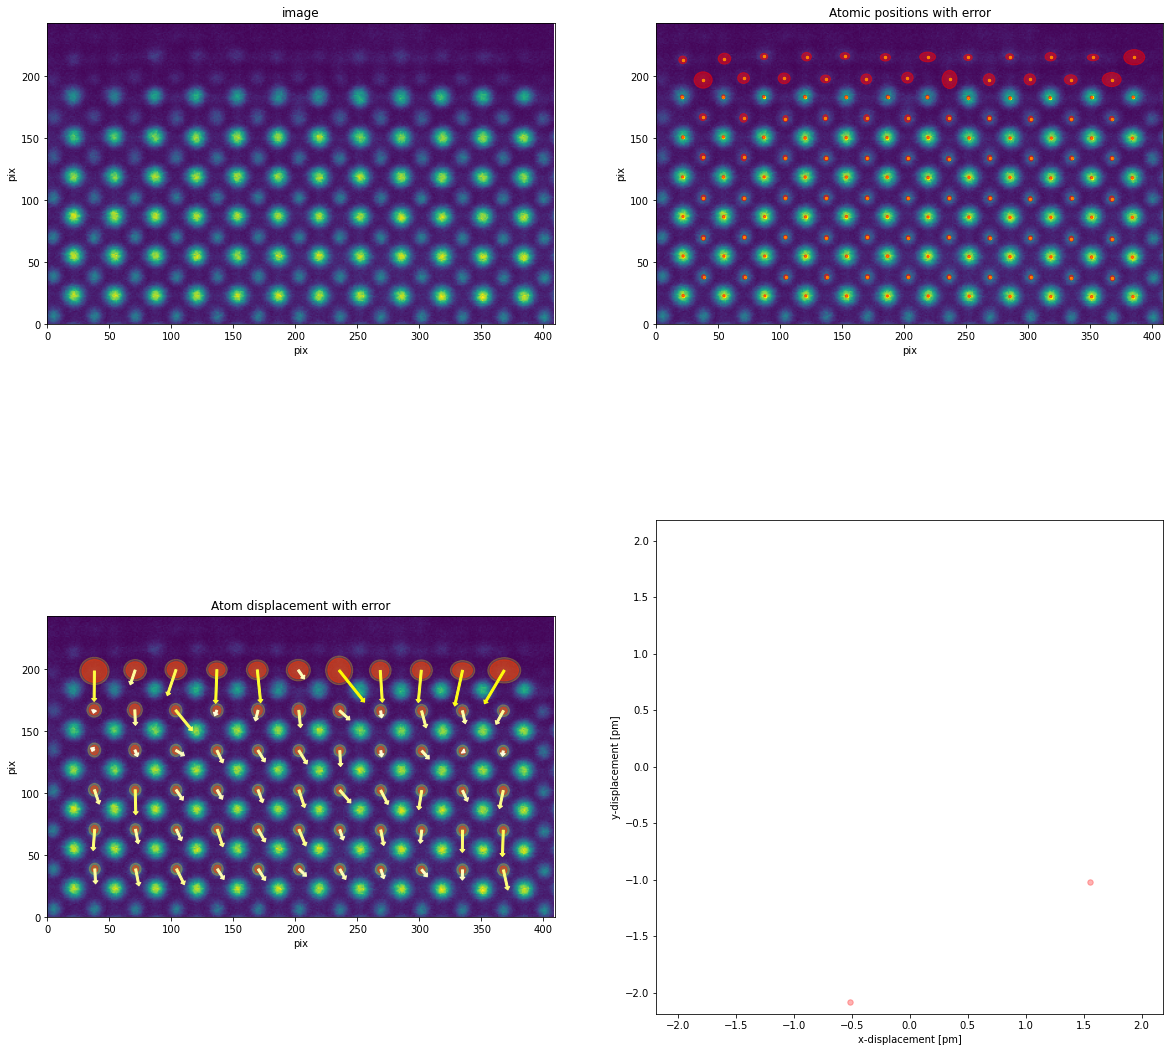

Mean of displacement [pm] = (1.69, -9.35)
Standard deviation of displacement [pm] = (3.74, 5.18)


In [17]:
# 矢印のカラーを定義
cm = generate_cmap(['white', 'yellow'])
color = np.array([ distances[i]/sorted(distances)[-1] for i in range(len(flat_distance_x))])
color = np.where(color>=1, 0.99, color)
color = cm(color)
                  
# Make plots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)

ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
ax2.set_title("Positions of Gaussian centers (or Mass centers)")

ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
if fit_method == "bayes":
    for i in range(len(flat_align_peaks_x)):
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax2.add_patch(patches.Ellipse(xy=(flat_align_peaks_x[i], flat_align_peaks_y[i]), width= flat_align_sd_x[i]*ratio*2*display_sigma, height= flat_align_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
if fit_method == "simple": ax2.set_title("Positions of Gaussian centers")
elif fit_method == "bayes": ax2.set_title("Atomic positions with error")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
ax3.imshow(Z, origin="lower")
for i in range(len(flat_distance_x)):
#    ax3.annotate('', xy=[flat_center_x[i] + flat_distance_x[i]*ratio/2, flat_center_y[i]+flat_distance_y[i]*ratio/2], xytext=[flat_center_x[i]-flat_distance_x[i]*ratio/2, flat_center_y[i]-flat_distance_y[i]*ratio/2], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
#                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    ax3.annotate('', xy=[ flat_center_x[i] + flat_distance_x[i]*ratio, flat_center_y[i] + flat_distance_y[i]*ratio ], xytext=[flat_center_x[i], flat_center_y[i]], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    if fit_method == "bayes":
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width= flat_sd_x[i]*ratio*2*display_sigma, height= flat_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width=(flat_sd_x[i]+scan_distortion/calibration)*2*ratio*display_sigma, height=(flat_sd_y[i]+scan_distortion/calibration)*2*ratio*display_sigma, angle=0, color="yellow", alpha=0.2))
if fit_method == "simple": ax3.set_title("Atom displacement")
elif fit_method == "bayes": ax3.set_title("Atom displacement with error")
ax3.set_xlabel("pix")
ax3.set_ylabel("pix")
ax3.set_xlim(0, xdim)
ax3.set_ylim(0, ydim)
ax4.scatter(np.array(flat_distance_x)*calibration, np.array(flat_distance_y)*calibration, s=30, c="red", marker="o", alpha=0.3)
ax4.set_xlabel("x-displacement [pm]")
ax4.set_ylabel("y-displacement [pm]")
ax4.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
ax4.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
#ax4.set_xlim(-10, 10)
#ax4.set_ylim(-10, 10)
plt.show()

#変位の平均と標準偏差の表示
print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(flat_distance_x))*calibration, np.mean(np.array(flat_distance_y))*calibration))
print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(flat_distance_x))*calibration, np.std(np.array(flat_distance_y))*calibration))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

## 8. Save/Load results of Bayesian inference

In [25]:
#「Peak fit using 2D Gaussian with Bayesian inference」を実行 ⇒ このセルを実行

# save results of Bayesian inference
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir 
    os.mkdir(out_dir)
    out_dir += "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir
    os.mkdir(out_dir)
    out_dir += "//"
np.save(out_dir + "STEM_image.npy", Z)
np.save(out_dir + "summary.npy", summary)
summary_df.to_csv(out_dir + "summary_df.csv")
summary_df.to_pickle(out_dir + "summary_df.pkl")
np.save(out_dir + "Bayes_peaks-x.npy", peaks_x)
np.save(out_dir + "Bayes_peaks-y.npy", peaks_y)
np.save(out_dir + "Bayes_sd-x.npy", sd_x_bayes)
np.save(out_dir + "Bayes_sd-y.npy", sd_y_bayes)

In [103]:
# 「Peak fit using simple 2D Gaussian」まで実行 ⇒ このセルを実行 ⇒ 「Peak fit using 2D Gaussian with Bayesian inference」以下を実行

# load results of Bayesian inference
fit_method = "bayes"
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir + "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir + "//"
Z = np.load(out_dir + 'STEM_image.npy')
#summary = np.load(out_dir + 'summary.npy')
summary_df = pd.read_pickle(out_dir + "summary_df.pkl")
peaks_x = np.load(out_dir + 'Bayes_peaks-x.npy')
peaks_y = np.load(out_dir + 'Bayes_peaks-y.npy')
sd_x_bayes = np.load(out_dir + 'Bayes_sd-x.npy')
sd_y_bayes = np.load(out_dir + 'Bayes_sd-y.npy')

## Test

In [19]:
i = 12

#Model(Uniform bachground)
fit_method = "bayes"

#Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)

print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
    bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())

#MCMC Sampling
with model:
    trace = pm.sample(
        draws=10000,
        tune=5000,
        chains=3,
        return_inferencedata=True
    )

Bayesian Inference of atomic position: 13/150


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 211 seconds.
INFO:pymc3:Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 211 seconds.
There were 3668 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3668 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3917104684590078, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3381 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3381 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43638882512838845, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4472 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Th

mean    sd  hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
Atom Position (μ)[0]       8.50  0.03    8.44  8.56e+00   2.00e-03  2.00e-03   
Atom Position (μ)[1]       8.72  0.03    8.65  8.78e+00   3.00e-03  2.00e-03   
Noise (σ)                  8.81  0.34    8.19  9.46e+00   2.40e-02  1.70e-02   
Background Intensity       8.18  3.16    2.49  1.43e+01   6.98e-01  5.25e-01   
Peak Intensity           223.47  2.74  218.71  2.29e+02   5.86e-01  4.20e-01   
Cholesky Matrix[0]         5.43  0.09    5.27  5.60e+00   1.40e-02  1.00e-02   
Cholesky Matrix[1]        -0.09  0.05   -0.18  7.00e-03   4.00e-03  3.00e-03   
Cholesky Matrix[2]         5.36  0.09    5.20  5.54e+00   1.60e-02  1.20e-02   
Covariance Matrix[0, 0]   29.50  0.99   27.73  3.14e+01   1.57e-01  1.12e-01   
Covariance Matrix[0, 1]   -0.49  0.28   -1.03  8.00e-03   2.30e-02  1.60e-02   
Covariance Matrix[1, 0]   -0.49  0.28   -1.03  8.00e-03   2.30e-02  1.60e-02   
Covariance Matrix[1, 1]   28.78  0.99   27.05  3.07e+01   1.72e-01  1.23e-01   

                         ess_bulk  ess_tail  r_hat  
Atom Position (μ)[0]        201.0     245.0   1.03  
Atom Position (μ)[1]        162.0     186.0   1.02  
Noise (σ)                   204.0     462.0   1.01  
Background Intensity         20.0      75.0   1.13  
Peak Intensity               22.0     215.0   1.12  
Cholesky Matrix[0]           41.0     132.0   1.09  
Cholesky Matrix[1]          147.0     204.0   1.03  
Cholesky Matrix[2]           32.0      84.0   1.09  
Covariance Matrix[0, 0]      41.0     132.0   1.09  
Covariance Matrix[0, 1]     149.0     266.0   1.03  
Covariance Matrix[1, 0]     149.0     266.0   1.03  
Covariance Matrix[1, 1]      32.0      84.0   1.09

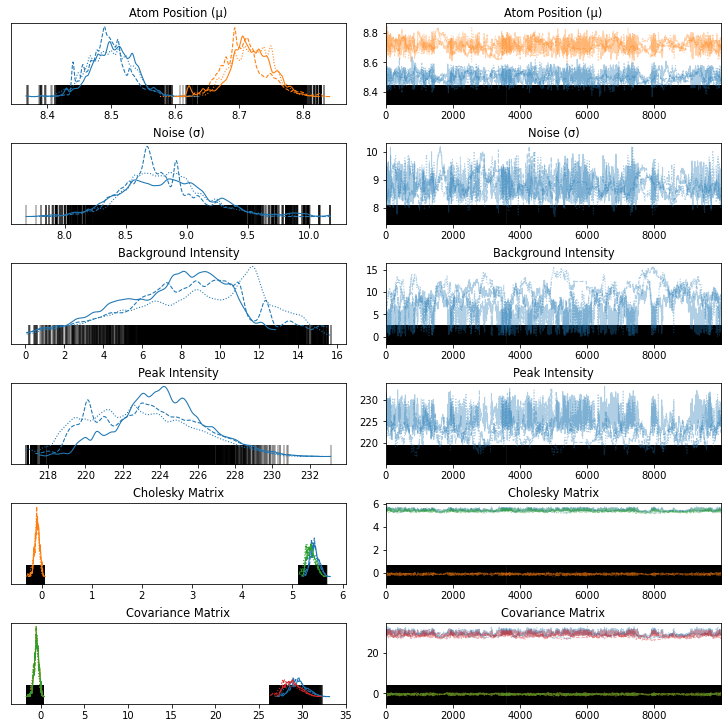

In [20]:
#Display summary
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, figsize=(10,10))
az.summary(trace)

In [21]:
summary[i] = az.summary(trace)
mean_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "mean"]
sd_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "sd"]
peaks_x[i] = mean_vars[0] + round(peaks_x[i]-size_peak/2)
peaks_y[i] = mean_vars[1] + round(peaks_y[i]-size_peak/2)
sd_x_bayes[i] = sd_vars[0]
sd_y_bayes[i] = sd_vars[1]